In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
## install finrl library
#!pip install wrds
#!pip install swig
#!pip install -q condacolab
#import condacolab
#condacolab.install()
#!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-5tyw1f_v
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-5tyw1f_v
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit fee45af12ee0af490cd8e091514173b571dcd9ed
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-842dkee4/elegantrl_ec9c8bd75f1f4be1a56569ade6d73216
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-842dkee4/elegantrl_ec9c8bd75f1f4be1a56569ade6d73216
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 95a1a6bbc92e62c8d2ac470b2315d961da343889
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

import torch
# import torch.nn as nn
# import torch.optim as optim

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

from statsmodels.stats.outliers_influence import variance_inflation_factor

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

%matplotlib inline

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [3]:
processed = pd.read_csv('/content/drive/MyDrive/RL/processed.csv', index_col=0, parse_dates=['date', 'date_available'])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Experiments

In [ ]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79464 entries, 2010-01-04 to 2023-02-28
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   close             79464 non-null  float64       
 1   high              79464 non-null  float64       
 2   low               79464 non-null  float64       
 3   open              79464 non-null  float64       
 4   volume            79464 non-null  int64         
 5   day               79464 non-null  int64         
 6   op_inc_q          79464 non-null  float64       
 7   rev_q             79464 non-null  float64       
 8   net_inc_q         79464 non-null  float64       
 9   tot_assets        79464 non-null  float64       
 10  sh_equity         79464 non-null  float64       
 11  eps_incl_ex       79464 non-null  float64       
 12  com_eq            79464 non-null  float64       
 13  sh_outstanding    79464 non-null  float64       
 14  div_p

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
# Анализ корреляции с целевой переменной (например, future_return)
correlations = []
target = processed['close'].pct_change().shift(-1)  # завтрашняя доходность

for col in processed.select_dtypes(include=[np.number]).columns:
    if col != 'close':
        corr = processed[col].corr(target)
        correlations.append((col, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)
print("Топ-40 признаков по корреляции с будущей доходностью:")
for col, corr in correlations:
    print(f"{col}: {corr:.4f}")

Топ-40 признаков по корреляции с будущей доходностью:
forecast_1: 0.0231
forecast_3: 0.0229
open: 0.0228
forecast_4: 0.0228
low: 0.0227
forecast_5: 0.0227
forecast_2: 0.0227
high: 0.0226
rsi_30: 0.0140
enterprise_value: 0.0140
PE_ratio: 0.0140
macd: 0.0125
market_cap: 0.0125
div_per_sh: 0.0116
DPS: 0.0116
net_inc_q: 0.0104
dividend_yield: 0.0100
PB_ratio: 0.0100
PS_ratio: 0.0093
op_inc_q: 0.0082
turbulence: 0.0063
debt_ratio: 0.0061
revenue_growth: 0.0060
day: 0.0059
dx_30: 0.0058
cci_30: 0.0053
cur_ratio: 0.0043
cash_ratio: 0.0040
long_debt: 0.0040
acc_pay_turnover: 0.0039
eps_incl_ex: 0.0037
EPS: 0.0037
short_debt: 0.0037
acc_rec_turnover: 0.0034
BPS: 0.0034
cur_liabilities: 0.0033
quick_ratio: 0.0032
NPM: 0.0030
tot_liabilities: 0.0029
tot_assets: 0.0028
inventories: 0.0023
cash_eq: 0.0023
eps_growth: 0.0023
payables: 0.0022
com_eq: 0.0020
receivables: 0.0020
sh_equity: 0.0018
OPM: 0.0015
ROE: 0.0015
debt_to_equity: 0.0010
cur_assets: 0.0010
EV_EBITDA: 0.0010
sh_outstanding: 0.0009


In [ ]:
print("Топ-20 признаков по корреляции с будущей доходностью:")
for col, corr in correlations[20:]:
    print(f"{col}: {corr:.4f}")

Топ-20 признаков по корреляции с будущей доходностью:
turbulence: 0.0063
debt_ratio: 0.0061
revenue_growth: 0.0060
day: 0.0059
dx_30: 0.0058
cci_30: 0.0053
cur_ratio: 0.0043
cash_ratio: 0.0040
long_debt: 0.0040
acc_pay_turnover: 0.0039
eps_incl_ex: 0.0037
EPS: 0.0037
short_debt: 0.0037
acc_rec_turnover: 0.0034
BPS: 0.0034
cur_liabilities: 0.0033
quick_ratio: 0.0032
NPM: 0.0030
tot_liabilities: 0.0029
tot_assets: 0.0028
inventories: 0.0023
cash_eq: 0.0023
eps_growth: 0.0023
payables: 0.0022
com_eq: 0.0020
receivables: 0.0020
sh_equity: 0.0018
OPM: 0.0015
ROE: 0.0015
debt_to_equity: 0.0010
cur_assets: 0.0010
EV_EBITDA: 0.0010
sh_outstanding: 0.0009
rev_q: 0.0009
inv_turnover: 0.0007
cogs_q: 0.0006
volume: 0.0004
ROA: 0.0003


In [6]:
# Топ признаков по корреляции + важные дополнения
TOP_CORRELATED_FEATURES = [
    # 1. Прогнозы GRU (первые 3 - самые сильные)
    'forecast_1', 'forecast_2', 'forecast_3','forecast_4', 'forecast_5',

    # 2. Ценовые данные (4 признака)
    'open', 'low', 'high', 'close',

    # 3. Объем (важен для подтверждения трендов)
    'volume',

    # 4. Технические индикаторы (4 признака)
    'rsi_30', 'macd', 'cci_30','dx_30',

    # 5. Фундаментальные (2 признака из топа)
    'PE_ratio', 'enterprise_value',

    'OPM', 'NPM', 'ROA', 'ROE', 'cur_ratio',
    'quick_ratio', 'cash_ratio',
    'inv_turnover', 'acc_rec_turnover', 'acc_pay_turnover',
    'debt_ratio','debt_to_equity', 'PB_ratio', 'dividend_yield',

    # 6. Риск-метрика
    'turbulence',

    # 7. Дивиденды (сигнал устойчивости компании)
    'div_per_sh'
]

In [ ]:
TOP_CORRELATED_FEATURES = [
    # 1. Прогнозы GRU (только лучшие 3 - остальные слишком коррелированы)
    'forecast_1', 'forecast_2', 'forecast_3',

    # 2. Ценовые данные (упрощаем - high/low/open сильно коррелируют с close)
    'close', 'open',  # open важен для gaps

    # 3. Технические индикаторы (выбираем диверсифицированные)
    'rsi_30',      # осциллятор (0.0140)
    'macd',        # тренд (0.0125)
    'dx_30',       # сила тренда (0.0058)
    # 'cci_30' исключаем - коррелирует с rsi_30 (0.0053)

    # 4. Фундаментальные (выбираем НЕкоррелирующие между собой)
    'PE_ratio',          # оценка (0.0140)
    'enterprise_value',  # размер компании (0.0140)
    'div_per_sh',        # дивиденды (0.0116)
    'debt_ratio',        # долговая нагрузка (0.0061)
    'revenue_growth',    # рост (0.0060)

    # 5. Показатели эффективности (по 1 из каждой категории)
    'NPM',               # маржа чистой прибыли (0.0030)
    # исключаем OPM, ROA, ROE - низкая корреляция

    # 6. Ликвидность (выбираем 1-2)
    'cur_ratio',         # текущая ликвидность (0.0043)
    # исключаем quick_ratio, cash_ratio - похожи

    # 7. Деловая активность (выбираем 1)
    'acc_pay_turnover',  # оборачиваемость кредиторки (0.0039)
    # исключаем inv_turnover, acc_rec_turnover - низкая корреляция

    # 8. Риск
    'turbulence',        # турбулентность (0.0063)

    # 9. Время (слабая, но может быть полезна для сезонности)
    'day',               # день месяца (0.0059)
]

print(f"Итого признаков для VIF-анализа: {len(TOP_CORRELATED_FEATURES)}")


print(f"Отобранных признаков: {len(TOP_CORRELATED_FEATURES)}")
def check_vif(features_df):
    """Проверка мультиколлинеарности через VIF"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features_df.columns

    # Вычисляем VIF
    vif_data["VIF"] = [variance_inflation_factor(features_df.values, i)
                       for i in range(len(features_df.columns))]

    return vif_data.sort_values("VIF", ascending=False)

# Создаем DataFrame с выбранными признаками
features_df = processed[TOP_CORRELATED_FEATURES].dropna()

Итого признаков для VIF-анализа: 18
Отобранных признаков: 18


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Проверяем VIF
vif_results = check_vif(features_df)
print("Мультиколлинеарность (VIF > 10 - проблема):")
print(vif_results)

Мультиколлинеарность (VIF > 10 - проблема):
             feature           VIF
4               open  11712.279644
2         forecast_3   6328.476170
3              close   5468.589397
0         forecast_1   5271.403371
1         forecast_2   2202.557631
5             rsi_30     25.049043
11        debt_ratio     14.504754
14         cur_ratio      8.083324
10        div_per_sh      6.166212
13               NPM      4.197852
15  acc_pay_turnover      3.582487
7              dx_30      3.103086
8           PE_ratio      3.087091
17               day      3.041703
9   enterprise_value      2.642484
16        turbulence      1.665835
6               macd      1.342587
12    revenue_growth      1.192416


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_reduction(data, features, n_components=0.95):
    """
    Сокращение признаков с помощью PCA
    """
    df = data[features].copy().fillna(method='ffill')

    # Стандартизация
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    print(f"PCA результаты:")
    print(f"Оригинальные признаки: {len(features)}")
    print(f"PCA компоненты: {pca.n_components_}")
    print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.3f}")

    # Важность признаков в каждой компоненте
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=features
    )

    print("\nТоп-5 признаков по важности в первой компоненте:")
    print(loadings['PC1'].abs().sort_values(ascending=False))

    return pca_data, loadings

# Если VIF показывает высокую мультиколлинеарность
pca_features, loadings = pca_feature_reduction(
    processed,
    TOP_CORRELATED_FEATURES,
    n_components=0.95  # объяснить 95% дисперсии
)

PCA результаты:
Оригинальные признаки: 32
PCA компоненты: 15
Объясненная дисперсия: 0.953

Топ-5 признаков по важности в первой компоненте:
low                 0.304290
open                0.304239
close               0.304232
high                0.304187
forecast_2          0.304180
forecast_4          0.304167
forecast_5          0.304156
forecast_3          0.304134
forecast_1          0.303848
div_per_sh          0.181357
debt_ratio          0.153761
enterprise_value    0.134771
dividend_yield      0.132554
volume              0.124589
PE_ratio            0.112678
PB_ratio            0.101578
cash_ratio          0.084677
cur_ratio           0.078305
quick_ratio         0.076162
ROE                 0.059433
debt_to_equity      0.059145
macd                0.059107
acc_pay_turnover    0.054129
acc_rec_turnover    0.047790
rsi_30              0.022012
inv_turnover        0.019651
ROA                 0.018876
turbulence          0.015516
cci_30              0.010798
NPM                

/tmp/ipython-input-3312914694.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data[features].copy().fillna(method='ffill')


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def feature_importance_analysis(data, features, target='close'):
    """Анализ важности признаков"""
    # Подготовка данных
    X = data[features].copy().fillna(method='ffill')
    y = data[target].pct_change().shift(-1)  # будущая доходность

    # Выравнивание
    aligned_idx = X.index.intersection(y.dropna().index)
    X = X.loc[aligned_idx]
    y = y.loc[aligned_idx]

    # Разделение
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # Обучение
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Важность признаков
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Топ-15 важных признаков по RandomForest:")
    print(importance.head(15).to_string())

    return importance

# Анализ
importance_df = feature_importance_analysis(processed, TOP_CORRELATED_FEATURES)

# Выбор признаков по порогу важности
threshold = 0.01  # 1%
selected_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
print(f"\nПризнаки с важностью >{threshold}: {len(selected_features)}")
print(selected_features)

/tmp/ipython-input-3285813482.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[features].copy().fillna(method='ffill')


Топ-15 важных признаков по RandomForest:
             feature  importance
30        turbulence    0.178405
11              macd    0.096911
12            cci_30    0.067011
9             volume    0.065076
10            rsi_30    0.063430
13             dx_30    0.059229
15  enterprise_value    0.044588
14          PE_ratio    0.044091
29    dividend_yield    0.038881
28          PB_ratio    0.035497
8              close    0.018252
18               ROA    0.017298
17               NPM    0.017298
24  acc_rec_turnover    0.016928
25  acc_pay_turnover    0.016241

Признаки с важностью >0.01: 32
['turbulence', 'macd', 'cci_30', 'volume', 'rsi_30', 'dx_30', 'enterprise_value', 'PE_ratio', 'dividend_yield', 'PB_ratio', 'close', 'ROA', 'NPM', 'acc_rec_turnover', 'acc_pay_turnover', 'low', 'open', 'OPM', 'high', 'ROE', 'inv_turnover', 'cash_ratio', 'debt_to_equity', 'debt_ratio', 'cur_ratio', 'div_per_sh', 'forecast_5', 'forecast_3', 'forecast_2', 'forecast_4', 'forecast_1', 'quick_ratio']


## Visualisations

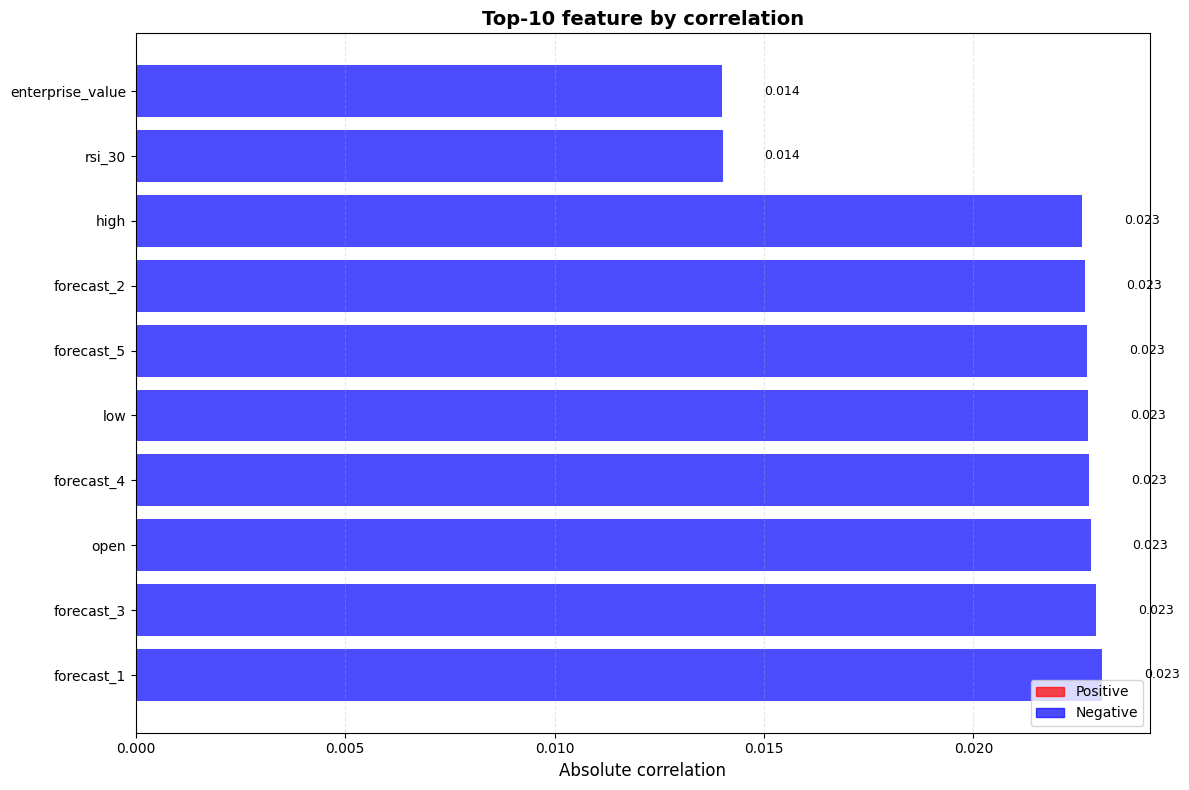

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_correlation_results(correlations, top_n=20):
    """
    График корреляций признаков с целевой переменной
    """
    # Берем топ-N признаков
    top_corr = correlations[:top_n]
    features, corr_values = zip(*top_corr)

    # Создаем цветовую схему (красный для положительной, синий для отрицательной корреляции)
    colors = ['red' if processed[feat].corr(target) > 0 else 'blue'
              for feat in features]

    fig, ax = plt.subplots(figsize=(12, 8))

    # Горизонтальный барплот
    bars = ax.barh(features, corr_values, color=colors, alpha=0.7)
    ax.set_xlabel('Absolute correlation', fontsize=12)
    ax.set_title(f'Top-{top_n} feature by correlation',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Добавляем значения на бары
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

    # Линия нулевой корреляции
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

    # Легенда
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', alpha=0.7, label='Positive')
    blue_patch = mpatches.Patch(color='blue', alpha=0.7, label='Negative')
    ax.legend(handles=[red_patch, blue_patch], loc='lower right')

    plt.tight_layout()
    return fig

# Использование
fig1 = plot_correlation_results(correlations, top_n=10)
plt.show()

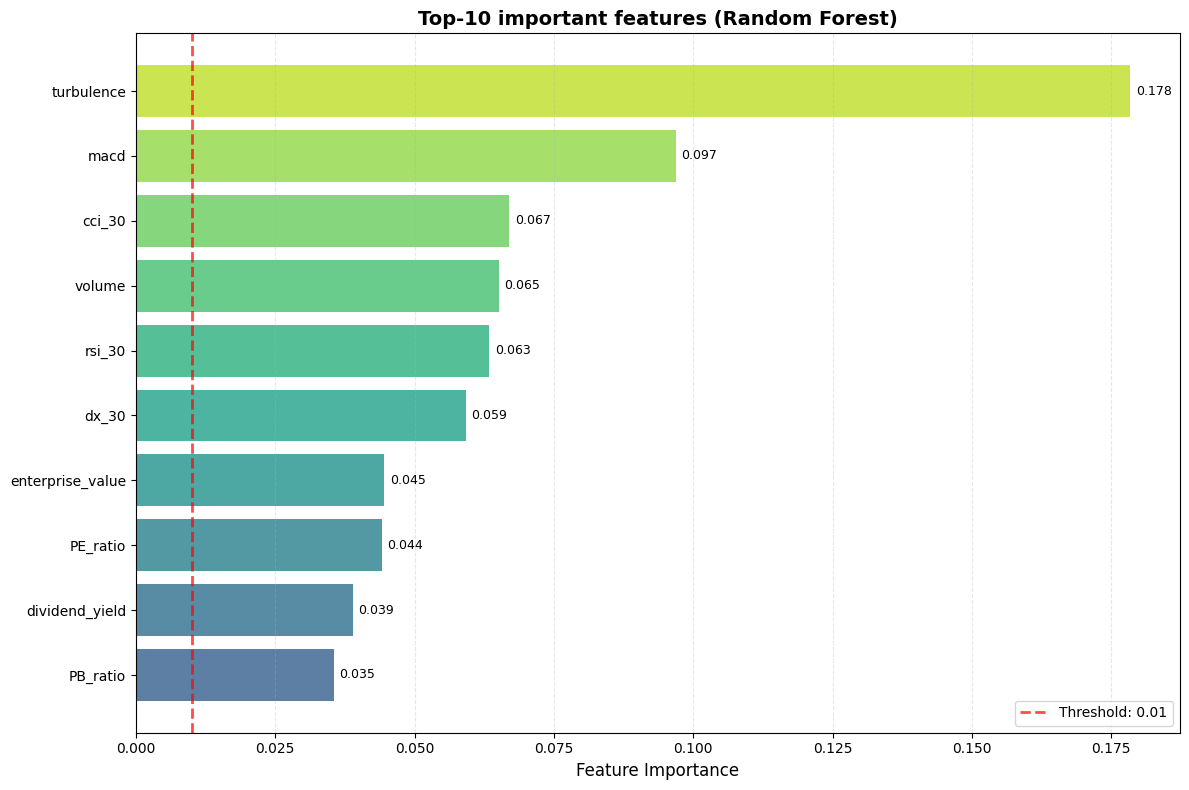

In [24]:
def plot_feature_importance(importance_df, top_n=20, threshold=None):
    """
    График важности признаков из Random Forest
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    # Берем топ-N признаков
    top_features = importance_df.head(top_n).copy()

    # Сортировка для горизонтального графика
    top_features = top_features.sort_values('importance', ascending=True)

    # Создаем градиент цветов
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))

    # Горизонтальный барплот
    bars = ax.barh(top_features['feature'], top_features['importance'],
                   color=colors, alpha=0.8)

    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title(f'Top-{top_n} important features (Random Forest)',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Добавляем пороговую линию если указана
    if threshold:
        ax.axvline(x=threshold, color='red', linestyle='--',
                   linewidth=2, alpha=0.7, label=f'Threshold: {threshold}')
        ax.legend()

    # Добавляем значения на бары
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    return fig

# Использование
fig2 = plot_feature_importance(importance_df, top_n=10, threshold=0.01)
plt.show()

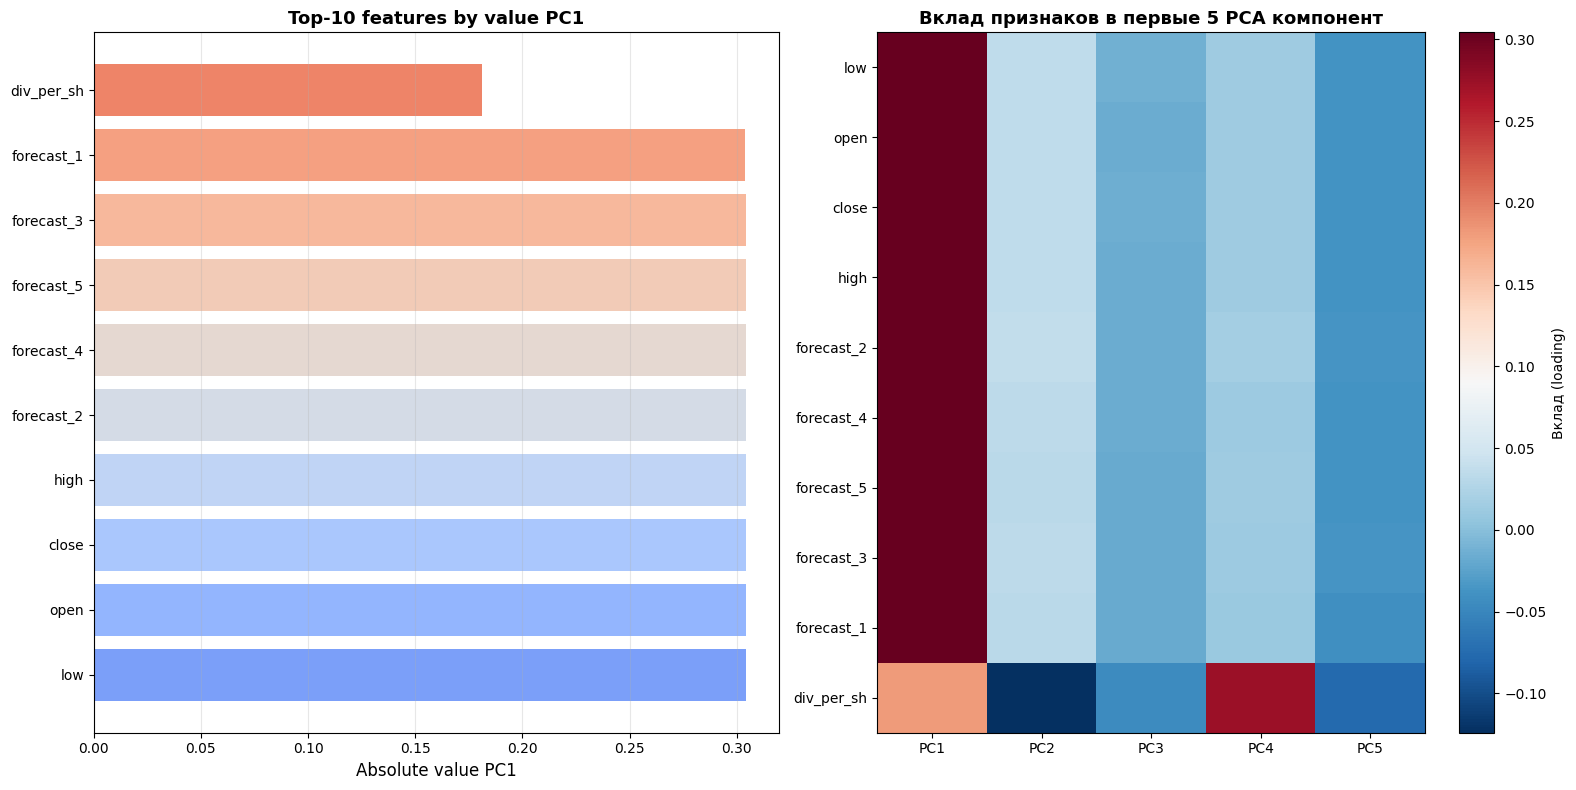

In [26]:
def plot_pca_loadings(loadings, top_n=15):
    """
    График вклада признаков в основные PCA компоненты
    """
    # Берем топ-N признаков по первой компоненте
    top_loadings = loadings['PC1'].abs().sort_values(ascending=False).head(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # График 1: Вклад в первую компоненту
    colors1 = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(top_loadings)))
    bars1 = axes[0].barh(top_loadings.index, top_loadings.values, color=colors1)
    axes[0].set_xlabel('Absolute value PC1', fontsize=12)
    axes[0].set_title(f'Top-{top_n} features by value PC1',
                     fontsize=13, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # График 2: Heatmap вкладов в первые 5 компонент
    # Берем топ-10 признаков по PC1 и смотрим их вклад в первые 5 компонент
    top_features = top_loadings.index[:10]
    component_loadings = loadings.loc[top_features, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

    # Heatmap
    im = axes[1].imshow(component_loadings.values, cmap='RdBu_r', aspect='auto')
    axes[1].set_xticks(range(5))
    axes[1].set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
    axes[1].set_yticks(range(len(top_features)))
    axes[1].set_yticklabels(top_features)
    axes[1].set_title('Вклад признаков в первые 5 PCA компонент',
                     fontsize=13, fontweight='bold')

    # Цветовая шкала
    plt.colorbar(im, ax=axes[1], label='Вклад (loading)')

    plt.tight_layout()
    return fig

# Использование
fig3 = plot_pca_loadings(loadings, top_n=10)
plt.show()

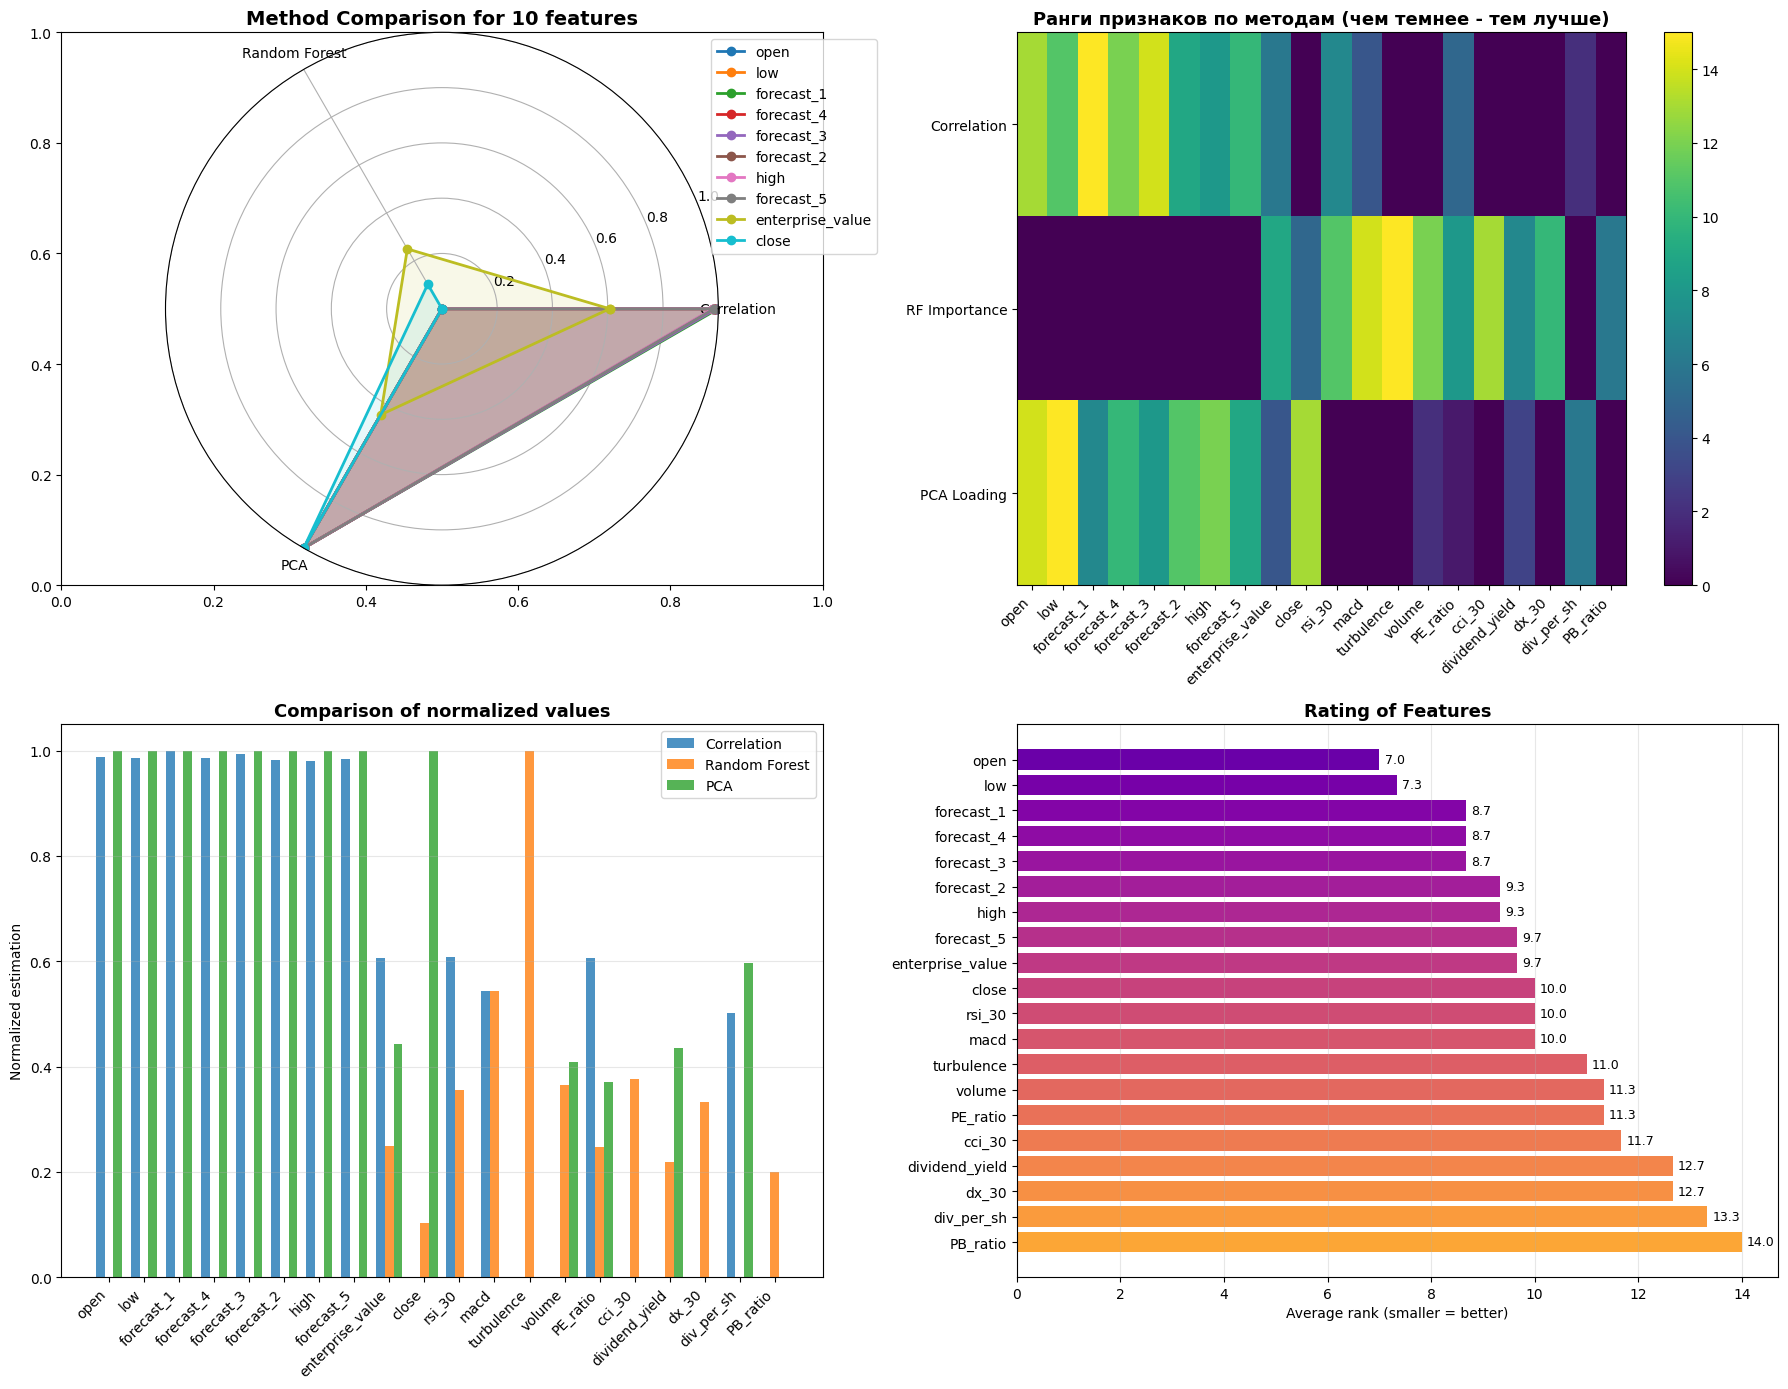

In [28]:
def plot_comparative_analysis(correlations, importance_df, loadings, top_n=15):
    """
    Комбинированный график сравнения трех методов отбора признаков
    """
    # Подготовка данных
    # 1. Корреляции
    corr_features = [f[0] for f in correlations[:top_n]]
    corr_scores = [abs(f[1]) for f in correlations[:top_n]]

    # 2. Важность признаков
    imp_features = importance_df.head(top_n)['feature'].tolist()
    imp_scores = importance_df.head(top_n)['importance'].tolist()

    # 3. PCA loadings
    pca_features = loadings['PC1'].abs().sort_values(ascending=False).head(top_n).index.tolist()
    pca_scores = loadings['PC1'].abs().sort_values(ascending=False).head(top_n).values.tolist()

    # Находим общие признаки
    all_features = set(corr_features) | set(imp_features) | set(pca_features)

    # Создаем DataFrame для сравнения
    comparison_data = []
    for feature in all_features:
        row = {'feature': feature}

        # Получаем ранги из каждого метода
        row['corr_rank'] = corr_features.index(feature) + 1 if feature in corr_features else top_n + 1
        row['rf_rank'] = imp_features.index(feature) + 1 if feature in imp_features else top_n + 1
        row['pca_rank'] = pca_features.index(feature) + 1 if feature in pca_features else top_n + 1

        # Нормализованные оценки
        row['corr_score'] = corr_scores[corr_features.index(feature)] if feature in corr_features else 0
        row['rf_score'] = imp_scores[imp_features.index(feature)] if feature in imp_features else 0
        row['pca_score'] = pca_scores[pca_features.index(feature)] if feature in pca_features else 0

        comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data)

    # Нормализуем оценки для сравнения
    for col in ['corr_score', 'rf_score', 'pca_score']:
        comparison_df[f'{col}_norm'] = comparison_df[col] / comparison_df[col].max()

    # Берем топ-20 признаков по сумме рангов
    comparison_df['avg_rank'] = comparison_df[['corr_rank', 'rf_rank', 'pca_rank']].mean(axis=1)
    comparison_df = comparison_df.sort_values('avg_rank').head(20)

    # Создаем график
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # График 1: Radar chart для топ-5 признаков
    top5 = comparison_df.head(10)['feature'].tolist()

    # Данные для radar chart
    categories = ['Correlation', 'Random Forest', 'PCA']
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax1 = fig.add_subplot(2, 2, 1, polar=True)
    colors = plt.cm.tab10(np.linspace(0, 1, len(top5)))

    for idx, feature in enumerate(top5):
        row = comparison_df[comparison_df['feature'] == feature].iloc[0]
        values = [row['corr_score_norm'], row['rf_score_norm'], row['pca_score_norm']]
        values += values[:1]

        ax1.plot(angles, values, 'o-', linewidth=2, label=feature, color=colors[idx])
        ax1.fill(angles, values, alpha=0.1, color=colors[idx])

    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories)
    ax1.set_ylim(0, 1)
    ax1.set_title('Method Comparison for 10 features', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # График 2: Heatmap рангов
    ax2 = axes[0, 1]
    rank_data = comparison_df.set_index('feature')[['corr_rank', 'rf_rank', 'pca_rank']]

    # Инвертируем ранги для лучшей визуализации (1 = лучший)
    rank_data_inv = (top_n + 1) - rank_data

    im2 = ax2.imshow(rank_data_inv.T, cmap='viridis', aspect='auto')
    ax2.set_xticks(range(len(rank_data)))
    ax2.set_xticklabels(rank_data.index, rotation=45, ha='right')
    ax2.set_yticks(range(3))
    ax2.set_yticklabels(['Correlation', 'RF Importance', 'PCA Loading'])
    ax2.set_title('Ранги признаков по методам (чем темнее - тем лучше)',
                 fontsize=13, fontweight='bold')

    plt.colorbar(im2, ax=ax2)

    # График 3: Сравнение нормализованных оценок
    ax3 = axes[1, 0]

    x = np.arange(len(comparison_df))
    width = 0.25

    bars1 = ax3.bar(x - width, comparison_df['corr_score_norm'], width,
                    label='Correlation', alpha=0.8)
    bars2 = ax3.bar(x, comparison_df['rf_score_norm'], width,
                    label='Random Forest', alpha=0.8)
    bars3 = ax3.bar(x + width, comparison_df['pca_score_norm'], width,
                    label='PCA', alpha=0.8)

    ax3.set_xticks(x)
    ax3.set_xticklabels(comparison_df['feature'], rotation=45, ha='right')
    ax3.set_ylabel('Normalized estimation')
    ax3.set_title('Comparison of normalized values',
                 fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # График 4: Консенсус (средний ранг)
    ax4 = axes[1, 1]

    # Сортируем по среднему рангу
    consensus_df = comparison_df.sort_values('avg_rank')

    colors_consensus = plt.cm.plasma(np.linspace(0.2, 0.8, len(consensus_df)))
    bars = ax4.barh(consensus_df['feature'], consensus_df['avg_rank'],
                    color=colors_consensus)

    ax4.set_xlabel('Average rank (smaller = better)')
    ax4.set_title('Rating of Features',
                 fontsize=13, fontweight='bold')
    ax4.invert_yaxis()  # Лучшие признаки сверху
    ax4.grid(axis='x', alpha=0.3)

    # Добавляем значения
    for bar in bars:
        width = bar.get_width()
        ax4.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    return fig, comparison_df

# Использование
fig4, comparison_df = plot_comparative_analysis(correlations, importance_df, loadings, top_n=15)
plt.show()

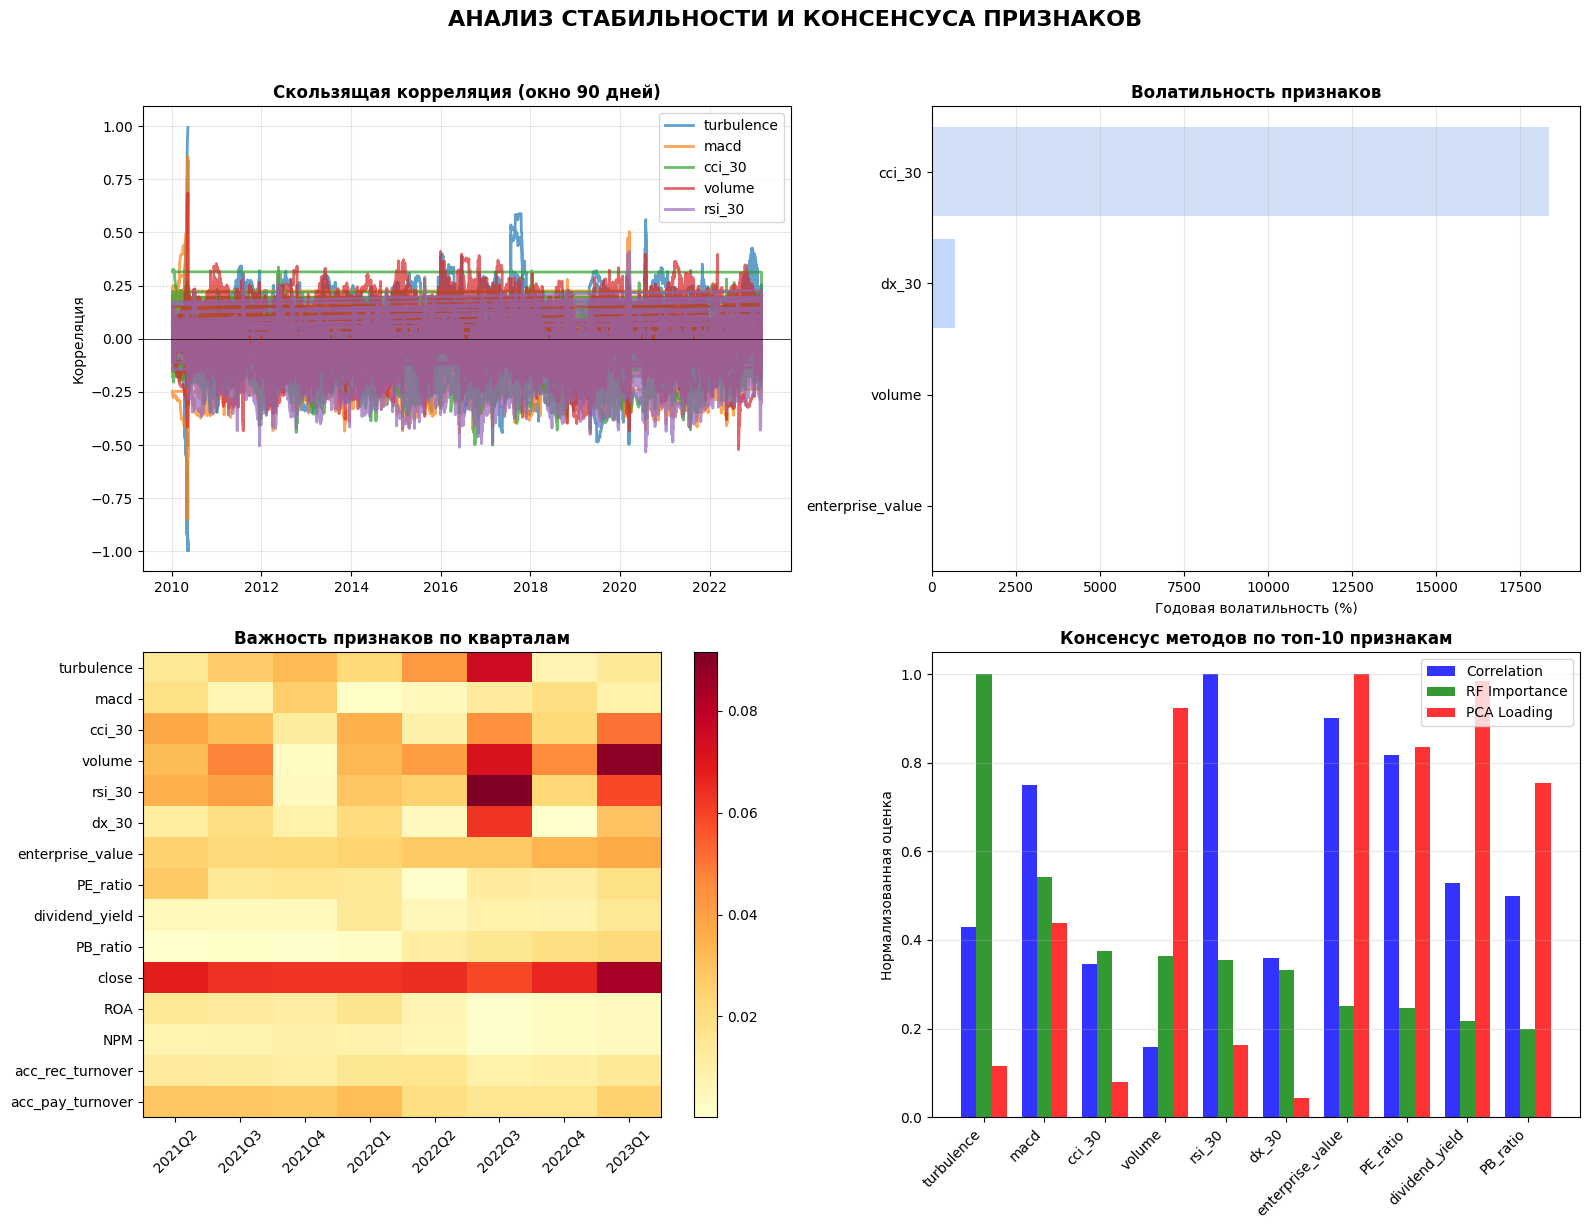

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_temporal_feature_stability(data, selected_features, window_days=90):
    """
    Анализ стабильности важности признаков во времени
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Скользящая корреляция для топ-5 признаков
    top_features = selected_features[:5]

    for feature in top_features:
        # Скользящая корреляция с целевой переменной
        rolling_corr = data[feature].rolling(window=window_days).corr(
            data['close'].pct_change().shift(-1)
        )
        axes[0, 0].plot(rolling_corr.index, rolling_corr.values,
                       label=feature, linewidth=2, alpha=0.7)

    axes[0, 0].set_title(f'Скользящая корреляция (окно {window_days} дней)',
                        fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Корреляция')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    # 2. Волатильность важности признаков
    volatility_data = []
    for feature in selected_features[:10]:
        feature_series = data[feature].dropna()
        # Мера изменчивости (стандартное отклонение изменений)
        volatility = feature_series.pct_change().std() * np.sqrt(252)  # Годовая волатильность
        volatility_data.append((feature, volatility))

    volatility_df = pd.DataFrame(volatility_data, columns=['feature', 'volatility'])
    volatility_df = volatility_df.sort_values('volatility')

    colors_vol = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(volatility_df)))
    axes[0, 1].barh(volatility_df['feature'], volatility_df['volatility'],
                    color=colors_vol, alpha=0.7)
    axes[0, 1].set_title('Волатильность признаков', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Годовая волатильность (%)')
    axes[0, 1].grid(axis='x', alpha=0.3)

    # 3. Heatmap важности по периодам (кварталам)
    data['quarter'] = data.index.to_period('Q')
    quarterly_importance = []

    for quarter in sorted(data['quarter'].unique())[-8:]:  # Последние 8 кварталов
        quarter_data = data[data['quarter'] == quarter]
        if len(quarter_data) > 30:  # Минимум 30 наблюдений
            correlations_q = []
            target_q = quarter_data['close'].pct_change().shift(-1)

            for feature in selected_features[:15]:
                corr = quarter_data[feature].corr(target_q)
                correlations_q.append(abs(corr) if not pd.isna(corr) else 0)

            quarterly_importance.append(correlations_q)

    if quarterly_importance:
        quarterly_df = pd.DataFrame(
            quarterly_importance,
            columns=selected_features[:15],
            index=sorted(data['quarter'].unique())[-len(quarterly_importance):]
        )

        im = axes[1, 0].imshow(quarterly_df.T, cmap='YlOrRd', aspect='auto')
        axes[1, 0].set_xticks(range(len(quarterly_df)))
        axes[1, 0].set_xticklabels([str(q) for q in quarterly_df.index], rotation=45)
        axes[1, 0].set_yticks(range(len(quarterly_df.columns)))
        axes[1, 0].set_yticklabels(quarterly_df.columns)
        axes[1, 0].set_title('Важность признаков по кварталам',
                           fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=axes[1, 0])

    # 4. Матрица консенсуса методов
    consensus_matrix = np.zeros((len(selected_features[:10]), 3))

    for i, feature in enumerate(selected_features[:10]):
        # Корреляция
        corr_rank = next((idx for idx, (f, _) in enumerate(correlations)
                         if f == feature), 100)
        consensus_matrix[i, 0] = 1 / (corr_rank + 1)  # Обратный ранг

        # Random Forest
        rf_row = importance_df[importance_df['feature'] == feature]
        consensus_matrix[i, 1] = rf_row['importance'].values[0] if not rf_row.empty else 0

        # PCA
        if feature in loadings.index:
            consensus_matrix[i, 2] = abs(loadings.loc[feature, 'PC1'])

    # Нормализация
    consensus_matrix = consensus_matrix / consensus_matrix.max(axis=0)

    x = np.arange(len(selected_features[:10]))
    width = 0.25

    axes[1, 1].bar(x - width, consensus_matrix[:, 0], width,
                   label='Correlation', alpha=0.8, color='blue')
    axes[1, 1].bar(x, consensus_matrix[:, 1], width,
                   label='RF Importance', alpha=0.8, color='green')
    axes[1, 1].bar(x + width, consensus_matrix[:, 2], width,
                   label='PCA Loading', alpha=0.8, color='red')

    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(selected_features[:10], rotation=45, ha='right')
    axes[1, 1].set_ylabel('Нормализованная оценка')
    axes[1, 1].set_title('Консенсус методов по топ-10 признакам',
                        fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.suptitle('АНАЛИЗ СТАБИЛЬНОСТИ И КОНСЕНСУСА ПРИЗНАКОВ',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    return fig

# Использование
fig5 = plot_temporal_feature_stability(processed, selected_features, window_days=90)
plt.show()

Используем только прогнозы GRU по следующим причинам:

Прогнозы GRU уже включают информацию о ценах (они обучены на них)

PCA показывает, что прогнозы имеют максимальную нагрузку в первой компоненте

Избегаем мультиколлинеарности - убираем open, close

Сохраняем информативность - прогнозы лучше чем сырые цены

Таким образом оптимальный набор

In [ ]:
OPTIMIZED_FEATURES = [
    # 1. Прогнозы GRU (2 лучших)
    'forecast_1', 'forecast_3',  # forecast_2 исключаем как промежуточный

    # 2. Технические индикаторы (3 разных типа)
    'macd',      # тренд и моментум
    'rsi_30',    # осциллятор, перекупленность
    'dx_30',     # сила тренда

    # 3. Фундаментальные (2 некоррелированных)
    'PE_ratio',          # оценка компании
    'enterprise_value',  # размер компании

    # 4. Финансовое здоровье
    'debt_ratio',        # долговая нагрузка

    # 5. Операционная эффективность
    'acc_pay_turnover',  # оборачиваемость кредиторки
    'NPM',               # чистая маржа

    # 6. Рост бизнеса
    'revenue_growth',    # рост выручки

    # 7. Риск-метрика (самый важный!)
    'turbulence',

    # 8. Временной фактор
    'day'               # день месяца для сезонности
]

Финальный оптимизированный набор: 13 признаков
Признаки: ['forecast_1', 'forecast_3', 'macd', 'rsi_30', 'dx_30', 'PE_ratio', 'enterprise_value', 'debt_ratio', 'acc_pay_turnover', 'NPM', 'revenue_growth', 'turbulence', 'day']


In [6]:
def check_final_vif(data, features):
    """Проверка VIF для финального набора"""
    df = data[features].copy().fillna(method='ffill')

    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i)
        for i in range(len(df.columns))
    ]

    vif_data = vif_data.sort_values("VIF", ascending=False)

    print("Мультиколлинеарность финального набора:")
    print(vif_data.to_string())
    print(f"\nМаксимальный VIF: {vif_data['VIF'].max():.2f}")
    print(f"Средний VIF: {vif_data['VIF'].mean():.2f}")

    # Проверка порогов
    high_vif = vif_data[vif_data['VIF'] > 10]
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]

    if len(high_vif) > 0:
        print(f"\n⚠️  ВНИМАНИЕ: {len(high_vif)} признаков с VIF > 10:")
        print(high_vif[['feature', 'VIF']].to_string())
    else:
        print("✓ Нет признаков с VIF > 10")

    return vif_data

In [ ]:
# Проверяем
optimal_vif = check_final_vif(processed, OPTIMIZED_FEATURES)

/tmp/ipython-input-68622344.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data[features].copy().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Мультиколлинеарность финального набора:
             feature          VIF
1         forecast_3  2984.209435
0         forecast_1  2979.918959
3             rsi_30    20.785003
7         debt_ratio    13.241510
9                NPM     3.403746
4              dx_30     3.097730
12               day     3.033206
5           PE_ratio     3.002571
8   acc_pay_turnover     2.907971
6   enterprise_value     2.559349
11        turbulence     1.660972
2               macd     1.291804
10    revenue_growth     1.170895

Максимальный VIF: 2984.21
Средний VIF: 463.10

⚠️  ВНИМАНИЕ: 4 признаков с VIF > 10:
      feature          VIF
1  forecast_3  2984.209435
0  forecast_1  2979.918959
3      rsi_30    20.785003
7  debt_ratio    13.241510


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# Убираем rsi_30 и debt_ratio
# Преобразуем forecast в одну переменную
def create_forecast_features(data):
    """Создание агрегированных признаков из прогнозов"""
    df = data.copy()

    # 1. Средний прогноз
    df['forecast_mean'] = df[['forecast_1', 'forecast_3']].mean(axis=1)

    # 2. Разброс прогнозов (неопределенность)
    df['forecast_std'] = df[['forecast_1', 'forecast_3']].std(axis=1)

    # 3. Тренд прогнозов
    df['forecast_trend'] = df['forecast_3'] - df['forecast_1']

    return df

# 1. Создаем агрегированные прогнозные признаки
processed = create_forecast_features(processed)

# 2. Финальный проверенный набор
FINAL_FEATURES = [
    # Прогнозные (агрегированные)
    'forecast_mean',      # основной сигнал
    'forecast_std',       # уверенность прогноза
    'forecast_trend',     # изменение прогнозов

    # Технические
    'macd',
    'dx_30',

    # Фундаментальные
    'PE_ratio',

    # Бизнес-метрики
    'NPM',
    'acc_pay_turnover',
    'revenue_growth',

    # Риск
    'turbulence',

    # Время
    'day'
]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
# 3. Проверяем VIF
print("Проверка финального набора...")
final_vif = check_final_vif(processed, FINAL_FEATURES)

Проверка финального набора...


/tmp/ipython-input-3380345563.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = data[features].copy().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Мультиколлинеарность финального набора:
             feature       VIF
0      forecast_mean  3.836353
5           PE_ratio  2.804396
6                NPM  2.751018
10               day  2.606471
4              dx_30  2.560930
7   acc_pay_turnover  2.252699
1       forecast_std  1.729395
9         turbulence  1.636837
8     revenue_growth  1.160188
3               macd  1.121797
2     forecast_trend  1.049338

Максимальный VIF: 3.84
Средний VIF: 2.14
✓ Нет признаков с VIF > 10


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training

In [5]:
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

In [6]:
processed = processed.reset_index()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
processed

date      close       high        low       open    volume  day  \
0     2010-01-04  32.555485  32.698691  32.133824  32.467973   6894300    0   
1     2010-01-05  32.483871  32.802105  32.117899  32.483871  10641200    1   
2     2010-01-06  33.008957  33.152160  32.754366  32.802102   8399400    2   
3     2010-01-07  33.544331  33.752087  32.849154  32.969010   8981700    3   
4     2010-01-08  33.520351  33.943850  33.080872  33.368529   7907700    4   
...          ...        ...        ...        ...        ...       ...  ...   
79459 2023-02-22  46.447548  47.519857  45.970962  47.262245  29844000    2   
79460 2023-02-23  45.755215  46.489409  45.310830  46.489409  22021200    3   
79461 2023-02-24  45.877579  45.964523  44.930849  45.352692  20623500    4   
79462 2023-02-27  45.545906  46.077231  45.294732  45.954865  16647300    0   
79463 2023-02-28  45.768093  45.935540  45.388114  45.404215  18054000    1   

       op_inc_q     rev_q  net_inc_q  ...       dx_30  turbulence  forecast_1  \
0         843.0    6559.0      640.0  ...  100.000000    0.000000   33.360706   
1         843.0    6559.0      640.0  ...  100.000000    0.000000   33.360706   
2         843.0    6559.0      640.0  ...  100.000000    0.000000   33.360706   
3         843.0    6559.0      640.0  ...  100.000000    0.000000   33.360706   
4         843.0    6559.0      640.0  ...  100.000000    0.000000   33.360706   
...         ...       ...        ...  ...         ...         ...         ...   
79459    6909.0  138310.0     2730.0  ...    9.765563    7.736607   47.855617   
79460    6909.0  138310.0     2730.0  ...    2.963158   10.269498   47.855617   
79461    6909.0  138310.0     2730.0  ...    9.425905   11.886652   47.855617   
79462    6909.0  138310.0     2730.0  ...    7.162916    4.804969   47.855617   
79463    6909.0  138310.0     2730.0  ...    7.162916   36.307277   47.855617   

       forecast_2  forecast_3  forecast_4  forecast_5  forecast_mean  \
0       33.869236   34.112818   34.596245   34.784816      33.736762   
1       33.869236   34.112818   34.596245   34.784816      33.736762   
2       33.869236   34.112818   34.596245   34.784816      33.736762   
3       33.869236   34.112818   34.596245   34.784816      33.736762   
4       33.869236   34.112818   34.596245   34.784816      33.736762   
...           ...         ...         ...         ...            ...   
79459   45.237896   45.117106   47.288696   46.529797      46.486361   
79460   45.237896   45.117106   47.288696   46.529797      46.486361   
79461   45.237896   45.117106   47.288696   46.529797      46.486361   
79462   45.237896   45.117106   47.288696   46.529797      46.486361   
79463   45.237896   45.117106   47.288696   46.529797      46.486361   

       forecast_std  forecast_trend  
0          0.531824        0.752112  
1          0.531824        0.752112  
2          0.531824        0.752112  
3          0.531824        0.752112  
4          0.531824        0.752112  
...             ...             ...  
79459      1.936420       -2.738511  
79460      1.936420       -2.738511  
79461      1.936420       -2.738511  
79462      1.936420       -2.738511  
79463      1.936420       -2.738511  

[79464 rows x 65 columns]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
# Data Split
# Since Ensemble tested from 2022-01-03 to 2023-01-03

train_start = '2010-01-01'
train_end = '2022-01-03'
test_start = '2022-01-03'
test_end = '2023-01-03'


In [ ]:
train = data_split(processed, train_start, train_end)
trade = data_split(processed, test_start, test_end)

# RL Algorithms Overview for FinRL

| Algorithm | Description | When to Use | Key Logic Difference |
|-----------|-------------|-------------|----------------------|
| **A2C** | Synchronous Actor-Critic. One agent collects data and updates. | Simple environments, low compute, stability over speed. | **Synchronous**, single thread → lower variance, slower. |
| **DDPG** | Deep Deterministic Policy Gradient. Off-policy Actor-Critic for **continuous actions**. | Continuous action spaces (e.g., trade size), unstable dynamics. | **Off-policy + deterministic policy**; uses Q-learning for critic. |
| **PPO** | Proximal Policy Optimization. On-policy with **clipped probability ratio**. | **Default choice** in FinRL — stable, sample-efficient. | **On-policy + clipping** → prevents large policy shifts. |
| **TD3** | Twin Delayed DDPG. Fixes overestimation with **dual critics**, delayed updates, target noise. | Continuous actions + **Q-value overestimation** issues. | **Twin critics + delay + noise** → more robust Q-learning. |
| **SAC** | Soft Actor-Critic. Off-policy, maximizes **entropy** for exploration. | Complex environments, sparse rewards, need adaptive exploration. | **Entropy regularization** → balances exploration automatically. |


## Training. Best Basic Model

In [8]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

In [9]:
# Env kwargs
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(FINAL_FEATURES)*stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": [0.001]*stock_dimension,
    "sell_cost_pct": [0.001]*stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": FINAL_FEATURES,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "num_stock_shares": [0]*stock_dimension,
    "print_verbosity":5
}

In [10]:
#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [11]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [12]:
agent = DRLAgent(env = env_train)

model_ppo = agent.get_model("ppo",model_kwargs = PPO_model_kwargs)
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=10000)

{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------
| time/              |             |
|    fps             | 104         |
|    iterations      | 1           |
|    time_elapsed    | 19          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.86959124  |
|    reward_max      | 5.9345613   |
|    reward_mean     | 0.074445024 |
|    reward_min      | -11.891599  |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013663478 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.0142      |
|    learning_rate        | 0.00025     |
|    loss 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 92          |
|    iterations           | 3           |
|    time_elapsed         | 66          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.01385632  |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.0022      |
|    learning_rate        | 0.00025     |
|    loss                 | 30.7        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0141     |
|    reward               | -0.52850235 |
|    reward_max           | 22.901846   |
|    reward_mean          | 0.1107974   |
|    reward_min           | -32.95006   |
|    std                  | 1           |
|    value_loss           | 41.8        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 4           |
|    time_elapsed         | 100         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011744117 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | -0.0261     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.48        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0183     |
|    reward               | 1.1920472   |
|    reward_max           | 8.596833    |
|    reward_mean          | 0.060185313 |
|    reward_min           | -9.373254   |
|    std                  | 1.01        |
|    value_loss           | 36.8        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_model_kwargs)
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=10000)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'roll

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c",model_kwargs = A2C_model_kwargs)
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=10000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
---------------------------------------
| time/                 |             |
|    fps                | 42          |
|    iterations         | 100         |
|    time_elapsed       | 11          |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -34.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -14.3       |
|    reward             | -0.06922228 |
|    reward_max         | 2.8916266   |
|    reward_mean        | 1.1723279   |
|    reward_min         | -0.06922228 |
|    std                | 1.01        |
|    value_loss         | 0.419       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 56          |
|    iterations         | 200         |
|   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 80          |
|    iterations         | 700         |
|    time_elapsed       | 43          |
|    total_timesteps    | 3500        |
| train/                |             |
|    entropy_loss       | -34.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 699         |
|    policy_loss        | -141        |
|    reward             | -0.21995178 |
|    reward_max         | 0.3808359   |
|    reward_mean        | -0.83601135 |
|    reward_min         | -2.2808788  |
|    std                | 1.01        |
|    value_loss         | 19          |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 82         |
|    iterations         | 800        |
|    time_elapsed       | 48         |
|    total_timesteps    | 4000       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 88          |
|    iterations         | 1400        |
|    time_elapsed       | 79          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -34.4       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.0007      |
|    n_updates          | 1399        |
|    policy_loss        | 87.1        |
|    reward             | -1.5172645  |
|    reward_max         | 0.5428962   |
|    reward_mean        | -0.21027228 |
|    reward_min         | -1.5172645  |
|    std                | 1.01        |
|    value_loss         | 7.81        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 88         |
|    iterations         | 1500       |
|    time_elapsed       | 84         |
|    total_timesteps    | 7500       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 90          |
|    iterations         | 2000        |
|    time_elapsed       | 110         |
|    total_timesteps    | 10000       |
| train/                |             |
|    entropy_loss       | -34.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 1999        |
|    policy_loss        | 59.4        |
|    reward             | -0.95518833 |
|    reward_max         | 1.9664649   |
|    reward_mean        | -0.1468082  |
|    reward_min         | -2.3119395  |
|    std                | 1.02        |
|    value_loss         | 3.22        |
---------------------------------------


In [13]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [14]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:


df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym)

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym)

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 904841.95
total_reward: -95158.05
total_cost: 998.99
total_trades: 3740
Sharpe: -0.377
hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Backtest Base Models

In [15]:
perf_stats_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_ppo = pd.DataFrame(perf_stats_ppo)

Annual return          0.011218
Cumulative returns     0.011173
Annual volatility      0.166724
Sharpe ratio           0.150182
Calmar ratio           0.062710
Stability              0.077291
Max drawdown          -0.178885
Omega ratio            1.027285
Sortino ratio          0.216170
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.979809
Daily value at risk   -0.020906
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
perf_stats_ddpg = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_ddpg = pd.DataFrame(perf_stats_ddpg)

Annual return         -0.095518
Cumulative returns    -0.095158
Annual volatility      0.209353
Sharpe ratio          -0.377110
Calmar ratio          -0.380156
Stability              0.158274
Max drawdown          -0.251261
Omega ratio            0.940356
Sortino ratio         -0.530354
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.993168
Daily value at risk   -0.026689
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
perf_stats_a2c = backtest_stats(account_value=df_account_value_a2c)
perf_stats_a2c = pd.DataFrame(perf_stats_a2c)

Annual return         -0.077625
Cumulative returns    -0.077329
Annual volatility      0.214652
Sharpe ratio          -0.270765
Calmar ratio          -0.404956
Stability              0.193148
Max drawdown          -0.191688
Omega ratio            0.956882
Sortino ratio         -0.371948
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.896987
Daily value at risk   -0.027274
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value_ppo.loc[0,'date'],
        end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

perf_stats_dji = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return dateti

Shape of DataFrame:  (250, 8)
Annual return         -0.092658
Cumulative returns    -0.091957
Annual volatility      0.198893
Sharpe ratio          -0.391614
Calmar ratio          -0.422307
Stability              0.241091
Max drawdown          -0.219408
Omega ratio            0.937692
Sortino ratio         -0.545261
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014944
Daily value at risk   -0.025367
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ppo['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])


In [ ]:
result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"],
        "ddpg": df_result_ddpg["account_value"],
        "ppo": df_result_ppo["account_value"],
        "dji": df_dji["dji"],
    }
)

Available models in results: ['ppo', 'a2c', 'ddpg', 'dji']
PPO: Initial=1000000.00, Final=981755.03, Return=-1.82%
A2C: Initial=1000000.00, Final=922670.73, Return=-7.73%
DDPG: Initial=1000000.00, Final=904841.95, Return=-9.52%
DJI Index: Initial=1000000.00, Final=908042.85, Return=-9.20%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


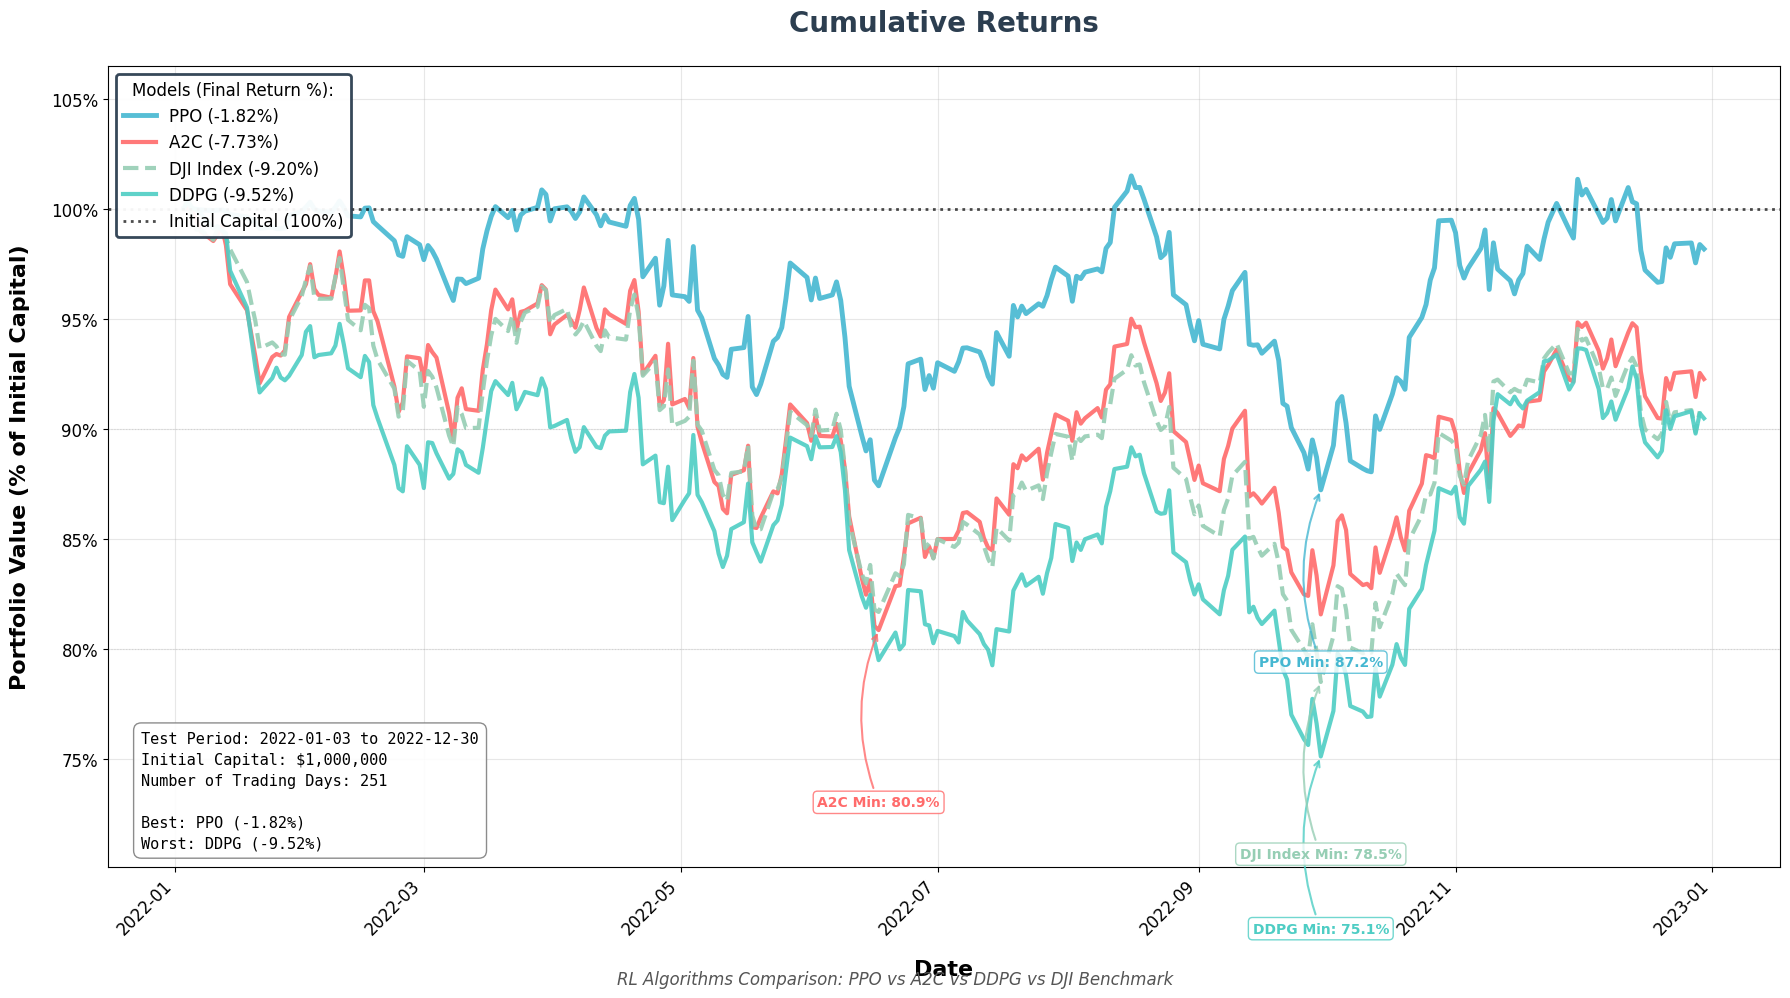

✓ График сохранен: /content/drive/MyDrive/RL/visualizations/cumulative_returns_base.png
  Размер: 18x10 inches
  Разрешение: 300 DPI
✓ Векторная версия сохранена: /content/drive/MyDrive/RL/visualizations/cumulative_returns_base.svg


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import os
%matplotlib inline

# Ячейка: Создание основного графика (только cumulative returns)
fig, ax = plt.subplots(figsize=(18, 10))

# Цветовая схема для моделей
model_colors = {
    'a2c': '#FF6B6B',      # Красный
    'ddpg': '#4ECDC4',     # Бирюзовый
    'ppo': '#45B7D1',      # Голубой
    'dji': '#96CEB4',      # Зеленый
}

model_names_full = {
    'a2c': 'A2C',
    'ddpg': 'DDPG',
    'ppo': 'PPO',
    'dji': 'DJI Index',
}

# Проверяем, какие модели действительно есть в данных
available_models = [col for col in ['ppo', 'a2c', 'ddpg', 'dji'] if col in result.columns]
print(f"Available models in results: {available_models}")

# Убедимся, что индексы в datetime формате
if hasattr(result.index, 'dtype') and result.index.dtype == 'object':
    result.index = pd.to_datetime(result.index)

# Толщина линий (PPO - немного толще как потенциально лучшая модель)
line_widths = {
    'a2c': 3.0,
    'ddpg': 3.0,
    'ppo': 3.5,
    'dji': 3.0
}

# Сортируем модели по итоговой доходности (для порядка в легенде)
final_returns = {}
for model in available_models:
    if len(result[model].dropna()) > 0:
        final_value = result[model].dropna().iloc[-1]
        initial_value = result[model].dropna().iloc[0]
        if initial_value != 0:
            final_returns[model] = (final_value / initial_value - 1) * 100
            print(f"{model_names_full[model]}: Initial={initial_value:.2f}, Final={final_value:.2f}, Return={final_returns[model]:.2f}%")

# Сортируем модели по убыванию доходности для порядка в легенде
if final_returns:
    models_sorted = sorted(final_returns.keys(), key=lambda x: final_returns[x], reverse=True)
else:
    models_sorted = available_models

# Рисуем линии в порядке убывания доходности
for model in models_sorted:
    if model in result.columns:
        data = result[model].dropna()
        if len(data) > 1:  # Нужно как минимум 2 точки для графика
            # Нормализуем к начальному капиталу 1,000,000 для процентного отображения
            initial_value = data.iloc[0]
            normalized_data = data / initial_value * 100

            # Для DJI используем пунктирную линию, для RL моделей - сплошную
            linestyle = '--' if model == 'dji' else '-'

            # Получаем цвет модели
            color = model_colors.get(model, '#000000')  # Черный по умолчанию

            ax.plot(data.index, normalized_data,
                    label=f"{model_names_full.get(model, model)} ({final_returns.get(model, 0):.2f}%)",
                    color=color,
                    linestyle=linestyle,
                    linewidth=line_widths.get(model, 3),
                    alpha=0.9)

# Настройка графика
ax.set_title('Cumulative Returns',
             fontsize=20, fontweight='bold', pad=25, color='#2c3e50')

ax.set_ylabel('Portfolio Value (% of Initial Capital)',
              fontsize=16, fontweight='bold', labelpad=15)

ax.set_xlabel('Date', fontsize=16, fontweight='bold', labelpad=15)

# Форматирование оси Y в процентах
def percent_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Добавляем горизонтальную линию на уровне 100% (начальный капитал)
ax.axhline(y=100, color='black', linestyle=':', linewidth=2.0, alpha=0.7,
           label='Initial Capital (100%)')

# Добавляем фон с горизонтальными уровнями для лучшей читаемости
for level in [80, 90, 100, 110, 120, 130, 140]:
    if level == 100:
        continue  # Уже нарисовали выше
    ax.axhline(y=level, color='gray', linestyle=':', linewidth=0.8, alpha=0.2)

# Легенда
if len(models_sorted) > 0:
    legend = ax.legend(loc='upper left', fontsize=12, frameon=True,
                      framealpha=0.95, edgecolor='#2c3e50',
                      facecolor='white', title='Models (Final Return %):',
                      title_fontsize=12)
    legend.get_frame().set_linewidth(2)

# Сетка
ax.grid(True, alpha=0.3, linestyle='-', which='both')

# Добавляем аннотации для минимумов и максимумов каждой модели
for model in available_models:
    if model in result.columns:
        data = result[model].dropna()
        if len(data) > 1:
            initial_value = data.iloc[0]
            normalized_data = data / initial_value * 100

            # Находим минимум и максимум
            min_idx = normalized_data.idxmin()
            min_value = normalized_data.min()
            max_idx = normalized_data.idxmax()
            max_value = normalized_data.max()

            color = model_colors.get(model, '#000000')

            # Аннотация для минимума
            if min_value < 100:  # Только если минимум ниже начального капитала
                ax.annotate(f'{model_names_full.get(model, model)} Min: {min_value:.1f}%',
                          xy=(min_idx, min_value),
                          xytext=(min_idx, min_value - 8),
                          arrowprops=dict(arrowstyle='->',
                                         color=color,
                                         alpha=0.8,
                                         lw=1.5,
                                         connectionstyle="arc3,rad=-0.2"),
                          fontsize=10,
                          fontweight='bold',
                          color=color,
                          ha='center',
                          bbox=dict(boxstyle="round,pad=0.3",
                                   facecolor="white",
                                   alpha=0.8,
                                   edgecolor=color))

            # Аннотация для максимума (если значительно выше 100%)
            if max_value > 105:  # Только если максимум значительно выше начального капитала
                ax.annotate(f'{model_names_full.get(model, model)} Max: {max_value:.1f}%',
                          xy=(max_idx, max_value),
                          xytext=(max_idx, max_value + 5),
                          arrowprops=dict(arrowstyle='->',
                                         color=color,
                                         alpha=0.8,
                                         lw=1.5,
                                         connectionstyle="arc3,rad=0.2"),
                          fontsize=10,
                          fontweight='bold',
                          color=color,
                          ha='center',
                          bbox=dict(boxstyle="round,pad=0.3",
                                   facecolor="white",
                                   alpha=0.8,
                                   edgecolor=color))

# Добавляем информационный блок
if len(result) > 0:
    start_date = result.index[0].strftime('%Y-%m-%d')
    end_date = result.index[-1].strftime('%Y-%m-%d')

    info_text = f"Test Period: {start_date} to {end_date}\n"
    info_text += f"Initial Capital: $1,000,000\n"
    info_text += f"Number of Trading Days: {len(result)}\n"

    # Добавляем лучшую и худшую модели
    if final_returns:
        best_model = max(final_returns.items(), key=lambda x: x[1])
        worst_model = min(final_returns.items(), key=lambda x: x[1])

        info_text += f"\nBest: {model_names_full.get(best_model[0], best_model[0])} ({best_model[1]:.2f}%)\n"
        info_text += f"Worst: {model_names_full.get(worst_model[0], worst_model[0])} ({worst_model[1]:.2f}%)"

    props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray', pad=0.5)
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', bbox=props, fontfamily='monospace',
            linespacing=1.5)

# Поворот дат на оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Устанавливаем отступы для осей
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)

# Автоматическое масштабирование оси Y с небольшим запасом
if len(result) > 0:
    all_values = []
    for model in available_models:
        if model in result.columns:
            data = result[model].dropna()
            if len(data) > 0:
                initial_value = data.iloc[0]
                normalized = data / initial_value * 100
                all_values.extend(normalized.values)

    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        y_padding = max((y_max - y_min) * 0.1, 5)  # Минимальный запас 5%
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Добавляем подзаголовок с информацией о гиперпараметрах
if 'ppo' in result.columns:
    plt.figtext(0.5, 0.01,
                "RL Algorithms Comparison: PPO vs A2C vs DDPG vs DJI Benchmark",
                ha='center', fontsize=12, style='italic', color='#555555')

plt.tight_layout()
plt.show()

# Сохранение графика
save_dir = "/content/drive/MyDrive/RL/visualizations"
os.makedirs(save_dir, exist_ok=True)

fig.savefig(f'{save_dir}/cumulative_returns_base.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

print(f"✓ График сохранен: {save_dir}/cumulative_returns_base.png")
print(f"  Размер: {fig.get_size_inches()[0]:.0f}x{fig.get_size_inches()[1]:.0f} inches")
print(f"  Разрешение: 300 DPI")

# Также сохраняем в SVG для векторного формата
fig.savefig(f'{save_dir}/cumulative_returns_base.svg',
            format='svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
print(f"✓ Векторная версия сохранена: {save_dir}/cumulative_returns_base.svg")

In [ ]:
all_models = {
    'PPO': perf_stats_ppo,
    'DDPG': perf_stats_ddpg,
    'A2C': perf_stats_a2c,
    'DJI': perf_stats_dji
}
summary_metrics = pd.DataFrame()
key_metrics = [
    'Cumulative returns',
    'Annual return',
    'Annual volatility',
    'Sharpe ratio',
    'Max drawdown'
]
for model_name, model_stats in all_models.items():
    if model_stats is not None:

        if isinstance(model_stats, pd.DataFrame):
            if model_stats.shape[1] == 1:
                model_series = model_stats.iloc[:, 0]
            else:
                model_series = model_stats.iloc[:, 0]
        elif isinstance(model_stats, pd.Series):
            model_series = model_stats
        else:
            print(f"  Пропускаю {model_name} - неподдерживаемый формат")
            continue

        metrics_dict = {}

        for metric in key_metrics:
            if metric in model_series.index:
                metrics_dict[metric] = model_series[metric]
            else:
                found = False
                for idx in model_series.index:
                    if metric.lower() in str(idx).lower():
                        metrics_dict[metric] = model_series[idx]
                        found = True
                        break
                if not found:
                    metrics_dict[metric] = np.nan
                    print(f"  Метрика '{metric}' не найдена в {model_name}")

        summary_metrics[model_name] = pd.Series(metrics_dict)

summary_metrics = summary_metrics.T

print(summary_metrics)

      Cumulative returns  Annual return  Annual volatility  Sharpe ratio  \
PPO            -0.018245      -0.018317           0.173079     -0.020931   
DDPG           -0.095158      -0.095518           0.209353     -0.377110   
A2C            -0.077329      -0.077625           0.214652     -0.270765   
DJI            -0.093968      -0.094324           0.198502     -0.402058   

      Max drawdown  
PPO      -0.140456  
DDPG     -0.251261  
A2C      -0.191688  
DJI      -0.219408  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
summary_metrics.sort_values("Cumulative returns", ascending=False)

Cumulative returns  Annual return  Annual volatility  Sharpe ratio  \
PPO            -0.018245      -0.018317           0.173079     -0.020931   
A2C            -0.077329      -0.077625           0.214652     -0.270765   
DJI            -0.093968      -0.094324           0.198502     -0.402058   
DDPG           -0.095158      -0.095518           0.209353     -0.377110   

      Max drawdown  
PPO      -0.140456  
A2C      -0.191688  
DJI      -0.219408  
DDPG     -0.251261

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Best Model - PPO

- It'll be used for experimentation

 #### Applicability of GRU features?

Compare PPO on GRU vs PPO with technical indicators

In [9]:

df = YahooDownloader(start_date = train_start,
                     end_date = test_end,
                     ticker_list = DOW_30_TICKER).fetch_data()


YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return dateti

Shape of DataFrame:  (92571, 8)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
INDICATORS = ['macd',
              'rsi_30',
              'cci_30',
              'dx_30']
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

techs = fe.preprocess_data(df)
techs = techs.copy()
techs = techs.fillna(0)
techs = techs.replace(np.inf,0)

Successfully added technical indicators


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Successfully added turbulence index


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
stock_dimension = len(techs.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 169


In [12]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": [0.001]*stock_dimension,
    "sell_cost_pct": [0.001]*stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [13]:
train_tech = data_split(techs, train_start, train_end)
trade_tech = data_split(techs, test_start, test_end)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:

#Establish the training environment using StockTradingEnv() class
e_train_gym_tech = StockTradingEnv(df = train_tech, num_stock_shares=[0]*stock_dimension,**env_kwargs)
env_train_tech, _ = e_train_gym_tech.get_sb_env()
print(type(env_train_tech))
agent_tech = DRLAgent(env = env_train_tech)
PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }
model_ppo_tech = agent_tech.get_model("ppo",model_kwargs = PPO_model_kwargs)
trained_ppo_tech = agent_tech.train_model(model=model_ppo_tech,
                             tb_log_name="ppo",total_timesteps=10000)

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
-----------------------------------
| time/              |            |
|    fps             | 90         |
|    iterations      | 1          |
|    time_elapsed    | 22         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 1.3154525  |
|    reward_max      | 6.025044   |
|    reward_mean     | 0.07622416 |
|    reward_min      | -11.234052 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 2           |
|    time_elapsed         | 50          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015821273 |
|    clip_fraction        | 0.209       |
|    clip_range       

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 3           |
|    time_elapsed         | 74          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.012763355 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | 7.68e-05    |
|    learning_rate        | 0.00025     |
|    loss                 | 29.9        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0181     |
|    reward               | -0.613375   |
|    reward_max           | 23.529081   |
|    reward_mean          | 0.121450365 |
|    reward_min           | -40.197903  |
|    std                  | 1           |
|    value_loss           | 47.7        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 4           |
|    time_elapsed         | 96          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.017344132 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | 0.0133      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.8        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0198     |
|    reward               | -1.3893963  |
|    reward_max           | 9.023254    |
|    reward_mean          | 0.11531948  |
|    reward_min           | -11.668443  |
|    std                  | 1           |
|    value_loss           | 55.4        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
e_trade_gym_tech = StockTradingEnv(df = trade_tech, num_stock_shares=[0]*stock_dimension,**env_kwargs)
env_trade_tech, _ = e_trade_gym_tech.get_sb_env()
df_account_value_ppo_tech, df_actions_ppo_tech = DRLAgent.DRL_prediction(
    model=trained_ppo_tech,
    environment = e_trade_gym_tech)
perf_stats_ppo_tech = backtest_stats(account_value=df_account_value_ppo_tech)
perf_stats_ppo_tech = pd.DataFrame(perf_stats_ppo_tech)

hit end!
Annual return         -0.005888
Cumulative returns    -0.005865
Annual volatility      0.189659
Sharpe ratio           0.063386
Calmar ratio          -0.038414
Stability              0.009652
Max drawdown          -0.153278
Omega ratio            1.010993
Sortino ratio          0.088323
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.054971
Daily value at risk   -0.023847
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [29]:
perf_stats_ppo

0
Annual return        0.011218
Cumulative returns   0.011173
Annual volatility    0.166724
Sharpe ratio         0.150182
Calmar ratio         0.062710
Stability            0.077291
Max drawdown        -0.178885
Omega ratio          1.027285
Sortino ratio        0.216170
Skew                      NaN
Kurtosis                  NaN
Tail ratio           0.979809
Daily value at risk -0.020906

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
perf_stats_ppo_tech

0
Annual return       -0.005888
Cumulative returns  -0.005865
Annual volatility    0.189659
Sharpe ratio         0.063386
Calmar ratio        -0.038414
Stability            0.009652
Max drawdown        -0.153278
Omega ratio          1.010993
Sortino ratio        0.088323
Skew                      NaN
Kurtosis                  NaN
Tail ratio           1.054971
Daily value at risk -0.023847

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


from matplotlib import pyplot as plt
_df_0[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Combinations

## In the next section I'll test 6 different approaches using PPO model

- There're 3 different reward functions and 2 NN of policies


### 1. Reward functions
#### 1.1 Custom Environment with Quadratic Utility Reward

In [27]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": [0.001]*stock_dimension,
    "sell_cost_pct": [0.001]*stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": FINAL_FEATURES,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [28]:
state_space

313

In [29]:
# Custom Environment with Quadratic Utility Reward
class CustomStockTradingEnv(StockTradingEnv):
    """
    Функция награды (адаптированная для среды FinRL):
    R_t = (σ_tgt / σ_{t-1}) * [ A_{t-1} * r_t — λ * (A_{t-1} * r_t)^2 ] — bp * p_{t-1} * | (σ_tgt/σ_{t-1})*A_{t-1} — (σ_tgt/σ_{t-2})*A_{t-2} |

    Где:
    - μ: масштабирующий коэффициент (risk aversion или leverage)
    - A_{t-1}: нормализованная позиция на предыдущем шаге
    - σ_tgt: целевая волатильность
    - σ_{t-1}: реализованная волатильность на предыдущем шаге
    - r_t: доходность актива
    - bp: стоимость транзакции (basis points)
    - p_{t-1}: цена актива на предыдущем шаге
    """

    def __init__(self, *args, sigma_target=0.15/252**0.5, lambda_param=0.01, **kwargs):
        super().__init__(*args, **kwargs)
        # Параметры функции награды
        self.sigma_target = sigma_target  # целевая дневная волатильность (15% годовых / √252)
        self.lambda_param = lambda_param  # коэффициент неприятия риска

        # Для отслеживания истории
        self.previous_price = None
        self.previous_total_asset = None
        self.previous_position = None
        self.previous_sigma = None

        # История доходностей для расчета волатильности
        self.returns_history = []
        self.window_size = 20  # окно для расчета волатильности

    def _calculate_reward(self, action):
        # Текущие значения
        current_price = self.state[2]  # цена актива
        current_total_asset = self.state[0]  # общий капитал

        # Инициализация на первом шаге
        if self.previous_price is None:
            self.previous_price = current_price
            self.previous_total_asset = current_total_asset
            self.previous_position = self.state[1]  # количество акций
            self.previous_sigma = 0.01  # начальное значение волатильности
            return 0

        # 1. Рассчитываем доходность актива
        asset_return = (current_price - self.previous_price) / self.previous_price

        # 2. Обновляем историю доходностей и рассчитываем волатильность
        self.returns_history.append(asset_return)
        if len(self.returns_history) > self.window_size:
            self.returns_history.pop(0)

        # Текущая оценка волатильности (σ_{t-1} для следующего шага)
        current_sigma = np.std(self.returns_history) if len(self.returns_history) > 1 else 0.01

        # 3. Рассчитываем нормализованную позицию A_{t-1}
        # В статье: A ∈ [-1, 1] - нормализованная позиция
        # У нас: позиция в акциях, нормализуем к максимально возможной
        max_position = self.previous_total_asset / self.previous_price
        A_t_minus_1 = self.previous_position / max_position if max_position > 0 else 0

        # 4. Рассчитываем r_t (аддитивная доходность на одну единицу позиции)
        # В статье: r_t = p_t - p_{t-1} (для одного контракта)
        # У нас адаптируем: r_t = (p_t - p_{t-1}) / p_{t-1} (доходность)
        r_t = asset_return

        # 5. Основная часть функции награды: квадратичная полезность с волатильностным масштабированием
        scale_factor = self.sigma_target / self.previous_sigma if self.previous_sigma > 0 else 1.0

        # Квадратичная полезность: A_{t-1} * r_t - λ * (A_{t-1} * r_t)^2
        position_return = A_t_minus_1 * r_t
        utility = position_return - self.lambda_param * (position_return ** 2)

        # Масштабируем
        reward_before_cost = scale_factor * utility

        # 6. Транзакционные издержки (адаптировано под нашу среду)
        # В статье: bp * p_{t-1} * | (σ_tgt/σ_{t-1})*A_{t-1} - (σ_tgt/σ_{t-2})*A_{t-2} |
        # У нас упрощаем: стандартные издержки среды

        # Рассчитываем изменение позиции в нормализованном виде
        current_max_position = current_total_asset / current_price if current_price > 0 else 0
        A_t = self.state[1] / current_max_position if current_max_position > 0 else 0

        # Транзакционные издержки как в оригинальной статье
        if hasattr(self, 'previous_scale_factor') and hasattr(self, 'previous_A_t_minus_2'):
            # Если есть данные о двух предыдущих шагах
            cost = self.buy_cost_pct * self.previous_price * abs(
                scale_factor * A_t_minus_1 - self.previous_scale_factor * self.previous_A_t_minus_2
            )
        else:
            # Упрощенный расчет на первых шагах
            trades = action - self.previous_position
            cost = np.abs(trades) * current_price * self.buy_cost_pct

        # 7. Итоговая награда
        step_reward = reward_before_cost * self.previous_total_asset - cost

        # 8. Сохраняем значения для следующего шага
        self.previous_price = current_price
        self.previous_total_asset = current_total_asset
        self.previous_position = self.state[1]

        # Для расчета издержек на следующем шаге
        self.previous_A_t_minus_2 = A_t_minus_1
        self.previous_scale_factor = scale_factor
        self.previous_sigma = current_sigma

        return step_reward * self.reward_scaling

    def reset(self, seed=None, options=None):
        """
        Переопределяем reset с поддержкой seed для Stable-Baselines3
        """
        # Вызываем родительский reset с seed, если он поддерживается
        try:
            state = super().reset(seed=seed)
        except TypeError:
            # Если родительский класс не принимает seed
            state = super().reset()

        # Сбрасываем наши дополнительные переменные
        self.previous_price = None
        self.previous_total_asset = None
        self.previous_position = None
        self.previous_sigma = None
        self.previous_scale_factor = None
        self.previous_A_t_minus_2 = None
        self.returns_history = []

        return state



# Env kwargs
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(FINAL_FEATURES)*stock_dimension



#### 1.2 Custom Environment
- "Deep Reinforcement Learning for Trading" Zihao Zhang, Stefan Zohren, and Stephen Roberts

In [30]:
class ZhangStockTradingEnv(StockTradingEnv):
    """
    Среда с функцией вознаграждения из статьи:
    Zihao Zhang, Stefan Zohren, Stephen Roberts.
    "Deep Reinforcement Learning for Trading" (2019) [citation:2][citation:6].

    Функция награды (адаптированная для среды FinRL):
    R_t = μ * [ A_{t-1} * (σ_tgt / σ_{t-1}) * r_t — bp * p_{t-1} * | (σ_tgt/σ_{t-1}) * A_{t-1} — (σ_tgt/σ_{t-2}) * A_{t-2} | ]

    Где:
    - μ: масштабирующий коэффициент (risk aversion или leverage)
    - A_{t-1}: нормализованная позиция на предыдущем шаге
    - σ_tgt: целевая волатильность
    - σ_{t-1}: реализованная волатильность на предыдущем шаге
    - r_t: доходность актива
    - bp: стоимость транзакции (basis points)
    - p_{t-1}: цена актива на предыдущем шаге
    """
    def __init__(self, *args, sigma_target=0.15/252**0.5, mu=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        # Параметры функции награды из статьи Zhang et al.
        self.sigma_target = sigma_target  # целевая дневная волатильность
        self.mu = mu  # коэффициент масштабирования (μ в формуле)

        # Для отслеживания истории (аналогично вашему классу)
        self.previous_price = None
        self.previous_total_asset = None
        self.previous_position = None
        self.previous_sigma = None
        self.previous_A_t_minus_2 = None
        self.previous_scale_factor = None

        # История доходностей для расчета волатильности
        self.returns_history = []
        self.window_size = 20  # окно для расчета волатильности

    def _calculate_reward(self, action):
        """
        Вычисляет награду по формуле из статьи Zhang et al.
        R_t = μ * [ A_{t-1} * (σ_tgt / σ_{t-1}) * r_t — bp * p_{t-1} * | (σ_tgt/σ_{t-1}) * A_{t-1} — (σ_tgt/σ_{t-2}) * A_{t-2} | ]
        """
        # Текущие значения
        current_price = self.state[2]  # цена актива
        current_total_asset = self.state[0]  # общий капитал

        # Инициализация на первом шаге
        if self.previous_price is None:
            self.previous_price = current_price
            self.previous_total_asset = current_total_asset
            self.previous_position = self.state[1]  # количество акций
            self.previous_sigma = 0.01  # начальное значение волатильности
            return 0

        # 1. Рассчитываем доходность актива
        # ВАЖНО: В оригинальной статье r_t может быть определено как p_t - p_{t-1} (абсолютное изменение)
        # или как (p_t - p_{t-1})/p_{t-1} (относительное). Мы используем относительное для согласованности.
        asset_return = (current_price - self.previous_price) / self.previous_price

        # 2. Обновляем историю доходностей и рассчитываем волатильность
        self.returns_history.append(asset_return)
        if len(self.returns_history) > self.window_size:
            self.returns_history.pop(0)

        # Текущая оценка волатильности (σ_{t-1} для следующего шага)
        current_sigma = np.std(self.returns_history) if len(self.returns_history) > 1 else 0.01

        # 3. Рассчитываем нормализованную позицию A_{t-1}
        # В статье: A ∈ [-1, 1] - нормализованная позиция (long/short)
        max_position = self.previous_total_asset / self.previous_price if self.previous_price > 0 else 0
        A_t_minus_1 = self.previous_position / max_position if max_position > 0 else 0

        # Ограничиваем диапазон позиции в соответствии со статьей
        A_t_minus_1 = np.clip(A_t_minus_1, -1.0, 1.0)

        # 4. Коэффициент масштабирования волатильности
        scale_factor = self.sigma_target / self.previous_sigma if self.previous_sigma > 0 else 1.0

        # 5. ОСНОВНАЯ ЧАСТЬ ФОРМУЛЫ
        # В статье Zhang et al.: A_{t-1} * (σ_tgt/σ_{t-1}) * r_t
        # НЕТ квадратичного члена λ * (A_{t-1} * r_t)^2
        position_scaled_return = A_t_minus_1 * scale_factor * asset_return

        # 6. Транзакционные издержки
        # bp * p_{t-1} * | (σ_tgt/σ_{t-1})*A_{t-1} - (σ_tgt/σ_{t-2})*A_{t-2} |
        transaction_cost = 0.0
        if hasattr(self, 'previous_scale_factor') and hasattr(self, 'previous_A_t_minus_2'):
            # Если есть данные о двух предыдущих шагах
            term1 = scale_factor * A_t_minus_1
            term2 = self.previous_scale_factor * self.previous_A_t_minus_2
            position_change = abs(term1 - term2)

            # bp преобразуется в процент от стоимости транзакции
            # В статье bp - basis points, у нас buy_cost_pct - процент
            transaction_cost = self.buy_cost_pct * self.previous_price * position_change
        else:
            # Упрощенный расчет на первых шагах
            trades = action - self.previous_position
            transaction_cost = np.abs(trades) * current_price * self.buy_cost_pct

        # 7. Итоговая награда по формуле статьи
        # R_t = μ * [position_scaled_return - transaction_cost]
        reward_before_scaling = position_scaled_return - transaction_cost
        step_reward = self.mu * reward_before_scaling * self.previous_total_asset

        # 8. Сохраняем значения для следующего шага
        self.previous_price = current_price
        self.previous_total_asset = current_total_asset
        self.previous_position = self.state[1]

        # Для расчета издержек на следующем шаге
        self.previous_A_t_minus_2 = A_t_minus_1
        self.previous_scale_factor = scale_factor
        self.previous_sigma = current_sigma

        return step_reward * self.reward_scaling

    def reset(self, seed=None, options=None):
        """
        Переопределяем reset с поддержкой seed для Stable-Baselines3.
        """
        try:
            state = super().reset(seed=seed)
        except TypeError:
            state = super().reset()

        # Сбрасываем наши дополнительные переменные
        self.previous_price = None
        self.previous_total_asset = None
        self.previous_position = None
        self.previous_sigma = None
        self.previous_scale_factor = None
        self.previous_A_t_minus_2 = None
        self.returns_history = []

        return state

#### 1.3 FinRL Environment

In [ ]:
# Defined Before
# e_train_gym = StockTradingEnv(df = train, **env_kwargs)
# env_train, _ = e_train_gym.get_sb_env()
# e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [36]:
sigma_target = 0.15 / (252 ** 0.5)  # Целевая волатильность (15% годовых)
lambda_param = 0.01  # Коэффициент неприятия риска для вашей функции
mu_param = 1.0  # Коэффициент масштабирования для функции Zhang
finrl_policy_kwargs = None

### Custom Policy

In [34]:
import torch
custom_policy_kwargs = dict(
    net_arch=dict(
        pi=[256, 128],  # Сеть актора: 313 -> 256 -> 128 -> action
        vf=[256, 128]   # Сеть критика: 313 -> 256 -> 128 -> 1
    ),
    activation_fn=torch.nn.ReLU,
    ortho_init=False
)

### Backtest 6 different approaches
- PPO, FinRL env, FinRL policy
- PPO, FinRL env, Custom policy
- PPO, Zhang env, FinRL policy
- PPO, Zhang env, Custom policy
- PPO, Custom env, FinRL policy
- PPO, Custom env, Custom policy

In [38]:
# ==================== СОЗДАНИЕ ВСЕХ 6 КОНФИГУРАЦИЙ ====================

# 1. PPO, FinRL env, FinRL policy
e_train_finrl_finrl = StockTradingEnv(df=train, num_stock_shares=[0]*stock_dimension, **env_kwargs)
env_train_finrl_finrl, _ = e_train_finrl_finrl.get_sb_env()
e_trade_finrl_finrl = StockTradingEnv(df=trade, num_stock_shares=[0]*stock_dimension,
                                      turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)

# 2. PPO, FinRL env, Custom policy
e_train_finrl_custom = StockTradingEnv(df=train, num_stock_shares=[0]*stock_dimension, **env_kwargs)
env_train_finrl_custom, _ = e_train_finrl_custom.get_sb_env()
e_trade_finrl_custom = StockTradingEnv(df=trade, num_stock_shares=[0]*stock_dimension,
                                      turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)

# 3. PPO, Zhang env, FinRL policy
e_train_zhang_finrl = ZhangStockTradingEnv(df=train, num_stock_shares=[0]*stock_dimension,
                                          sigma_target=sigma_target, mu=mu_param, **env_kwargs)
env_train_zhang_finrl, _ = e_train_zhang_finrl.get_sb_env()
e_trade_zhang_finrl = ZhangStockTradingEnv(df=trade, num_stock_shares=[0]*stock_dimension,
                                          sigma_target=sigma_target, mu=mu_param,
                                          turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)

# 4. PPO, Zhang env, Custom policy
e_train_zhang_custom = ZhangStockTradingEnv(df=train, num_stock_shares=[0]*stock_dimension,
                                           sigma_target=sigma_target, mu=mu_param, **env_kwargs)
env_train_zhang_custom, _ = e_train_zhang_custom.get_sb_env()
e_trade_zhang_custom = ZhangStockTradingEnv(df=trade, num_stock_shares=[0]*stock_dimension,
                                           sigma_target=sigma_target, mu=mu_param,
                                           turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)

# 5. PPO, Custom env, FinRL policy
e_train_custom_finrl = CustomStockTradingEnv(df=train, num_stock_shares=[0]*stock_dimension,
                                            sigma_target=sigma_target, lambda_param=lambda_param, **env_kwargs)
env_train_custom_finrl, _ = e_train_custom_finrl.get_sb_env()
e_trade_custom_finrl = CustomStockTradingEnv(df=trade, num_stock_shares=[0]*stock_dimension,
                                            sigma_target=sigma_target, lambda_param=lambda_param,
                                            turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)

# 6. PPO, Custom env, Custom policy
e_train_custom_custom = CustomStockTradingEnv(df=train, num_stock_shares=[0]*stock_dimension,
                                             sigma_target=sigma_target, lambda_param=lambda_param, **env_kwargs)
env_train_custom_custom, _ = e_train_custom_custom.get_sb_env()
e_trade_custom_custom = CustomStockTradingEnv(df=trade, num_stock_shares=[0]*stock_dimension,
                                             sigma_target=sigma_target, lambda_param=lambda_param,
                                             turbulence_threshold=70, risk_indicator_col='turbulence', **env_kwargs)

# Словарь для удобного доступа ко всем конфигурациям
train_environments = {
    'finrl_finrl': (env_train_finrl_finrl, e_train_finrl_finrl, finrl_policy_kwargs),
    'finrl_custom': (env_train_finrl_custom, e_train_finrl_custom, custom_policy_kwargs),
    'zhang_finrl': (env_train_zhang_finrl, e_train_zhang_finrl, finrl_policy_kwargs),
    'zhang_custom': (env_train_zhang_custom, e_train_zhang_custom, custom_policy_kwargs),
    'custom_finrl': (env_train_custom_finrl, e_train_custom_finrl, finrl_policy_kwargs),
    'custom_custom': (env_train_custom_custom, e_train_custom_custom, custom_policy_kwargs)
}

trade_environments = {
    'finrl_finrl': e_trade_finrl_finrl,
    'finrl_custom': e_trade_finrl_custom,
    'zhang_finrl': e_trade_zhang_finrl,
    'zhang_custom': e_trade_zhang_custom,
    'custom_finrl': e_trade_custom_finrl,
    'custom_custom': e_trade_custom_custom
}


In [39]:
# Словарь для хранения обученных моделей
trained_models = {}
training_results = {}


for config_name, (env_train, e_train, policy_kwargs) in train_environments.items():
    print(f"\n📊 Обучение модели: {config_name}")
    print(f"   Среда: {config_name.split('_')[0]}, Политика: {config_name.split('_')[1]}")

    try:
        # Создание агента DRL
        agent = DRLAgent(env=env_train)

        # Получение модели PPO с соответствующими параметрами политики
        if policy_kwargs is not None:
            print(f"   Используется custom policy: {policy_kwargs['net_arch']}")
            model = agent.get_model("ppo",
                                   model_kwargs=PPO_model_kwargs,
                                   policy_kwargs=policy_kwargs,
                                   verbose=1)
        else:
            print("   Используется стандартная политика FinRL")
            model = agent.get_model("ppo",
                                   model_kwargs=PPO_model_kwargs,
                                   verbose=1)

        # Обучение модели
        print(f"   Обучение на {10000} шагах...")
        trained_model = agent.train_model(model=model,
                                        tb_log_name=f"ppo_{config_name}",
                                        total_timesteps=10000)

        # Сохранение обученной модели
        trained_models[config_name] = trained_model
        print(f"   ✅ Модель {config_name} успешно обучена")

    except Exception as e:
        print(f"   ❌ Ошибка при обучении {config_name}: {str(e)}")
        trained_models[config_name] = None

print("\n" + "=" * 60)
print(f"Обучение завершено. Успешно обучено моделей: "
      f"{sum(1 for m in trained_models.values() if m is not None)} из 6")


📊 Обучение модели: finrl_finrl
   Среда: finrl, Политика: finrl
   Используется стандартная политика FinRL
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 10000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/              |             |
|    fps             | 107         |
|    iterations      | 1           |
|    time_elapsed    | 18          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 2.3621893   |
|    reward_max      | 7.4119687   |
|    reward_mean     | 0.096684285 |
|    reward_min      | -14.723205  |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012525504 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.0177      |
|    learning_rate        | 0.00025     |
|    loss 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3           |
|    time_elapsed         | 64          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.016023107 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.0016     |
|    learning_rate        | 0.00025     |
|    loss                 | 24.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0153     |
|    reward               | -0.5323888  |
|    reward_max           | 21.585304   |
|    reward_mean          | 0.089870095 |
|    reward_min           | -24.275345  |
|    std                  | 1           |
|    value_loss           | 63.7        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 4          |
|    time_elapsed         | 89         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01748008 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.2      |
|    explained_variance   | -0.00282   |
|    learning_rate        | 0.00025    |
|    loss                 | 18.1       |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.0156    |
|    reward               | -3.0767891 |
|    reward_max           | 9.112467   |
|    reward_mean          | 0.13047414 |
|    reward_min           | -16.005589 |
|    std                  | 1          |
|    value_loss           | 50.8       |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ✅ Модель finrl_finrl успешно обучена

📊 Обучение модели: finrl_custom
   Среда: finrl, Политика: custom
   Используется custom policy: {'pi': [256, 128], 'vf': [256, 128]}
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 10000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 88         |
|    iterations      | 1          |
|    time_elapsed    | 23         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 2.5243623  |
|    reward_max      | 7.009811   |
|    reward_mean     | 0.10909389 |
|    reward_min      | -14.596896 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 94         |
|    iterations           | 2          |
|    time_elapsed         | 43         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 688988.06  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -3.07      |
|    learning_rate        | 0.00025    |
|    loss                 | 254    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 3          |
|    time_elapsed         | 63         |
|    total_timesteps      | 6144       |
| train/                  |            |
|    approx_kl            | 2761549.8  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -4.98      |
|    learning_rate        | 0.00025    |
|    loss                 | 824        |
|    n_updates            | 20         |
|    policy_gradient_loss | 0.141      |
|    reward               | -1.2687486 |
|    reward_max           | 38.455338  |
|    reward_mean          | 0.25019643 |
|    reward_min           | -64.34948  |
|    std                  | 1          |
|    value_loss           | 4.89e+03   |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 4          |
|    time_elapsed         | 83         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 4074632.8  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | 0.215      |
|    learning_rate        | 0.00025    |
|    loss                 | 53.3       |
|    n_updates            | 30         |
|    policy_gradient_loss | 0.248      |
|    reward               | -2.9301937 |
|    reward_max           | 7.3805437  |
|    reward_mean          | 0.10245173 |
|    reward_min           | -14.110114 |
|    std                  | 1          |
|    value_loss           | 1.71e+03   |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ✅ Модель finrl_custom успешно обучена

📊 Обучение модели: zhang_finrl
   Среда: zhang, Политика: finrl
   Используется стандартная политика FinRL
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 10000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 100        |
|    iterations      | 1          |
|    time_elapsed    | 20         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 1.2632954  |
|    reward_max      | 7.0056515  |
|    reward_mean     | 0.08752788 |
|    reward_min      | -12.699033 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 2           |
|    time_elapsed         | 41          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012906758 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.0136      |
|    learning_rate        | 0.00025     |
|    loss             

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 3           |
|    time_elapsed         | 67          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.010286167 |
|    clip_fraction        | 0.0959      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.015      |
|    learning_rate        | 0.00025     |
|    loss                 | 28.7        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.016      |
|    reward               | -0.58717734 |
|    reward_max           | 25.5613     |
|    reward_mean          | 0.12283893  |
|    reward_min           | -32.31907   |
|    std                  | 1           |
|    value_loss           | 52          |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 4           |
|    time_elapsed         | 92          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012279229 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.0287     |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0152     |
|    reward               | 0.47077632  |
|    reward_max           | 8.757118    |
|    reward_mean          | 0.103806995 |
|    reward_min           | -14.697415  |
|    std                  | 1           |
|    value_loss           | 49.2        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ✅ Модель zhang_finrl успешно обучена

📊 Обучение модели: zhang_custom
   Среда: zhang, Политика: custom
   Используется custom policy: {'pi': [256, 128], 'vf': [256, 128]}
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 10000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 95         |
|    iterations      | 1          |
|    time_elapsed    | 21         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.24570139 |
|    reward_max      | 8.946034   |
|    reward_mean     | 0.09212699 |
|    reward_min      | -13.714279 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 78         |
|    iterations           | 2          |
|    time_elapsed         | 52         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 1056591.5  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -2.05      |
|    learning_rate        | 0.00025    |
|    loss                 | 876    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 3           |
|    time_elapsed         | 72          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 3917239.5   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.0673     |
|    learning_rate        | 0.00025     |
|    loss                 | 330         |
|    n_updates            | 20          |
|    policy_gradient_loss | 0.241       |
|    reward               | -0.76958644 |
|    reward_max           | 45.665104   |
|    reward_mean          | 0.24726914  |
|    reward_min           | -48.376022  |
|    std                  | 1           |
|    value_loss           | 1.55e+03    |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 77         |
|    iterations           | 4          |
|    time_elapsed         | 106        |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 897989.75  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | 0.0798     |
|    learning_rate        | 0.00025    |
|    loss                 | 779        |
|    n_updates            | 30         |
|    policy_gradient_loss | 0.184      |
|    reward               | 0.65155256 |
|    reward_max           | 16.436367  |
|    reward_mean          | 0.15747222 |
|    reward_min           | -19.25904  |
|    std                  | 1          |
|    value_loss           | 4.38e+03   |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ✅ Модель zhang_custom успешно обучена

📊 Обучение модели: custom_finrl
   Среда: custom, Политика: finrl
   Используется стандартная политика FinRL
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 10000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 72         |
|    iterations      | 1          |
|    time_elapsed    | 28         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 2.4229314  |
|    reward_max      | 6.1802692  |
|    reward_mean     | 0.0783403  |
|    reward_min      | -11.497374 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 82          |
|    iterations           | 2           |
|    time_elapsed         | 49          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015289236 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.0151      |
|    learning_rate        | 0.00025     |
|    loss             

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 3           |
|    time_elapsed         | 68          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.010093011 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.00236     |
|    learning_rate        | 0.00025     |
|    loss                 | 27.4        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0154     |
|    reward               | -0.4868304  |
|    reward_max           | 23.101751   |
|    reward_mean          | 0.14003727  |
|    reward_min           | -35.51765   |
|    std                  | 1           |
|    value_loss           | 47.3        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 4           |
|    time_elapsed         | 103         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012707846 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.00833     |
|    learning_rate        | 0.00025     |
|    loss                 | 23.4        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0158     |
|    reward               | -1.7818727  |
|    reward_max           | 7.189409    |
|    reward_mean          | 0.09592462  |
|    reward_min           | -13.213917  |
|    std                  | 1           |
|    value_loss           | 40.9        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ✅ Модель custom_finrl успешно обучена

📊 Обучение модели: custom_custom
   Среда: custom, Политика: custom
   Используется custom policy: {'pi': [256, 128], 'vf': [256, 128]}
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 10000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 63         |
|    iterations      | 1          |
|    time_elapsed    | 32         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 1.8953006  |
|    reward_max      | 8.816434   |
|    reward_mean     | 0.13187541 |
|    reward_min      | -17.363203 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 78         |
|    iterations           | 2          |
|    time_elapsed         | 51         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 1375813.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -0.383     |
|    learning_rate        | 0.00025    |
|    loss                 | 888    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 77          |
|    iterations           | 3           |
|    time_elapsed         | 78          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 2238776.8   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.459      |
|    learning_rate        | 0.00025     |
|    loss                 | 69          |
|    n_updates            | 20          |
|    policy_gradient_loss | 0.126       |
|    reward               | -0.83391213 |
|    reward_max           | 29.246336   |
|    reward_mean          | 0.20407106  |
|    reward_min           | -36.827187  |
|    std                  | 1           |
|    value_loss           | 4.2e+03     |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 4           |
|    time_elapsed         | 103         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 8636086.0   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -1.49       |
|    learning_rate        | 0.00025     |
|    loss                 | 276         |
|    n_updates            | 30          |
|    policy_gradient_loss | 0.138       |
|    reward               | -1.2324663  |
|    reward_max           | 6.0449467   |
|    reward_mean          | 0.0699409   |
|    reward_min           | -11.0199375 |
|    std                  | 1           |
|    value_loss           | 1.61e+03    |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   ✅ Модель custom_custom успешно обучена

Обучение завершено. Успешно обучено моделей: 6 из 6


In [40]:
# Словари для хранения результатов тестирования
df_account_values = {}
df_actions = {}
perf_stats = {}

print("🧪 Начало тестирования моделей на торговых данных")
print("=" * 60)

for config_name in trained_models.keys():
    if trained_models[config_name] is None:
        print(f"\n⚠️  Пропуск {config_name} (модель не обучена)")
        continue

    print(f"\n📈 Тестирование модели: {config_name}")

    try:
        # Получение торговой среды для данной конфигурации
        e_trade = trade_environments[config_name]

        # Прогнозирование на торговых данных
        df_account_value, df_action = DRLAgent.DRL_prediction(
            model=trained_models[config_name],
            environment=e_trade
        )

        # Сохранение результатов
        df_account_values[config_name] = df_account_value
        df_actions[config_name] = df_action

        # Расчет метрик
        stats = backtest_stats(account_value=df_account_value)
        perf_stats[config_name] = pd.DataFrame(stats)

        # Краткая статистика
        initial_val = df_account_value.iloc[0, 1]
        final_val = df_account_value.iloc[-1, 1]
        returns_pct = ((final_val / initial_val) - 1) * 100

        print(f"   Начальный капитал: ${initial_val:,.2f}")
        print(f"   Финальный капитал: ${final_val:,.2f}")
        print(f"   Доходность: {returns_pct:.2f}%")
        print(f"   Sharpe Ratio: {stats.get('Sharpe ratio', 'N/A')}")

    except Exception as e:
        print(f"   ❌ Ошибка при тестировании {config_name}: {str(e)}")
        df_account_values[config_name] = None
        perf_stats[config_name] = None

print("\n" + "=" * 60)
print("Тестирование завершено")

🧪 Начало тестирования моделей на торговых данных

📈 Тестирование модели: finrl_finrl
hit end!
Annual return         -0.016835
Cumulative returns    -0.016769
Annual volatility      0.044132
Sharpe ratio          -0.364346
Calmar ratio          -0.331535
Stability              0.305880
Max drawdown          -0.050779
Omega ratio            0.912367
Sortino ratio         -0.603165
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.786706
Daily value at risk   -0.005624
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $983,231.29
   Доходность: -1.68%
   Sharpe Ratio: -0.3643461229417654

📈 Тестирование модели: finrl_custom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!
Annual return         -0.139092
Cumulative returns    -0.138580
Annual volatility      0.174774
Sharpe ratio          -0.772841
Calmar ratio          -0.596054
Stability              0.715531
Max drawdown          -0.233354
Omega ratio            0.871473
Sortino ratio         -1.036215
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.893084
Daily value at risk   -0.022555
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $861,420.29
   Доходность: -13.86%
   Sharpe Ratio: -0.7728412425127509

📈 Тестирование модели: zhang_finrl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!
Annual return         -0.039501
Cumulative returns    -0.039347
Annual volatility      0.060501
Sharpe ratio          -0.638712
Calmar ratio          -0.525160
Stability              0.629406
Max drawdown          -0.075217
Omega ratio            0.858452
Sortino ratio         -0.977466
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.886197
Daily value at risk   -0.007776
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $960,652.73
   Доходность: -3.93%
   Sharpe Ratio: -0.6387124875006823

📈 Тестирование модели: zhang_custom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!
Annual return         -0.159403
Cumulative returns    -0.158823
Annual volatility      0.155871
Sharpe ratio          -1.040214
Calmar ratio          -0.758136
Stability              0.838405
Max drawdown          -0.210256
Omega ratio            0.820106
Sortino ratio         -1.374142
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.969290
Daily value at risk   -0.020281
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $841,176.65
   Доходность: -15.88%
   Sharpe Ratio: -1.0402139392446021

📈 Тестирование модели: custom_finrl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!
Annual return         -0.051166
Cumulative returns    -0.050968
Annual volatility      0.054638
Sharpe ratio          -0.937792
Calmar ratio          -0.832060
Stability              0.771505
Max drawdown          -0.061493
Omega ratio            0.806194
Sortino ratio         -1.300226
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.982704
Daily value at risk   -0.007087
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $949,031.80
   Доходность: -5.10%
   Sharpe Ratio: -0.9377916985333675

📈 Тестирование модели: custom_custom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


hit end!
Annual return         -0.152866
Cumulative returns    -0.152308
Annual volatility      0.148432
Sharpe ratio          -1.047714
Calmar ratio          -0.828180
Stability              0.699589
Max drawdown          -0.184580
Omega ratio            0.827769
Sortino ratio         -1.407888
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.007124
Daily value at risk   -0.019318
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $847,692.05
   Доходность: -15.23%
   Sharpe Ratio: -1.0477140978741044

Тестирование завершено


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Run Ensemble from 2022 to 2023
- "Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy" (ICAIF, 2020)

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
from pathlib import Path
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# 1. Создаем директории для результатов ансамбля
BASE_DIR = "/content/drive/MyDrive/RL"
ENSEMBLE_DIR = f"{BASE_DIR}/ensemble_results"

# Создаем поддиректории для ансамбля
ensemble_dirs = [
    f"{ENSEMBLE_DIR}/trained_models",
    f"{ENSEMBLE_DIR}/validation_results",
    f"{ENSEMBLE_DIR}/trading_results",
    f"{ENSEMBLE_DIR}/logs",
    f"{ENSEMBLE_DIR}/plots"
]

for dir_path in ensemble_dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Создана директория: {dir_path}")

print(f"\nВсе директории ансамбля созданы в: {ENSEMBLE_DIR}")

# 2. Создаем функцию для обновления config.RESULTS_DIR
# FinRL использует config.RESULTS_DIR для сохранения результатов
config.RESULTS_DIR = ENSEMBLE_DIR
print(f"config.RESULTS_DIR установлен в: {config.RESULTS_DIR}")

Создана директория: /content/drive/MyDrive/RL/ensemble_results/trained_models
Создана директория: /content/drive/MyDrive/RL/ensemble_results/validation_results
Создана директория: /content/drive/MyDrive/RL/ensemble_results/trading_results
Создана директория: /content/drive/MyDrive/RL/ensemble_results/logs
Создана директория: /content/drive/MyDrive/RL/ensemble_results/plots

Все директории ансамбля созданы в: /content/drive/MyDrive/RL/ensemble_results
config.RESULTS_DIR установлен в: /content/drive/MyDrive/RL/ensemble_results


In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent da

Shape of DataFrame:  (93702, 8)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Simple Preprocessing

In [ ]:
INDICATORS = ['macd',
              'rsi_30',
              'cci_30',
              'dx_30']
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Successfully added turbulence index


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Design Environment

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 169


In [ ]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)


In [ ]:

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                 'sac' : 10_000,
                 'td3' : 10_000
                 }

In [ ]:
import os

# Создаем директорию results в текущей рабочей директории
os.makedirs("results", exist_ok=True)
print(f"Создана директория: {os.path.abspath('results')}")

# Также убедимся, что config.RESULTS_DIR существует
os.makedirs(config.RESULTS_DIR, exist_ok=True)
print(f"config.RESULTS_DIR: {config.RESULTS_DIR}")

Создана директория: /content/results
config.RESULTS_DIR: /content/drive/MyDrive/RL/ensemble_results


In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  200.5353839414716
======Model training from:  2010-01-01 to  2021-10-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_3


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 106         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -39.9       |
|    explained_variance | -0.0289     |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -41.1       |
|    reward             | -0.08661266 |
|    reward_max         | 2.1307926   |
|    reward_mean        | 0.78981966  |
|    reward_min         | -0.08661266 |
|    std                | 1.01        |
|    value_loss         | 1.18        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 91         |
|    iterations         | 200        |
|    time_elapsed       | 10         |
|    total_timesteps    | 1000       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 94          |
|    iterations         | 700         |
|    time_elapsed       | 37          |
|    total_timesteps    | 3500        |
| train/                |             |
|    entropy_loss       | -40         |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 699         |
|    policy_loss        | -44.3       |
|    reward             | 0.49462107  |
|    reward_max         | 0.9641929   |
|    reward_mean        | 0.42281708  |
|    reward_min         | -0.25708675 |
|    std                | 1.01        |
|    value_loss         | 1.44        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 90          |
|    iterations         | 800         |
|    time_elapsed       | 44          |
|    total_timesteps    | 4000        |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 91         |
|    iterations         | 1300       |
|    time_elapsed       | 70         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | -0.059     |
|    learning_rate      | 0.0007     |
|    n_updates          | 1299       |
|    policy_loss        | -11.4      |
|    reward             | -0.7900341 |
|    reward_max         | 1.123734   |
|    reward_mean        | 0.11049951 |
|    reward_min         | -0.8484444 |
|    std                | 1.02       |
|    value_loss         | 0.462      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 91         |
|    iterations         | 1400       |
|    time_elapsed       | 76         |
|    total_timesteps    | 7000       |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 92         |
|    iterations         | 1900       |
|    time_elapsed       | 102        |
|    total_timesteps    | 9500       |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | -0.125     |
|    learning_rate      | 0.0007     |
|    n_updates          | 1899       |
|    policy_loss        | 60.6       |
|    reward             | 1.0778611  |
|    reward_max         | 1.0778611  |
|    reward_mean        | -0.4504602 |
|    reward_min         | -2.5192385 |
|    std                | 1.02       |
|    value_loss         | 3.4        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 92         |
|    iterations         | 2000       |
|    time_elapsed       | 108        |
|    total_timesteps    | 10000      |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

------------------------------------
| time/              |             |
|    fps             | 107         |
|    iterations      | 1           |
|    time_elapsed    | 19          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.3167628   |
|    reward_max      | 6.0438967   |
|    reward_mean     | 0.064109184 |
|    reward_min      | -10.383255  |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014716295 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.7       |
|    explained_variance   | 0.00546     |
|    learning_rate        | 0.00025     |
|    loss 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 3           |
|    time_elapsed         | 63          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.014375253 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.0101     |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0178     |
|    reward               | -0.23902254 |
|    reward_max           | 29.156445   |
|    reward_mean          | 0.1522349   |
|    reward_min           | -39.587666  |
|    std                  | 1           |
|    value_loss           | 38.7        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 4          |
|    time_elapsed         | 84         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01432147 |
|    clip_fraction        | 0.149      |
|    clip_range           | 0.2        |
|    entropy_loss         | -39.8      |
|    explained_variance   | -0.00122   |
|    learning_rate        | 0.00025    |
|    loss                 | 28.5       |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.021     |
|    reward               | 2.9563208  |
|    reward_max           | 12.396784  |
|    reward_mean          | 0.09032658 |
|    reward_min           | -12.72362  |
|    std                  | 1          |
|    value_loss           | 70.8       |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


======ppo Validation from:  2021-10-04 to  2022-01-03


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ppo Sharpe Ratio:  0.034855924705237414
======Best Model Retraining from:  2010-01-01 to  2022-01-03
======Trading from:  2022-01-03 to  2022-04-04


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


turbulence_threshold:  200.5353839414716
======Model training from:  2010-01-01 to  2022-01-03
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_189_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

---------------------------------------
| time/                 |             |
|    fps                | 97          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -39.8       |
|    explained_variance | -0.241      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -79.6       |
|    reward             | 0.21171902  |
|    reward_max         | 3.2492332   |
|    reward_mean        | 0.98259646  |
|    reward_min         | -0.53572893 |
|    std                | 1           |
|    value_loss         | 5.72        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 101        |
|    iterations         | 200        |
|    time_elapsed       | 9          |
|    total_timesteps    | 1000       |
| trai

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 92         |
|    iterations         | 800        |
|    time_elapsed       | 43         |
|    total_timesteps    | 4000       |
| train/                |            |
|    entropy_loss       | -39.9      |
|    explained_variance | 5.96e-08   |
|    learning_rate      | 0.0007     |
|    n_updates          | 799        |
|    policy_loss        | 57.6       |
|    reward             | -0.2158684 |
|    reward_max         | 0.91683227 |
|    reward_mean        | 0.2804552  |
|    reward_min         | -0.9048603 |
|    std                | 1.01       |
|    value_loss         | 2.59       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 93         |
|    iterations         | 900        |
|    time_elapsed       | 48         |
|    total_timesteps    | 4500       |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 91         |
|    iterations         | 1400       |
|    time_elapsed       | 76         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 1399       |
|    policy_loss        | 86.1       |
|    reward             | -0.5537782 |
|    reward_max         | 2.2963796  |
|    reward_mean        | 0.48764265 |
|    reward_min         | -0.6216718 |
|    std                | 1.01       |
|    value_loss         | 7.74       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 90         |
|    iterations         | 1500       |
|    time_elapsed       | 82         |
|    total_timesteps    | 7500       |
| train/                |

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 91         |
|    iterations         | 2000       |
|    time_elapsed       | 109        |
|    total_timesteps    | 10000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | -0.00631   |
|    learning_rate      | 0.0007     |
|    n_updates          | 1999       |
|    policy_loss        | 95.6       |
|    reward             | -1.6671159 |
|    reward_max         | 1.3873985  |
|    reward_mean        | -0.6854107 |
|    reward_min         | -2.466066  |
|    std                | 1.01       |
|    value_loss         | 9.52       |
--------------------------------------
======a2c Validation from:  2022-01-03 to  2022-04-04
a2c Sharpe Ratio:  -0.2937114231056926
======ddpg Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ddpg/ddpg_189_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

------------------------------------
| time/              |             |
|    fps             | 103         |
|    iterations      | 1           |
|    time_elapsed    | 19          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.87071997  |
|    reward_max      | 6.211053    |
|    reward_mean     | 0.078726985 |
|    reward_min      | -11.330824  |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.01429547  |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | 0.00655     |
|    learning_rate        | 0.00025     |
|    loss 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 3           |
|    time_elapsed         | 62          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.015214017 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.9       |
|    explained_variance   | 0.00617     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0199     |
|    reward               | -0.55555665 |
|    reward_max           | 32.29308    |
|    reward_mean          | 0.1820521   |
|    reward_min           | -41.744907  |
|    std                  | 1           |
|    value_loss           | 51.1        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 4           |
|    time_elapsed         | 82          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.017881226 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.9       |
|    explained_variance   | 0.0105      |
|    learning_rate        | 0.00025     |
|    loss                 | 28.8        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0167     |
|    reward               | -2.50967    |
|    reward_max           | 8.154515    |
|    reward_mean          | 0.11430877  |
|    reward_min           | -15.215985  |
|    std                  | 1.01        |
|    value_loss           | 71.4        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


======ppo Validation from:  2022-01-03 to  2022-04-04


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ppo Sharpe Ratio:  -0.13866960861708505
======Best Model Retraining from:  2010-01-01 to  2022-04-04
======Trading from:  2022-04-04 to  2022-07-06


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


turbulence_threshold:  200.5353839414716
======Model training from:  2010-01-01 to  2022-04-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_252_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

---------------------------------------
| time/                 |             |
|    fps                | 100         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -39.8       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -10.8       |
|    reward             | -0.18294437 |
|    reward_max         | 4.069111    |
|    reward_mean        | 1.0460395   |
|    reward_min         | -0.6403262  |
|    std                | 1           |
|    value_loss         | 0.905       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 200       |
|    time_elapsed       | 11        |
|    total_timesteps    | 1000      |
| train/    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--------------------------------------
| time/                 |            |
|    fps                | 91         |
|    iterations         | 800        |
|    time_elapsed       | 43         |
|    total_timesteps    | 4000       |
| train/                |            |
|    entropy_loss       | -39.7      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 799        |
|    policy_loss        | -181       |
|    reward             | 0.32066876 |
|    reward_max         | 2.386824   |
|    reward_mean        | 0.8541882  |
|    reward_min         | -1.0194006 |
|    std                | 0.999      |
|    value_loss         | 23.9       |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 92          |
|    iterations         | 900         |
|    time_elapsed       | 48          |
|    total_timesteps    | 4500        |
| train/           

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                 |              |
|    fps                | 91           |
|    iterations         | 1400         |
|    time_elapsed       | 76           |
|    total_timesteps    | 7000         |
| train/                |              |
|    entropy_loss       | -39.8        |
|    explained_variance | -0.00415     |
|    learning_rate      | 0.0007       |
|    n_updates          | 1399         |
|    policy_loss        | -106         |
|    reward             | 0.87971145   |
|    reward_max         | 2.5359197    |
|    reward_mean        | 1.4918759    |
|    reward_min         | -0.017259661 |
|    std                | 1            |
|    value_loss         | 13.2         |
----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 90          |
|    iterations         | 1500        |
|    time_elapsed       | 82          |
|    total_timesteps 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 90          |
|    iterations         | 2000        |
|    time_elapsed       | 110         |
|    total_timesteps    | 10000       |
| train/                |             |
|    entropy_loss       | -39.9       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 1999        |
|    policy_loss        | -79.7       |
|    reward             | -0.69491947 |
|    reward_max         | 2.335906    |
|    reward_mean        | 0.7183422   |
|    reward_min         | -1.7214131  |
|    std                | 1.01        |
|    value_loss         | 4.75        |
---------------------------------------
======a2c Validation from:  2022-04-04 to  2022-07-06
a2c Sharpe Ratio:  -0.21563339736763176
======ddpg Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ddpg/dd

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3083, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 4774069.84
total_reward: 3774069.84
total_cost: 5660.07
total_trades: 41628
Sharpe: 0.912
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| time/              |            |
|    fps             | 102        |
|    iterations      | 1          |
|    time_elapsed    | 19         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.6776223  |
|    reward_max      | 6.8959303  |
|    reward_mean     | 0.07943129 |
|    reward_min      | -11.383542 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 2           |
|    time_elapsed         | 41          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020440161 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.023      |
|    learning_rate        | 0.00025     |
|    loss             

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 3           |
|    time_elapsed         | 62          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.019388407 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.00202    |
|    learning_rate        | 0.00025     |
|    loss                 | 21.1        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0196     |
|    reward               | -8.546613   |
|    reward_max           | 28.468819   |
|    reward_mean          | 0.115862645 |
|    reward_min           | -38.651615  |
|    std                  | 1           |
|    value_loss           | 47.8        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 5           |
|    time_elapsed         | 105         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.017172169 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.0089     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.57        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0262     |
|    reward               | -0.205716   |
|    reward_max           | 27.28873    |
|    reward_mean          | 0.09852942  |
|    reward_min           | -33.24577   |
|    std                  | 1.01        |
|    value_loss           | 12.4        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


======ppo Validation from:  2022-04-04 to  2022-07-06


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ppo Sharpe Ratio:  -0.2791212379620494
======Best Model Retraining from:  2010-01-01 to  2022-07-06


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


======Trading from:  2022-07-06 to  2022-10-04


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


turbulence_threshold:  200.5353839414716
======Model training from:  2010-01-01 to  2022-07-06
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_315_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetim

---------------------------------------
| time/                 |             |
|    fps                | 86          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -39.8       |
|    explained_variance | -0.234      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -87.3       |
|    reward             | -0.49420038 |
|    reward_max         | 4.826536    |
|    reward_mean        | 1.0938696   |
|    reward_min         | -0.49420038 |
|    std                | 1           |
|    value_loss         | 10.9        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 92          |
|    iterations         | 200         |
|    time_elapsed       | 10          |
|    total_timesteps    | 1000        |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 88          |
|    iterations         | 800         |
|    time_elapsed       | 45          |
|    total_timesteps    | 4000        |
| train/                |             |
|    entropy_loss       | -39.9       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.0007      |
|    n_updates          | 799         |
|    policy_loss        | 9.72        |
|    reward             | -0.19987719 |
|    reward_max         | -0.14365162 |
|    reward_mean        | -0.4517029  |
|    reward_min         | -0.6921374  |
|    std                | 1.01        |
|    value_loss         | 0.598       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 89        |
|    iterations         | 900       |
|    time_elapsed       | 50        |
|    total_timesteps    | 4500      |
| train/    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 89          |
|    iterations         | 1400        |
|    time_elapsed       | 78          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -40.1       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.0007      |
|    n_updates          | 1399        |
|    policy_loss        | -28.2       |
|    reward             | -3.159793   |
|    reward_max         | 1.4188937   |
|    reward_mean        | -0.21291801 |
|    reward_min         | -3.159793   |
|    std                | 1.01        |
|    value_loss         | 1.14        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 88          |
|    iterations         | 1500        |
|    time_elapsed       | 84          |
|    total_timesteps    | 7500        |


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                 |             |
|    fps                | 88          |
|    iterations         | 2000        |
|    time_elapsed       | 112         |
|    total_timesteps    | 10000       |
| train/                |             |
|    entropy_loss       | -39.8       |
|    explained_variance | -0.129      |
|    learning_rate      | 0.0007      |
|    n_updates          | 1999        |
|    policy_loss        | 41.2        |
|    reward             | -0.74265987 |
|    reward_max         | 0.90251017  |
|    reward_mean        | -0.3740415  |
|    reward_min         | -0.8543607  |
|    std                | 1           |
|    value_loss         | 1.33        |
---------------------------------------
======a2c Validation from:  2022-07-06 to  2022-10-04
a2c Sharpe Ratio:  -0.16087941480817317
======ddpg Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ddpg/dd

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging 

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------
| time/              |             |
|    fps             | 95          |
|    iterations      | 1           |
|    time_elapsed    | 21          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 1.3094674   |
|    reward_max      | 7.3011208   |
|    reward_mean     | 0.089200705 |
|    reward_min      | -12.8423395 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013614303 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.0465     |
|    learning_rate        | 0.00025     |
|    loss 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3           |
|    time_elapsed         | 64          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.019399788 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.8       |
|    explained_variance   | -0.00906    |
|    learning_rate        | 0.00025     |
|    loss                 | 29.9        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.021      |
|    reward               | 3.601871    |
|    reward_max           | 20.873997   |
|    reward_mean          | 0.14077911  |
|    reward_min           | -23.85882   |
|    std                  | 1           |
|    value_loss           | 74.6        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 5           |
|    time_elapsed         | 107         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.016876817 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -39.9       |
|    explained_variance   | -0.0171     |
|    learning_rate        | 0.00025     |
|    loss                 | 13.9        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.023      |
|    reward               | -0.26295015 |
|    reward_max           | 23.149252   |
|    reward_mean          | 0.06265675  |
|    reward_min           | -24.123898  |
|    std                  | 1.01        |
|    value_loss           | 26.4        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


======ppo Validation from:  2022-07-06 to  2022-10-04


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ppo Sharpe Ratio:  -0.16531543690382755
======Best Model Retraining from:  2010-01-01 to  2022-10-04
======Trading from:  2022-10-04 to  2023-01-04


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Ensemble Strategy took:  51.132441234588626  minutes


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Get trained Ensemble results

In [49]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

In [50]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [51]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
df_account_value_ensemble = pd.DataFrame()

for i in range(rebalance_window+validation_window, len(unique_trade_date)+1, rebalance_window):
    temp = pd.read_csv(f'/content/drive/MyDrive/RL/ensemble_results/results/account_value_trade_ensemble_{i}.csv')
    df_account_value_ensemble = pd.concat([df_account_value_ensemble, temp], ignore_index=True)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [52]:
df_account_value_ensemble=df_account_value_ensemble.join(df_trade_date[validation_window:].reset_index(drop=True))

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [54]:
df_account_value_ensemble.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   account_value  252 non-null    float64       
 1   date           252 non-null    object        
 2   daily_return   248 non-null    float64       
 3   datadate       252 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 8.0+ KB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Add trained Ensemble to results

In [55]:
print("📊 Подготовка финальных результатов")

# Подготовка DataFrame для объединения результатов
final_result_dict = {}

for config_name in df_account_values.keys():
    if df_account_values[config_name] is not None:
        # Извлекаем столбец с значениями счета
        df_temp = df_account_values[config_name].copy()
        # Устанавливаем дату в качестве индекса
        if len(df_temp.columns) >= 2:
            df_temp.set_index(df_temp.columns[0], inplace=True)
            # Переименовываем для понятности
            final_result_dict[f"ppo_{config_name}"] = df_temp.iloc[:, 0]

# Добавляем DJI индекс (если есть)
# Замените 'df_dji' на ваш DataFrame с данными DJI
try:
    if 'df_dji' in locals() or 'df_dji' in globals():
        dji_data = df_dji.copy()
        if len(dji_data.columns) >= 2:
            dji_data.set_index(dji_data.columns[0], inplace=True)
            final_result_dict['dji'] = dji_data.iloc[:, 0]
        else:
            final_result_dict['dji'] = dji_data.iloc[:, 0]
    else:
        print("⚠️  Данные DJI не найдены. Добавьте переменную 'df_dji'")
except Exception as e:
    print(f"⚠️  Ошибка при загрузке DJI: {e}")
# КОД ДЛЯ ДОБАВЛЕНИЯ РЕЗУЛЬТАТОВ АНСАМБЛЯ (вставьте в Ячейку 7)

print("\n📥 Добавление результатов ансамбля...")

# 1. Убедимся, что df_account_value_ensemble существует
if 'df_account_value_ensemble' in locals() or 'df_account_value_ensemble' in globals():
    try:
        # Создаем копию для безопасности
        ensemble_df = df_account_value_ensemble.copy()

        # Проверяем структуру DataFrame ансамбля
        print(f"Структура ensemble DataFrame: {ensemble_df.shape}")
        print(f"Колонки: {ensemble_df.columns.tolist()}")
        print(f"Первые строки:\n{ensemble_df.head()}")

        # Преобразуем даты для корректного индексирования
        # Определяем имя колонки с датой (в вашем коде это 'datadate' в конце)
        date_column = None

        # Проверяем все возможные имена колонок с датой
        possible_date_cols = ['datadate']

        for col in ensemble_df.columns:
            if col in possible_date_cols:
                date_column = col
                break

        # Если не нашли, пробуем определить по типу данных
        if date_column is None:
            for col in ensemble_df.columns:
                if ensemble_df[col].dtype == 'object' or 'datetime' in str(ensemble_df[col].dtype):
                    try:
                        pd.to_datetime(ensemble_df[col])
                        date_column = col
                        break
                    except:
                        continue

        if date_column is None:
            # Если не нашли колонку с датой, используем индекс
            print("⚠️  Колонка с датой не найдена, используем индекс")
            # Выбираем первую колонку с числовыми данными как значения
            value_column = ensemble_df.select_dtypes(include=[np.number]).columns[0]
            ensemble_series = ensemble_df[value_column].reset_index(drop=True)
        else:
            print(f"  Используется колонка с датой: '{date_column}'")

            # Устанавливаем дату как индекс
            ensemble_df[date_column] = pd.to_datetime(ensemble_df[date_column])
            ensemble_df.set_index(date_column, inplace=True)

            # Выбираем колонку с значениями (обычно первая числовая колонка)
            numeric_cols = ensemble_df.select_dtypes(include=[np.number]).columns

            if len(numeric_cols) == 0:
                raise ValueError("❌ В данных ансамбля нет числовых колонок")

            # Используем первую числовую колонку
            value_column = numeric_cols[0]
            print(f"  Используется колонка со значениями: '{value_column}'")

            ensemble_series = ensemble_df[value_column]

        # 2. Выравниваем данные ансамбля по датам с другими моделями
        if len(final_result_dict) > 0:
            # Получаем общий временной период из уже имеющихся данных
            existing_models = list(final_result_dict.keys())
            if existing_models:
                # Берем первую модель в качестве референса
                reference_model = existing_models[0]
                reference_dates = final_result_dict[reference_model].index

                # Переиндексируем данные ансамбля по датам из референсной модели
                # (интерполяция или ближайшее значение)
                ensemble_aligned = ensemble_series.reindex(reference_dates, method='nearest')

                # Проверяем результат выравнивания
                print(f"  До выравнивания: {len(ensemble_series)} точек")
                print(f"  После выравнивания: {len(ensemble_aligned)} точек")

                # Добавляем в словарь
                final_result_dict['ensemble'] = ensemble_aligned
                print(f"  ✅ Ансамбль добавлен как 'ensemble' ({len(ensemble_aligned)} точек)")
            else:
                # Если других моделей нет, просто добавляем
                final_result_dict['ensemble'] = ensemble_series
                print(f"  ✅ Ансамбль добавлен как 'ensemble' (без выравнивания)")
        else:
            # Если словарь пуст, просто добавляем
            final_result_dict['ensemble'] = ensemble_series
            print(f"  ✅ Ансамбль добавлен как 'ensemble'")

        # 3. Рассчитываем доходность ансамбля для отчета
        if 'ensemble' in final_result_dict:
            ens_data = final_result_dict['ensemble'].dropna()
            if len(ens_data) > 1:
                initial_val = ens_data.iloc[0]
                final_val = ens_data.iloc[-1]
                returns_pct = ((final_val / initial_val) - 1) * 100
                print(f"  Доходность ансамбля: {returns_pct:.2f}% (${initial_val:,.0f} → ${final_val:,.0f})")

    except Exception as e:
        print(f"  ❌ Ошибка при обработке данных ансамбля: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("  ⚠️  Переменная 'df_account_value_ensemble' не найдена")
    print("  Убедитесь, что код ансамбля выполнен перед этой ячейкой")

# Создаем финальный DataFrame
final_result_df = pd.DataFrame(final_result_dict)

# Удаляем строки с пропущенными значениями
final_result_df = final_result_df.dropna()

print(f"\n✅ Финальный DataFrame создан")
print(f"   Размер: {final_result_df.shape}")
print(f"   Период: {final_result_df.index[0]} до {final_result_df.index[-1]}")
print(f"   Количество торговых дней: {len(final_result_df)}")
print(f"\nДоступные модели в результатах:")
for col in final_result_df.columns:
    initial_val = final_result_df[col].iloc[0]
    final_val = final_result_df[col].iloc[-1]
    returns_pct = ((final_val / initial_val) - 1) * 100
    print(f"  - {col}: {returns_pct:.2f}% (${initial_val:,.0f} → ${final_val:,.0f})")

# Показать первые строки
print(f"\nПервые 5 строк финального DataFrame:")
print(final_result_df.head())

📊 Подготовка финальных результатов

📥 Добавление результатов ансамбля...
Структура ensemble DataFrame: (252, 4)
Колонки: ['account_value', 'date', 'daily_return', 'datadate']
Первые строки:
   account_value        date  daily_return   datadate
0   1.000000e+06  2022-01-03           NaN 2022-01-03
1   1.002023e+06  2022-01-04      0.002023 2022-01-04
2   9.928169e+05  2022-01-05     -0.009187 2022-01-05
3   9.920638e+05  2022-01-06     -0.000759 2022-01-06
4   9.909309e+05  2022-01-07     -0.001142 2022-01-07
  Используется колонка с датой: 'datadate'
  Используется колонка со значениями: 'account_value'
  До выравнивания: 252 точек
  После выравнивания: 251 точек
  ✅ Ансамбль добавлен как 'ensemble' (251 точек)
  Доходность ансамбля: -5.49% ($1,000,000 → $945,122)

✅ Финальный DataFrame создан
   Размер: (250, 8)
   Период: 2022-01-03 00:00:00 до 2022-12-29 00:00:00
   Количество торговых дней: 250

Доступные модели в результатах:
  - ppo_finrl_finrl: -1.64% ($1,000,000 → $983,582)
  -

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PPO (FinRL Env, FinRL Policy): Initial=$1,000,000.00, Final=$983,582.32, Return=-1.64%
PPO (FinRL Env, Custom Policy): Initial=$1,000,000.00, Final=$865,502.83, Return=-13.45%
PPO (Zhang Env, FinRL Policy): Initial=$1,000,000.00, Final=$962,988.80, Return=-3.70%
PPO (Zhang Env, Custom Policy): Initial=$1,000,000.00, Final=$846,026.82, Return=-15.40%
PPO (Custom Env, FinRL Policy): Initial=$1,000,000.00, Final=$952,318.57, Return=-4.77%
PPO (Custom Env, Custom Policy): Initial=$1,000,000.00, Final=$852,529.88, Return=-14.75%
DJI Index: Initial=$1,000,000.00, Final=$908,042.85, Return=-9.20%
Ensemble (A2C+PPO+DDPG+SAC+TD3): Initial=$1,000,000.00, Final=$948,939.48, Return=-5.11%


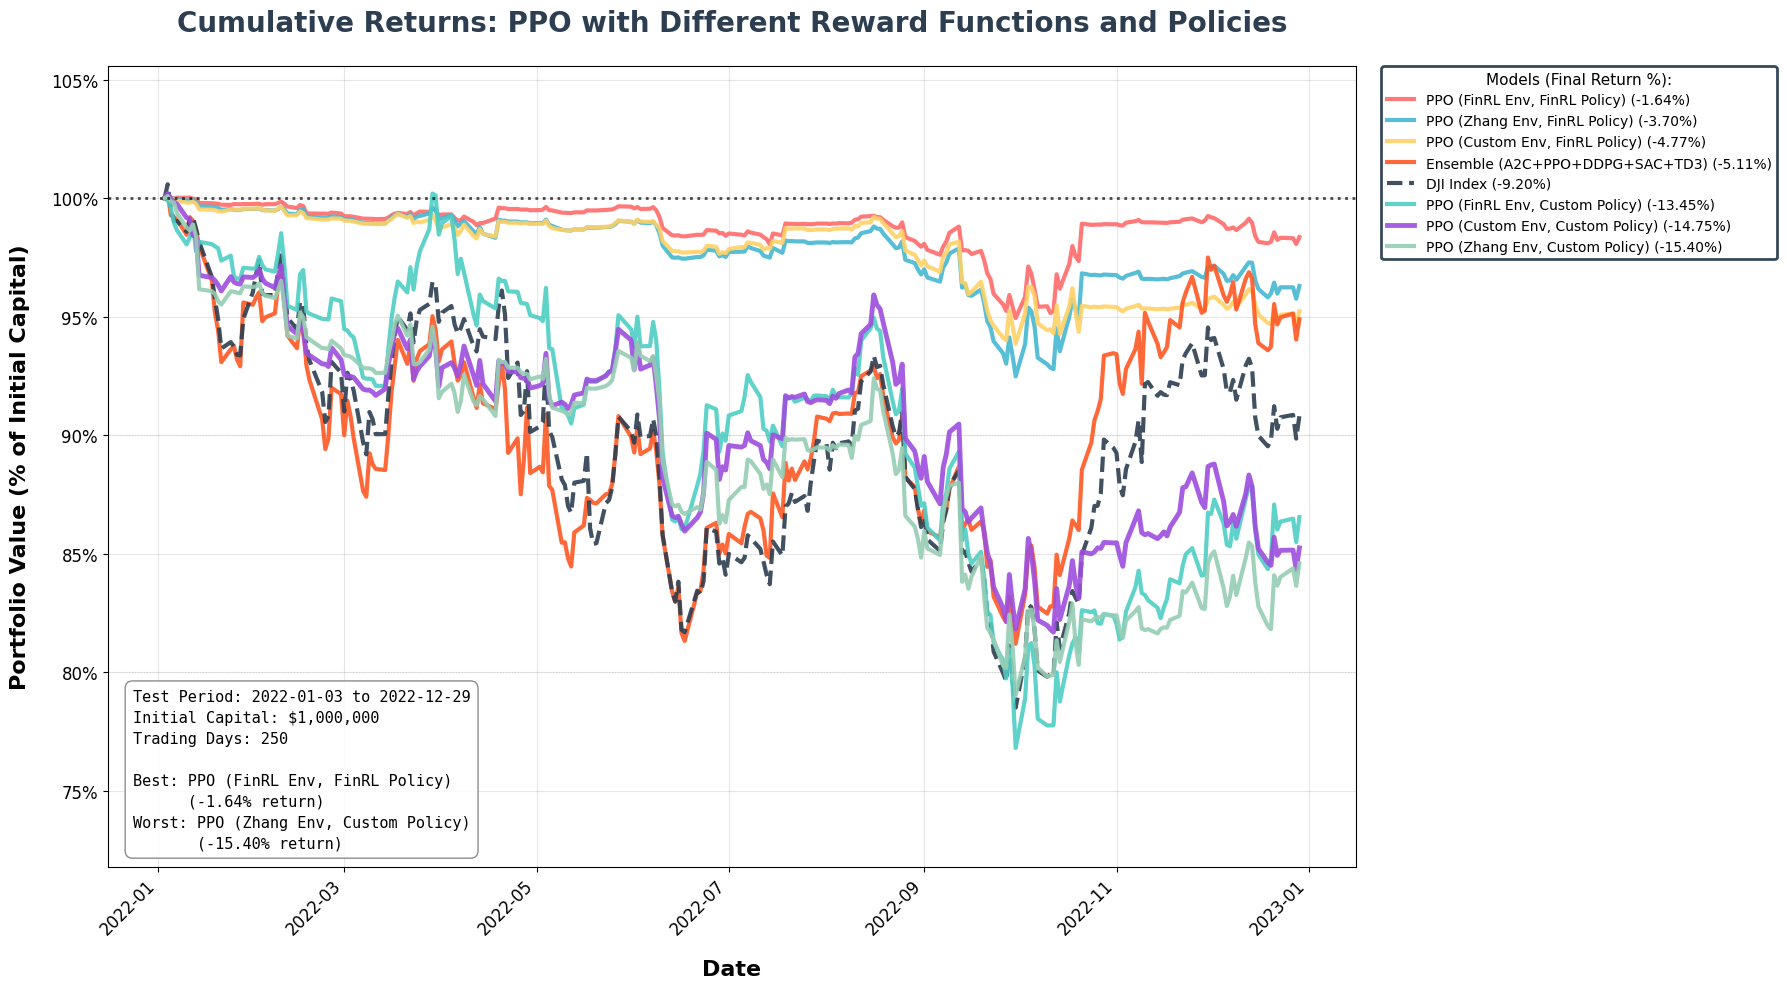


✅ График сохранен: /content/drive/MyDrive/RL/results_6_ppo/ppo_all_configurations.png


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import os
%matplotlib inline
# Создание основного графика
fig, ax = plt.subplots(figsize=(18, 10))

# Цветовая схема для моделей (6 цветов + DJI)
model_colors = {
    'ppo_finrl_finrl': '#FF6B6B',      # Красный
    'ppo_finrl_custom': '#4ECDC4',     # Бирюзовый
    'ppo_zhang_finrl': '#45B7D1',      # Голубой
    'ppo_zhang_custom': '#96CEB4',     # Зеленый
    'ppo_custom_finrl': '#FFD166',     # Желтый
    'ppo_custom_custom': '#9D4EDD',    # Фиолетовый
    'ensemble': '#FF5722',             # Оранжевый (новый цвет для ансамбля)
    'dji': '#2C3E50'                   # Темно-синий (для DJI)
}

# Полные имена для легенды
model_names_full = {
    'ppo_finrl_finrl': 'PPO (FinRL Env, FinRL Policy)',
    'ppo_finrl_custom': 'PPO (FinRL Env, Custom Policy)',
    'ppo_zhang_finrl': 'PPO (Zhang Env, FinRL Policy)',
    'ppo_zhang_custom': 'PPO (Zhang Env, Custom Policy)',
    'ppo_custom_finrl': 'PPO (Custom Env, FinRL Policy)',
    'ppo_custom_custom': 'PPO (Custom Env, Custom Policy)',
    'ensemble': 'Ensemble (A2C+PPO+DDPG+SAC+TD3)',  # Измените на ваш состав ансамбля
    'dji': 'DJI Index'
}

# Убедимся, что индексы в datetime формате
if hasattr(final_result_df.index, 'dtype') and final_result_df.index.dtype == 'object':
    final_result_df.index = pd.to_datetime(final_result_df.index)

# Толщина линий
line_widths = {col: 3.0 for col in final_result_df.columns}
if 'ppo_custom_custom' in final_result_df.columns:
    line_widths['ppo_custom_custom'] = 3.5  # Выделяем вашу полную конфигурацию

# Сортируем модели по итоговой доходности
final_returns = {}
for model in final_result_df.columns:
    if len(final_result_df[model].dropna()) > 0:
        final_value = final_result_df[model].dropna().iloc[-1]
        initial_value = final_result_df[model].dropna().iloc[0]
        if initial_value != 0:
            final_returns[model] = (final_value / initial_value - 1) * 100
            print(f"{model_names_full.get(model, model)}: "
                  f"Initial=${initial_value:,.2f}, "
                  f"Final=${final_value:,.2f}, "
                  f"Return={final_returns[model]:.2f}%")

models_sorted = sorted(final_returns.keys(),
                      key=lambda x: final_returns[x],
                      reverse=True) if final_returns else final_result_df.columns.tolist()

# Рисуем линии в порядке убывания доходности
for model in models_sorted:
    if model in final_result_df.columns:
        data = final_result_df[model].dropna()
        if len(data) > 1:
            # Нормализуем к начальному капиталу
            initial_value = data.iloc[0]
            normalized_data = data / initial_value * 100

            # Для DJI используем пунктирную линию, для RL моделей - сплошную
            linestyle = '--' if model == 'dji' else '-'

            # Получаем цвет модели
            color = model_colors.get(model, '#000000')

            ax.plot(data.index, normalized_data,
                    label=f"{model_names_full.get(model, model)} ({final_returns.get(model, 0):.2f}%)",
                    color=color,
                    linestyle=linestyle,
                    linewidth=line_widths.get(model, 3),
                    alpha=0.9)

# Настройка графика
ax.set_title('Cumulative Returns: PPO with Different Reward Functions and Policies',
             fontsize=20, fontweight='bold', pad=25, color='#2c3e50')

ax.set_ylabel('Portfolio Value (% of Initial Capital)',
              fontsize=16, fontweight='bold', labelpad=15)

ax.set_xlabel('Date', fontsize=16, fontweight='bold', labelpad=15)

# Форматирование оси Y в процентах
def percent_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Добавляем горизонтальную линию на уровне 100% (начальный капитал)
ax.axhline(y=100, color='black', linestyle=':', linewidth=2.0, alpha=0.7)

# Добавляем фон с горизонтальными уровнями
for level in [80, 90, 100, 110, 120, 130, 140, 150]:
    if level == 100:
        continue
    ax.axhline(y=level, color='gray', linestyle=':', linewidth=0.8, alpha=0.2)

# Легенда
if len(models_sorted) > 0:
    legend = ax.legend(loc='upper left', fontsize=10, frameon=True,
                      framealpha=0.95, edgecolor='#2c3e50',
                      facecolor='white', title='Models (Final Return %):',
                      title_fontsize=11, bbox_to_anchor=(1.02, 1),
                      borderaxespad=0.)
    legend.get_frame().set_linewidth(2)

# Сетка
ax.grid(True, alpha=0.3, linestyle='-', which='both')

# Добавляем информационный блок
if len(final_result_df) > 0:
    start_date = final_result_df.index[0].strftime('%Y-%m-%d')
    end_date = final_result_df.index[-1].strftime('%Y-%m-%d')

    info_text = f"Test Period: {start_date} to {end_date}\n"
    info_text += f"Initial Capital: $1,000,000\n"
    info_text += f"Trading Days: {len(final_result_df)}\n"

    if final_returns:
        best_model = max(final_returns.items(), key=lambda x: x[1])
        worst_model = min(final_returns.items(), key=lambda x: x[1])

        info_text += f"\nBest: {model_names_full.get(best_model[0], best_model[0])}\n"
        info_text += f"      ({best_model[1]:.2f}% return)\n"
        info_text += f"Worst: {model_names_full.get(worst_model[0], worst_model[0])}\n"
        info_text += f"       ({worst_model[1]:.2f}% return)"

    props = dict(boxstyle='round', facecolor='white', alpha=0.9,
                edgecolor='gray', pad=0.5)
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', bbox=props, fontfamily='monospace',
            linespacing=1.5)

# Поворот дат на оси X
plt.xticks(rotation=45, ha='right')

# Устанавливаем отступы для осей
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)

# Автоматическое масштабирование оси Y
if len(final_result_df) > 0:
    all_values = []
    for model in final_result_df.columns:
        data = final_result_df[model].dropna()
        if len(data) > 0:
            initial_value = data.iloc[0]
            normalized = data / initial_value * 100
            all_values.extend(normalized.values)

    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        y_padding = max((y_max - y_min) * 0.1, 5)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.show()

# Сохранение графика
save_dir = "/content/drive/MyDrive/RL/results_6_ppo"
os.makedirs(save_dir, exist_ok=True)

fig.savefig(f'{save_dir}/ppo_all_configurations.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

print(f"\n✅ График сохранен: {save_dir}/ppo_all_configurations.png")

📋 Формирование сводной таблицы метрик

📊 СВОДНАЯ ТАБЛИЦА МЕТРИК (отсортировано по Sharpe Ratio)
               Cumulative returns  Annual return  Annual volatility  \
finrl_finrl               -0.0168        -0.0168             0.0441   
zhang_finrl               -0.0393        -0.0395             0.0605   
finrl_custom              -0.1386        -0.1391             0.1748   
custom_finrl              -0.0510        -0.0512             0.0546   
zhang_custom              -0.1588        -0.1594             0.1559   
custom_custom             -0.1523        -0.1529             0.1484   

               Sharpe ratio  Max drawdown  
finrl_finrl         -0.3643       -0.0508  
zhang_finrl         -0.6387       -0.0752  
finrl_custom        -0.7728       -0.2334  
custom_finrl        -0.9378       -0.0615  
zhang_custom        -1.0402       -0.2103  
custom_custom       -1.0477       -0.1846  

✅ Таблица метрик сохранена: /content/drive/MyDrive/RL/results_6_ppo/ppo_metrics_summary.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


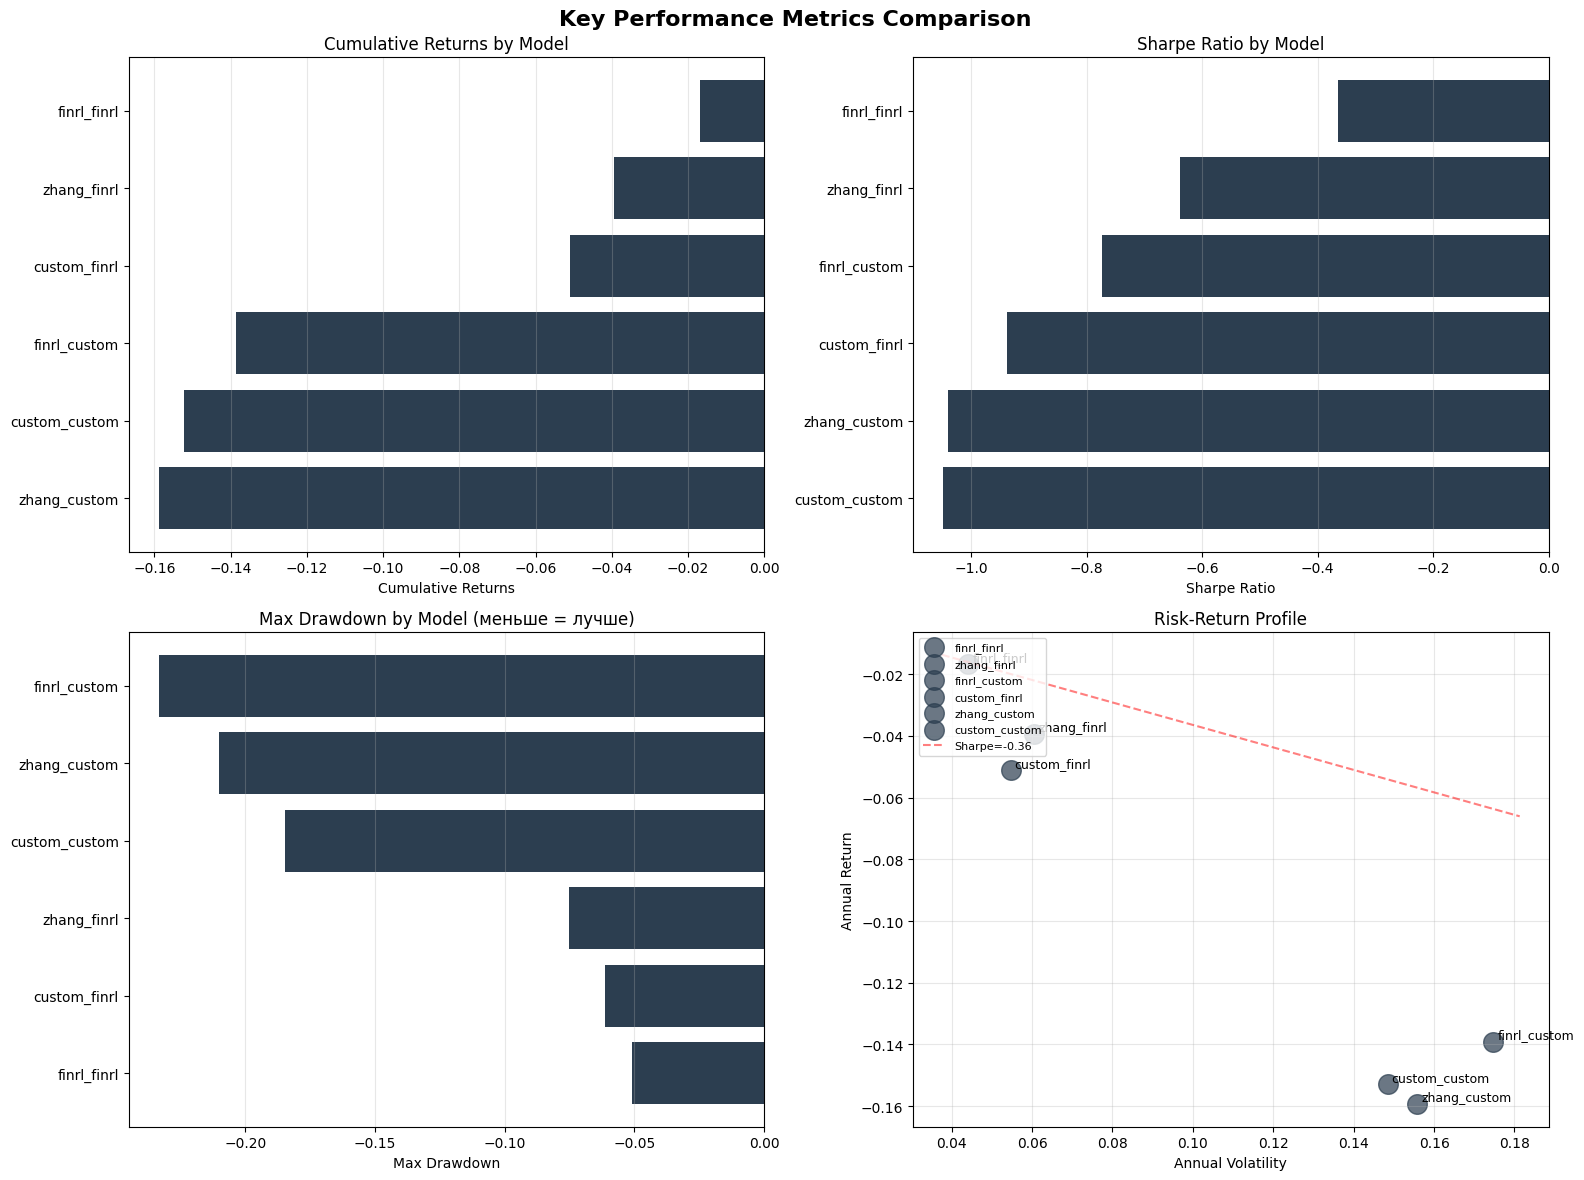

✅ График метрик сохранен: /content/drive/MyDrive/RL/results_6_ppo/ppo_metrics_comparison.png


In [57]:
print("📋 Формирование сводной таблицы метрик")
print("=" * 60)

# Собираем все метрики
all_models = {}
for config_name, stats_df in perf_stats.items():
    if stats_df is not None and not stats_df.empty:
        all_models[config_name] = stats_df

# Добавляем DJI если есть
if 'dji' in final_result_df.columns:
    try:
        dji_stats = backtest_stats(account_value=final_result_df[['dji']])
        all_models['dji'] = pd.DataFrame(dji_stats)
    except:
        pass

# Формируем сводную таблицу
summary_metrics = pd.DataFrame()
key_metrics = [
    'Cumulative returns',
    'Annual return',
    'Annual volatility',
    'Sharpe ratio',
    'Max drawdown'
]

for model_name, model_stats in all_models.items():
    if model_stats is not None:
        if isinstance(model_stats, pd.DataFrame):
            if model_stats.shape[1] == 1:
                model_series = model_stats.iloc[:, 0]
            else:
                model_series = model_stats.iloc[:, 0]
        elif isinstance(model_stats, pd.Series):
            model_series = model_stats
        else:
            print(f"  Пропускаю {model_name} - неподдерживаемый формат")
            continue

        metrics_dict = {}
        display_name = model_names_full.get(model_name, model_name)

        for metric in key_metrics:
            if metric in model_series.index:
                metrics_dict[metric] = model_series[metric]
            else:
                found = False
                for idx in model_series.index:
                    if metric.lower() in str(idx).lower():
                        metrics_dict[metric] = model_series[idx]
                        found = True
                        break
                if not found:
                    metrics_dict[metric] = np.nan

        summary_metrics[display_name] = pd.Series(metrics_dict)

summary_metrics = summary_metrics.T

# Сортируем по Sharpe ratio (по убыванию)
if 'Sharpe ratio' in summary_metrics.columns:
    summary_metrics = summary_metrics.sort_values('Sharpe ratio', ascending=False)

print("\n📊 СВОДНАЯ ТАБЛИЦА МЕТРИК (отсортировано по Sharpe Ratio)")
print("=" * 80)
print(summary_metrics.round(4))

# Сохраняем таблицу в CSV
summary_metrics.to_csv(f'{save_dir}/ppo_metrics_summary.csv')
print(f"\n✅ Таблица метрик сохранена: {save_dir}/ppo_metrics_summary.csv")

# Визуализация метрик
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Performance Metrics Comparison', fontsize=16, fontweight='bold')

# 1. Cumulative Returns
if 'Cumulative returns' in summary_metrics.columns:
    ax1 = axes[0, 0]
    sorted_by_cumret = summary_metrics.sort_values('Cumulative returns', ascending=True)
    colors = [model_colors.get(model.split(' ')[1].lower(), '#808080')
              if '(' in model else model_colors.get('dji', '#2C3E50')
              for model in sorted_by_cumret.index]
    ax1.barh(sorted_by_cumret.index, sorted_by_cumret['Cumulative returns'], color=colors)
    ax1.set_xlabel('Cumulative Returns')
    ax1.set_title('Cumulative Returns by Model')
    ax1.grid(True, alpha=0.3, axis='x')

# 2. Sharpe Ratio
if 'Sharpe ratio' in summary_metrics.columns:
    ax2 = axes[0, 1]
    sorted_by_sharpe = summary_metrics.sort_values('Sharpe ratio', ascending=True)
    colors = [model_colors.get(model.split(' ')[1].lower(), '#808080')
              if '(' in model else model_colors.get('dji', '#2C3E50')
              for model in sorted_by_sharpe.index]
    ax2.barh(sorted_by_sharpe.index, sorted_by_sharpe['Sharpe ratio'], color=colors)
    ax2.set_xlabel('Sharpe Ratio')
    ax2.set_title('Sharpe Ratio by Model')
    ax2.grid(True, alpha=0.3, axis='x')

# 3. Max Drawdown
if 'Max drawdown' in summary_metrics.columns:
    ax3 = axes[1, 0]
    sorted_by_dd = summary_metrics.sort_values('Max drawdown', ascending=False)
    colors = [model_colors.get(model.split(' ')[1].lower(), '#808080')
              if '(' in model else model_colors.get('dji', '#2C3E50')
              for model in sorted_by_dd.index]
    ax3.barh(sorted_by_dd.index, sorted_by_dd['Max drawdown'], color=colors)
    ax3.set_xlabel('Max Drawdown')
    ax3.set_title('Max Drawdown by Model (меньше = лучше)')
    ax3.grid(True, alpha=0.3, axis='x')

# 4. Annual Return vs Volatility
if 'Annual return' in summary_metrics.columns and 'Annual volatility' in summary_metrics.columns:
    ax4 = axes[1, 1]
    for model in summary_metrics.index:
        color = model_colors.get(model.split(' ')[1].lower(), '#808080') if '(' in model else model_colors.get('dji', '#2C3E50')
        ax4.scatter(summary_metrics.loc[model, 'Annual volatility'],
                   summary_metrics.loc[model, 'Annual return'],
                   color=color, s=200, alpha=0.7, label=model)
        ax4.text(summary_metrics.loc[model, 'Annual volatility'] + 0.001,
                summary_metrics.loc[model, 'Annual return'] + 0.001,
                model[:15] + '...' if len(model) > 15 else model,
                fontsize=9)
    ax4.set_xlabel('Annual Volatility')
    ax4.set_ylabel('Annual Return')
    ax4.set_title('Risk-Return Profile')
    ax4.grid(True, alpha=0.3)
    # Добавляем линию эффективности
    x_vals = np.array(ax4.get_xlim())
    if 'Sharpe ratio' in summary_metrics.columns:
        best_sharpe = summary_metrics['Sharpe ratio'].max()
        if not np.isnan(best_sharpe):
            ax4.plot(x_vals, best_sharpe * x_vals, 'r--', alpha=0.5, label=f'Sharpe={best_sharpe:.2f}')
    ax4.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# Сохраняем график метрик
fig.savefig(f'{save_dir}/ppo_metrics_comparison.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
print(f"✅ График метрик сохранен: {save_dir}/ppo_metrics_comparison.png")

In [44]:
print("💾 Сохранение всех результатов эксперимента")
print("=" * 60)

# Создаем директории
results_dir = "/content/drive/MyDrive/RL/results_6_ppo"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(f"{results_dir}/models", exist_ok=True)
os.makedirs(f"{results_dir}/data", exist_ok=True)
os.makedirs(f"{results_dir}/visualizations", exist_ok=True)

# 1. Сохраняем обученные модели
print("Сохранение моделей...")
for config_name, model in trained_models.items():
    if model is not None:
        try:
            model.save(f"{results_dir}/models/ppo_{config_name}.zip")
            print(f"  ✅ Модель {config_name} сохранена")
        except Exception as e:
            print(f"  ❌ Ошибка при сохранении модели {config_name}: {e}")

# 2. Сохраняем значения счетов
print("\nСохранение данных счетов...")
for config_name, df in df_account_values.items():
    if df is not None:
        try:
            df.to_csv(f"{results_dir}/data/account_values_{config_name}.csv")
            print(f"  ✅ Данные счета {config_name} сохранены")
        except Exception as e:
            print(f"  ❌ Ошибка при сохранении данных счета {config_name}: {e}")

# 3. Сохраняем действия агентов
print("\nСохранение действий агентов...")
for config_name, df in df_actions.items():
    if df is not None:
        try:
            df.to_csv(f"{results_dir}/data/actions_{config_name}.csv")
            print(f"  ✅ Действия {config_name} сохранены")
        except Exception as e:
            print(f"  ❌ Ошибка при сохранении действий {config_name}: {e}")

# 4. Сохраняем финальный DataFrame
try:
    final_result_df.to_csv(f"{results_dir}/data/final_results_all_configs.csv")
    print(f"\n✅ Финальный DataFrame сохранен: {results_dir}/data/final_results_all_configs.csv")
except Exception as e:
    print(f"\n❌ Ошибка при сохранении финального DataFrame: {e}")

# 5. Сохраняем метрики
try:
    summary_metrics.to_csv(f"{results_dir}/data/performance_metrics_summary.csv")
    print(f"✅ Сводные метрики сохранены: {results_dir}/data/performance_metrics_summary.csv")
except Exception as e:
    print(f"❌ Ошибка при сохранении метрик: {e}")

# 6. Создаем README файл с описанием эксперимента
readme_content = f"""# Эксперимент: Reinforcement Learning for Time-Series Forecasting

## Описание эксперимента
Сравнение 6 конфигураций алгоритма PPO с различными функциями награды и архитектурами политик.

## Конфигурации
1. PPO, FinRL env, FinRL policy
2. PPO, FinRL env, Custom policy
3. PPO, Zhang env, FinRL policy
4. PPO, Zhang env, Custom policy
5. PPO, Custom env, FinRL policy
6. PPO, Custom env, Custom policy

## Параметры
- State space: {state_space}
- Total timesteps: {10000}
- Дата эксперимента: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Результаты
Лучшая модель по Sharpe Ratio: {summary_metrics.index[0] if not summary_metrics.empty else 'N/A'}
Все результаты сохранены в соответствующих папках.
"""

with open(f"{results_dir}/README.md", "w", encoding="utf-8") as f:
    f.write(readme_content)

print(f"\n✅ README файл создан: {results_dir}/README.md")
print("\n" + "=" * 60)
print("🎉 ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЕН!")
print(f"Все результаты сохранены в папке: {results_dir}")
print("=" * 60)

💾 Сохранение всех результатов эксперимента
Сохранение моделей...
  ✅ Модель finrl_finrl сохранена
  ✅ Модель finrl_custom сохранена
  ✅ Модель zhang_finrl сохранена
  ✅ Модель zhang_custom сохранена
  ✅ Модель custom_finrl сохранена
  ✅ Модель custom_custom сохранена

Сохранение данных счетов...
  ✅ Данные счета finrl_finrl сохранены
  ✅ Данные счета finrl_custom сохранены
  ✅ Данные счета zhang_finrl сохранены
  ✅ Данные счета zhang_custom сохранены
  ✅ Данные счета custom_finrl сохранены
  ✅ Данные счета custom_custom сохранены

Сохранение действий агентов...
  ✅ Действия finrl_finrl сохранены
  ✅ Действия finrl_custom сохранены
  ✅ Действия zhang_finrl сохранены
  ✅ Действия zhang_custom сохранены
  ✅ Действия custom_finrl сохранены
  ✅ Действия custom_custom сохранены

✅ Финальный DataFrame сохранен: /content/drive/MyDrive/RL/results_6_ppo/data/final_results_all_configs.csv
✅ Сводные метрики сохранены: /content/drive/MyDrive/RL/results_6_ppo/data/performance_metrics_summary.csv

✅ 

- Стандартная политика FinRL показала себя лучше кастомной во всех трёх средах.

- Стандартная среда FinRL показала наилучший (или наименее плохой) результат.

## Compare PPO configurations on 50 000 timestamps
Reasons:
- Недостаточное обучение: 10 000 шагов — это очень мало для сложной задачи торговли. Алгоритм PPO, особенно с n_steps=2048, мог сделать всего около 5 значительных обновлений политики. Модели просто не успели сойтись к какой-либо осмысленной стратегии. Это основная гипотеза.

- Сложность оптимизации кастомной политики: Кастомная сеть ([256, 128]) может иметь избыточную ёмкость или быть сложнее для оптимизации, чем стандартная в FinRL ([64, 64]). При малом количестве шагов это приводит к нестабильности и худшим результатам.

- Чувствительность функции вознаграждения: Результаты показывают, что кастомная и Zhang функции могут давать более шумный или менее понятный градиент на начальных этапах обучения по сравнению со стандартной, что замедляет обучение.

In [58]:
# Словарь для хранения обученных моделей
trained_models = {}
training_results = {}


for config_name, (env_train, e_train, policy_kwargs) in train_environments.items():
    print(f"\n📊 Обучение модели: {config_name}")
    print(f"   Среда: {config_name.split('_')[0]}, Политика: {config_name.split('_')[1]}")

    try:
        # Создание агента DRL
        agent = DRLAgent(env=env_train)

        # Получение модели PPO с соответствующими параметрами политики
        if policy_kwargs is not None:
            print(f"   Используется custom policy: {policy_kwargs['net_arch']}")
            model = agent.get_model("ppo",
                                   model_kwargs=PPO_model_kwargs,
                                   policy_kwargs=policy_kwargs,
                                   verbose=1)
        else:
            print("   Используется стандартная политика FinRL")
            model = agent.get_model("ppo",
                                   model_kwargs=PPO_model_kwargs,
                                   verbose=1)

        # Обучение модели
        print(f"   Обучение на {50000} шагах...")
        trained_model = agent.train_model(model=model,
                                        tb_log_name=f"ppo_{config_name}",
                                        total_timesteps=50000)

        # Сохранение обученной модели
        trained_models[config_name] = trained_model
        print(f"   ✅ Модель {config_name} успешно обучена")

    except Exception as e:
        print(f"   ❌ Ошибка при обучении {config_name}: {str(e)}")
        trained_models[config_name] = None

print("\n" + "=" * 60)
print(f"Обучение завершено. Успешно обучено моделей: "
      f"{sum(1 for m in trained_models.values() if m is not None)} из 6")


📊 Обучение модели: finrl_finrl
   Среда: finrl, Политика: finrl
   Используется стандартная политика FinRL
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
   Обучение на 50000 шагах...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 87         |
|    iterations      | 1          |
|    time_elapsed    | 23         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.7010053  |
|    reward_max      | 6.9085073  |
|    reward_mean     | 0.08700612 |
|    reward_min      | -12.8153   |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 2           |
|    time_elapsed         | 50          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013469186 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.0055     |
|    learning_rate        | 0.00025     |
|    loss             

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 3           |
|    time_elapsed         | 85          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.016954664 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.00717     |
|    learning_rate        | 0.00025     |
|    loss                 | 36.6        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0177     |
|    reward               | -0.48418662 |
|    reward_max           | 24.990194   |
|    reward_mean          | 0.11250138  |
|    reward_min           | -34.906357  |
|    std                  | 1           |
|    value_loss           | 62.8        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 4           |
|    time_elapsed         | 109         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012413151 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.00917    |
|    learning_rate        | 0.00025     |
|    loss                 | 32.8        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0134     |
|    reward               | 0.19136305  |
|    reward_max           | 5.1092935   |
|    reward_mean          | 0.040750466 |
|    reward_min           | -8.532113   |
|    std                  | 1           |
|    value_loss           | 46.1        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 6           |
|    time_elapsed         | 155         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.013695652 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | -0.000419   |
|    learning_rate        | 0.00025     |
|    loss                 | 16.6        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0138     |
|    reward               | 0.15581788  |
|    reward_max           | 16.931126   |
|    reward_mean          | 0.0679815   |
|    reward_min           | -21.516487  |
|    std                  | 1.01        |
|    value_loss           | 22.4        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 7           |
|    time_elapsed         | 189         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.016079213 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -0.027      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.6        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0117     |
|    reward               | -0.24323657 |
|    reward_max           | 6.3104615   |
|    reward_mean          | 0.041783974 |
|    reward_min           | -9.168159   |
|    std                  | 1.01        |
|    value_loss           | 33.2        |
-----------------------------------------
day: 3020, episode: 10
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 8           |
|    time_elapsed         | 231         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.017196525 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -0.0191     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.26        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0177     |
|    reward               | 2.4753165   |
|    reward_max           | 17.857618   |
|    reward_mean          | 0.06273417  |
|    reward_min           | -20.99486   |
|    std                  | 1.01        |
|    value_loss           | 11.3        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 10          |
|    time_elapsed         | 285         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.024550986 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -0.0202     |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0112     |
|    reward               | -4.59525    |
|    reward_max           | 8.388528    |
|    reward_mean          | 0.054391593 |
|    reward_min           | -9.022037   |
|    std                  | 1.01        |
|    value_loss           | 37          |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 12          |
|    time_elapsed         | 328         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.01823515  |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.5       |
|    explained_variance   | 0.00979     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.22        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0157     |
|    reward               | -0.87115324 |
|    reward_max           | 20.562893   |
|    reward_mean          | 0.062197976 |
|    reward_min           | -27.547703  |
|    std                  | 1.02        |
|    value_loss           | 28.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 13          |
|    time_elapsed         | 349         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.021481924 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.5       |
|    explained_variance   | 0.0137      |
|    learning_rate        | 0.00025     |
|    loss                 | 16.3        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0131     |
|    reward               | -1.214684   |
|    reward_max           | 6.979818    |
|    reward_mean          | 0.0379105   |
|    reward_min           | -7.47607    |
|    std                  | 1.02        |
|    value_loss           | 35.6        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 4449607.47
total_reward: 3449607.47
total_cost: 303775.69
total_trades: 67748
Sharpe: 0.787


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 78           |
|    iterations           | 15           |
|    time_elapsed         | 393          |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0153968455 |
|    clip_fraction        | 0.139        |
|    clip_range           | 0.2          |
|    entropy_loss         | -34.6        |
|    explained_variance   | 0.00544      |
|    learning_rate        | 0.00025      |
|    loss                 | 10.2         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.0171      |
|    reward               | -0.17570032  |
|    reward_max           | 32.97213     |
|    reward_mean          | 0.13334982   |
|    reward_min           | -45.46558    |
|    std                  | 1.02         |
|    value_loss           | 23           |
------------------------------------------
-----------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 18          |
|    time_elapsed         | 470         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.016419476 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | 0.0437      |
|    learning_rate        | 0.00025     |
|    loss                 | 24.5        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0133     |
|    reward               | 0.09454373  |
|    reward_max           | 15.159274   |
|    reward_mean          | 0.048672564 |
|    reward_min           | -20.665716  |
|    std                  | 1.02        |
|    value_loss           | 51.8        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 19          |
|    time_elapsed         | 490         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.021338796 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | 0.0335      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0103     |
|    reward               | -1.5039402  |
|    reward_max           | 24.66251    |
|    reward_mean          | 0.04522495  |
|    reward_min           | -29.925957  |
|    std                  | 1.03        |
|    value_loss           | 24.8        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 21          |
|    time_elapsed         | 545         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.013927624 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | 0.04        |
|    learning_rate        | 0.00025     |
|    loss                 | 13.7        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0128     |
|    reward               | -1.9105926  |
|    reward_max           | 19.153502   |
|    reward_mean          | 0.056547925 |
|    reward_min           | -21.280222  |
|    std                  | 1.03        |
|    value_loss           | 19.9        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 22          |
|    time_elapsed         | 566         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.014722317 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | 0.00398     |
|    learning_rate        | 0.00025     |
|    loss                 | 19.8        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.013      |
|    reward               | -0.7709938  |
|    reward_max           | 15.144592   |
|    reward_mean          | 0.03122631  |
|    reward_min           | -18.840609  |
|    std                  | 1.03        |
|    value_loss           | 37          |
-----------------------------------------
day: 3020, episode: 20
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 23          |
|    time_elapsed         | 586         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.020203369 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | -0.00724    |
|    learning_rate        | 0.00025     |
|    loss                 | 11.8        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0125     |
|    reward               | 0.24424961  |
|    reward_max           | 6.2564297   |
|    reward_mean          | 0.058897633 |
|    reward_min           | -11.479498  |
|    std                  | 1.03        |
|    value_loss           | 25.7        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 81          |
|    iterations           | 25          |
|    time_elapsed         | 631         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.025947742 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.8       |
|    explained_variance   | 0.00915     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.11        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00534    |
|    reward               | 2.1316197   |
|    reward_max           | 17.963655   |
|    reward_mean          | 0.058455937 |
|    reward_min           | -20.582493  |
|    std                  | 1.03        |
|    value_loss           | 33.3        |
-----------------------------------------
   ✅ Модель finrl_finrl успешно об

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 104        |
|    iterations      | 1          |
|    time_elapsed    | 19         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 2.42768    |
|    reward_max      | 8.131003   |
|    reward_mean     | 0.11886216 |
|    reward_min      | -16.778402 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 2          |
|    time_elapsed         | 44         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 1111603.9  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -2.35      |
|    learning_rate        | 0.00025    |
|    loss                 | 47.8   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3           |
|    time_elapsed         | 64          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 342851.38   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -2.38       |
|    learning_rate        | 0.00025     |
|    loss                 | 436         |
|    n_updates            | 20          |
|    policy_gradient_loss | 0.164       |
|    reward               | -0.74631757 |
|    reward_max           | 47.55685    |
|    reward_mean          | 0.34367388  |
|    reward_min           | -80.27154   |
|    std                  | 1           |
|    value_loss           | 2.73e+03    |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 4          |
|    time_elapsed         | 85         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 3026745.8  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -1.53      |
|    learning_rate        | 0.00025    |
|    loss                 | 574        |
|    n_updates            | 30         |
|    policy_gradient_loss | 0.182      |
|    reward               | -3.5398042 |
|    reward_max           | 9.565078   |
|    reward_mean          | 0.14287828 |
|    reward_min           | -17.895384 |
|    std                  | 1          |
|    value_loss           | 1.11e+03   |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 95         |
|    iterations           | 6          |
|    time_elapsed         | 128        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 6352134.5  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.3      |
|    explained_variance   | 0.451      |
|    learning_rate        | 0.00025    |
|    loss                 | 652        |
|    n_updates            | 50         |
|    policy_gradient_loss | 0.232      |
|    reward               | 0.15983377 |
|    reward_max           | 35.830963  |
|    reward_mean          | 0.23704848 |
|    reward_min           | -45.172016 |
|    std                  | 1.01       |
|    value_loss           | 1.83e+03   |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 95         |
|    iterations           | 7          |
|    time_elapsed         | 149        |
|    total_timesteps      | 14336      |
| train/                  |            |
|    approx_kl            | 3435786.5  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.3      |
|    explained_variance   | 0.00117    |
|    learning_rate        | 0.00025    |
|    loss                 | 82.5       |
|    n_updates            | 60         |
|    policy_gradient_loss | 0.211      |
|    reward               | 1.9321469  |
|    reward_max           | 8.846296   |
|    reward_mean          | 0.1127336  |
|    reward_min           | -14.954965 |
|    std                  | 1.01       |
|    value_loss           | 2.88e+03   |
----------------------------------------
day: 3020, episode: 10
begin_total_asset: 1000000.00
end_

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 8          |
|    time_elapsed         | 169        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 151396.25  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.4      |
|    explained_variance   | 0.169      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.83       |
|    n_updates            | 70         |
|    policy_gradient_loss | 0.297      |
|    reward               | 2.3283472  |
|    reward_max           | 27.760515  |
|    reward_mean          | 0.09603319 |
|    reward_min           | -34.78767  |
|    std                  | 1.02       |
|    value_loss           | 18.2       |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 10          |
|    time_elapsed         | 210         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 576260.1    |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | -2.24       |
|    learning_rate        | 0.00025     |
|    loss                 | 73.7        |
|    n_updates            | 90          |
|    policy_gradient_loss | 0.15        |
|    reward               | -7.6143966  |
|    reward_max           | 14.194548   |
|    reward_mean          | 0.115576975 |
|    reward_min           | -14.942769  |
|    std                  | 1.02        |
|    value_loss           | 1.43e+03    |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 12          |
|    time_elapsed         | 251         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 148153.97   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.8       |
|    explained_variance   | -3.49       |
|    learning_rate        | 0.00025     |
|    loss                 | 60.1        |
|    n_updates            | 110         |
|    policy_gradient_loss | 0.129       |
|    reward               | -1.4677981  |
|    reward_max           | 25.715391   |
|    reward_mean          | 0.107284315 |
|    reward_min           | -32.18232   |
|    std                  | 1.03        |
|    value_loss           | 6.59e+03    |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 13         |
|    time_elapsed         | 272        |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 2834195.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.8      |
|    explained_variance   | -4.3       |
|    learning_rate        | 0.00025    |
|    loss                 | 195        |
|    n_updates            | 120        |
|    policy_gradient_loss | 0.154      |
|    reward               | -0.8332669 |
|    reward_max           | 14.290023  |
|    reward_mean          | 0.1362547  |
|    reward_min           | -15.850971 |
|    std                  | 1.03       |
|    value_loss           | 848        |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 3694210.10
total_reward: 2694210.10
total_cost: 3054.72
total_trades: 15650
Sharpe: 0.782


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 15          |
|    time_elapsed         | 313         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 324598.7    |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35         |
|    explained_variance   | -3.41       |
|    learning_rate        | 0.00025     |
|    loss                 | 863         |
|    n_updates            | 140         |
|    policy_gradient_loss | 0.122       |
|    reward               | -0.05251269 |
|    reward_max           | 25.726858   |
|    reward_mean          | 0.11034861  |
|    reward_min           | -22.286442  |
|    std                  | 1.04        |
|    value_loss           | 1.48e+03    |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 18         |
|    time_elapsed         | 376        |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 1918120.5  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.3      |
|    explained_variance   | -0.891     |
|    learning_rate        | 0.00025    |
|    loss                 | 252        |
|    n_updates            | 170        |
|    policy_gradient_loss | 0.112      |
|    reward               | 0.87256634 |
|    reward_max           | 23.3327    |
|    reward_mean          | 0.13441241 |
|    reward_min           | -25.955853 |
|    std                  | 1.05       |
|    value_loss           | 3.14e+03   |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 19         |
|    time_elapsed         | 396        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 1473725.2  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.3      |
|    explained_variance   | -1.79      |
|    learning_rate        | 0.00025    |
|    loss                 | 31.2       |
|    n_updates            | 180        |
|    policy_gradient_loss | 0.122      |
|    reward               | 1.6343567  |
|    reward_max           | 24.184582  |
|    reward_mean          | 0.10994849 |
|    reward_min           | -27.079037 |
|    std                  | 1.05       |
|    value_loss           | 825        |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 21         |
|    time_elapsed         | 438        |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 10008896.0 |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.4      |
|    explained_variance   | -1.75      |
|    learning_rate        | 0.00025    |
|    loss                 | 49.4       |
|    n_updates            | 200        |
|    policy_gradient_loss | 0.13       |
|    reward               | -1.8086114 |
|    reward_max           | 25.064     |
|    reward_mean          | 0.144184   |
|    reward_min           | -28.378672 |
|    std                  | 1.06       |
|    value_loss           | 508        |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 22         |
|    time_elapsed         | 459        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 24521072.0 |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.4      |
|    explained_variance   | -2.39      |
|    learning_rate        | 0.00025    |
|    loss                 | 29.3       |
|    n_updates            | 210        |
|    policy_gradient_loss | 0.158      |
|    reward               | -4.3615355 |
|    reward_max           | 24.715448  |
|    reward_mean          | 0.11646062 |
|    reward_min           | -28.878777 |
|    std                  | 1.06       |
|    value_loss           | 348        |
----------------------------------------
day: 3020, episode: 20
begin_total_asset: 1000000.00
end_

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 23         |
|    time_elapsed         | 479        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 2563631.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.6      |
|    explained_variance   | 0.233      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.8       |
|    n_updates            | 220        |
|    policy_gradient_loss | 0.26       |
|    reward               | 0.5452142  |
|    reward_max           | 20.258041  |
|    reward_mean          | 0.0964846  |
|    reward_min           | -11.141496 |
|    std                  | 1.07       |
|    value_loss           | 42.2       |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 25          |
|    time_elapsed         | 521         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 1823398.9   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.8       |
|    explained_variance   | -3.09       |
|    learning_rate        | 0.00025     |
|    loss                 | 32.8        |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.146       |
|    reward               | 1.7716746   |
|    reward_max           | 24.246937   |
|    reward_mean          | 0.115605175 |
|    reward_min           | -28.538122  |
|    std                  | 1.07        |
|    value_loss           | 301         |
-----------------------------------------
   ✅ Модель finrl_custom успешно о

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/              |             |
|    fps             | 101         |
|    iterations      | 1           |
|    time_elapsed    | 20          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.92688465  |
|    reward_max      | 6.4697056   |
|    reward_mean     | 0.077781044 |
|    reward_min      | -11.223428  |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 2           |
|    time_elapsed         | 41          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013205375 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.000914   |
|    learning_rate        | 0.00025     |
|    loss 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 3           |
|    time_elapsed         | 62          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.008354757 |
|    clip_fraction        | 0.0896      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | 0.0026      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.6        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0137     |
|    reward               | -0.3969507  |
|    reward_max           | 21.120974   |
|    reward_mean          | 0.08329731  |
|    reward_min           | -23.926773  |
|    std                  | 1           |
|    value_loss           | 44          |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 4           |
|    time_elapsed         | 84          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012114006 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | -0.0212     |
|    learning_rate        | 0.00025     |
|    loss                 | 17          |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0136     |
|    reward               | -0.8165651  |
|    reward_max           | 7.5873137   |
|    reward_mean          | 0.081626154 |
|    reward_min           | -11.562779  |
|    std                  | 1.01        |
|    value_loss           | 39.7        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 6          |
|    time_elapsed         | 124        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.01337407 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.2      |
|    explained_variance   | -0.0169    |
|    learning_rate        | 0.00025    |
|    loss                 | 15.1       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0166    |
|    reward               | 0.18000354 |
|    reward_max           | 24.616072  |
|    reward_mean          | 0.09568894 |
|    reward_min           | -40.1175   |
|    std                  | 1.01       |
|    value_loss           | 36.2       |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 7           |
|    time_elapsed         | 145         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.011942156 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | 0.00592     |
|    learning_rate        | 0.00025     |
|    loss                 | 27.1        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0183     |
|    reward               | 0.35529602  |
|    reward_max           | 6.2499714   |
|    reward_mean          | 0.06883927  |
|    reward_min           | -10.549352  |
|    std                  | 1.01        |
|    value_loss           | 128         |
-----------------------------------------
day: 3020, episode: 10
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 8           |
|    time_elapsed         | 165         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014125818 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | -0.051      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.54        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0136     |
|    reward               | 2.8321989   |
|    reward_max           | 19.752285   |
|    reward_mean          | 0.07834802  |
|    reward_min           | -23.16567   |
|    std                  | 1.01        |
|    value_loss           | 9.69        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 10          |
|    time_elapsed         | 206         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.014930066 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -0.0112     |
|    learning_rate        | 0.00025     |
|    loss                 | 26.3        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0138     |
|    reward               | -11.509084  |
|    reward_max           | 17.431137   |
|    reward_mean          | 0.12405011  |
|    reward_min           | -17.95123   |
|    std                  | 1.01        |
|    value_loss           | 105         |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 12          |
|    time_elapsed         | 247         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.016126715 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.4       |
|    explained_variance   | -0.00521    |
|    learning_rate        | 0.00025     |
|    loss                 | 59.1        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0172     |
|    reward               | -0.75877964 |
|    reward_max           | 28.335144   |
|    reward_mean          | 0.11888406  |
|    reward_min           | -35.075935  |
|    std                  | 1.01        |
|    value_loss           | 97.5        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 13          |
|    time_elapsed         | 268         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.017861728 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.4       |
|    explained_variance   | -0.0154     |
|    learning_rate        | 0.00025     |
|    loss                 | 53.8        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0124     |
|    reward               | -0.7561233  |
|    reward_max           | 11.219809   |
|    reward_mean          | 0.082989335 |
|    reward_min           | -11.47702   |
|    std                  | 1.01        |
|    value_loss           | 67.1        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 4514252.86
total_reward: 3514252.86
total_cost: 314474.62
total_trades: 68022
Sharpe: 0.829


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 15          |
|    time_elapsed         | 309         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.017301496 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.4       |
|    explained_variance   | 0.00168     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.1        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0157     |
|    reward               | -0.08576905 |
|    reward_max           | 25.611914   |
|    reward_mean          | 0.14559811  |
|    reward_min           | -36.5073    |
|    std                  | 1.01        |
|    value_loss           | 29.2        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 95         |
|    iterations           | 18         |
|    time_elapsed         | 387        |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 0.02010664 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.5      |
|    explained_variance   | -0.00294   |
|    learning_rate        | 0.00025    |
|    loss                 | 18.8       |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0153    |
|    reward               | 0.56075644 |
|    reward_max           | 27.546816  |
|    reward_mean          | 0.12551932 |
|    reward_min           | -44.035522 |
|    std                  | 1.02       |
|    value_loss           | 30.7       |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 19          |
|    time_elapsed         | 413         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.017666852 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.5       |
|    explained_variance   | 0.00715     |
|    learning_rate        | 0.00025     |
|    loss                 | 37.6        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0161     |
|    reward               | 4.37362     |
|    reward_max           | 33.095245   |
|    reward_mean          | 0.114943735 |
|    reward_min           | -45.24751   |
|    std                  | 1.02        |
|    value_loss           | 134         |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 21          |
|    time_elapsed         | 455         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.023958024 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | -0.00363    |
|    learning_rate        | 0.00025     |
|    loss                 | 15.7        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0164     |
|    reward               | -1.2150203  |
|    reward_max           | 23.718481   |
|    reward_mean          | 0.12352872  |
|    reward_min           | -28.440443  |
|    std                  | 1.03        |
|    value_loss           | 29.7        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 22          |
|    time_elapsed         | 474         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.023971952 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | 0.00245     |
|    learning_rate        | 0.00025     |
|    loss                 | 23          |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0103     |
|    reward               | -4.216657   |
|    reward_max           | 38.271847   |
|    reward_mean          | 0.1805364   |
|    reward_min           | -56.2731    |
|    std                  | 1.03        |
|    value_loss           | 56.4        |
-----------------------------------------
day: 3020, episode: 20
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 23          |
|    time_elapsed         | 499         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.016597075 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.8       |
|    explained_variance   | -0.00478    |
|    learning_rate        | 0.00025     |
|    loss                 | 61.1        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0138     |
|    reward               | 0.95148265  |
|    reward_max           | 12.441522   |
|    reward_mean          | 0.11803146  |
|    reward_min           | -16.347973  |
|    std                  | 1.03        |
|    value_loss           | 113         |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 25          |
|    time_elapsed         | 541         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.032335795 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.9       |
|    explained_variance   | 0.0112      |
|    learning_rate        | 0.00025     |
|    loss                 | 61          |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.013      |
|    reward               | 2.057959    |
|    reward_max           | 30.865074   |
|    reward_mean          | 0.19421826  |
|    reward_min           | -37.732037  |
|    std                  | 1.04        |
|    value_loss           | 80.5        |
-----------------------------------------
   ✅ Модель zhang_finrl успешно об

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 98         |
|    iterations      | 1          |
|    time_elapsed    | 20         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.55640256 |
|    reward_max      | 6.8343315  |
|    reward_mean     | 0.06066008 |
|    reward_min      | -10.03147  |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 2          |
|    time_elapsed         | 41         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 320673.62  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -4.25      |
|    learning_rate        | 0.00025    |
|    loss                 | 3.86e+0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 3           |
|    time_elapsed         | 62          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 1373436.6   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -3.38       |
|    learning_rate        | 0.00025     |
|    loss                 | 457         |
|    n_updates            | 20          |
|    policy_gradient_loss | 0.124       |
|    reward               | -0.67916924 |
|    reward_max           | 21.72848    |
|    reward_mean          | 0.1405647   |
|    reward_min           | -23.280897  |
|    std                  | 1           |
|    value_loss           | 2.71e+03    |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 4           |
|    time_elapsed         | 82          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 2772823.8   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -4.7        |
|    learning_rate        | 0.00025     |
|    loss                 | 365         |
|    n_updates            | 30          |
|    policy_gradient_loss | 0.15        |
|    reward               | -0.53041154 |
|    reward_max           | 6.3419275   |
|    reward_mean          | 0.07427506  |
|    reward_min           | -10.14291   |
|    std                  | 1           |
|    value_loss           | 2.5e+03     |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 6          |
|    time_elapsed         | 125        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 70507.61   |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.2      |
|    explained_variance   | -2.76      |
|    learning_rate        | 0.00025    |
|    loss                 | 629        |
|    n_updates            | 50         |
|    policy_gradient_loss | 0.127      |
|    reward               | 0.48926705 |
|    reward_max           | 27.960285  |
|    reward_mean          | 0.15423356 |
|    reward_min           | -29.72814  |
|    std                  | 1.01       |
|    value_loss           | 3.07e+03   |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 7          |
|    time_elapsed         | 146        |
|    total_timesteps      | 14336      |
| train/                  |            |
|    approx_kl            | 3976581.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.2      |
|    explained_variance   | -0.718     |
|    learning_rate        | 0.00025    |
|    loss                 | 175        |
|    n_updates            | 60         |
|    policy_gradient_loss | 0.211      |
|    reward               | 1.3798206  |
|    reward_max           | 7.9685726  |
|    reward_mean          | 0.09366067 |
|    reward_min           | -11.874226 |
|    std                  | 1.01       |
|    value_loss           | 2.01e+03   |
----------------------------------------
day: 3020, episode: 10
begin_total_asset: 1000000.00
end_

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 8          |
|    time_elapsed         | 168        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 73560.14   |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.3      |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.00025    |
|    loss                 | 14.9       |
|    n_updates            | 70         |
|    policy_gradient_loss | 0.306      |
|    reward               | 3.4566498  |
|    reward_max           | 24.927475  |
|    reward_mean          | 0.136897   |
|    reward_min           | -30.251608 |
|    std                  | 1.01       |
|    value_loss           | 33.3       |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 10         |
|    time_elapsed         | 211        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 465929.06  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.4      |
|    explained_variance   | -3.11      |
|    learning_rate        | 0.00025    |
|    loss                 | 42.3       |
|    n_updates            | 90         |
|    policy_gradient_loss | 0.177      |
|    reward               | -4.0847025 |
|    reward_max           | 15.115584  |
|    reward_mean          | 0.12981439 |
|    reward_min           | -15.823864 |
|    std                  | 1.02       |
|    value_loss           | 2.55e+03   |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 12         |
|    time_elapsed         | 255        |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 526619.44  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.6      |
|    explained_variance   | -3.24      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.52e+03   |
|    n_updates            | 110        |
|    policy_gradient_loss | 0.135      |
|    reward               | -0.9827424 |
|    reward_max           | 29.563498  |
|    reward_mean          | 0.1627269  |
|    reward_min           | -37.072445 |
|    std                  | 1.02       |
|    value_loss           | 3.18e+03   |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 13          |
|    time_elapsed         | 277         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 821052.4    |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | -0.2        |
|    learning_rate        | 0.00025     |
|    loss                 | 23.6        |
|    n_updates            | 120         |
|    policy_gradient_loss | 0.241       |
|    reward               | -0.68970877 |
|    reward_max           | 11.545035   |
|    reward_mean          | 0.10583409  |
|    reward_min           | -13.3323965 |
|    std                  | 1.03        |
|    value_loss           | 703         |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 6121037.93
total_reward: 5121037.93
total_cost: 1974.29
total_trades: 34862
Sharpe: 0.931


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 15          |
|    time_elapsed         | 319         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 1435552.5   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.4       |
|    explained_variance   | -4.89       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.2        |
|    n_updates            | 140         |
|    policy_gradient_loss | 0.157       |
|    reward               | -0.15848291 |
|    reward_max           | 36.511673   |
|    reward_mean          | 0.21559565  |
|    reward_min           | -51.059845  |
|    std                  | 1.06        |
|    value_loss           | 1.69e+03    |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 18          |
|    time_elapsed         | 380         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 1022534.75  |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | -2.14       |
|    learning_rate        | 0.00025     |
|    loss                 | 61          |
|    n_updates            | 170         |
|    policy_gradient_loss | 0.132       |
|    reward               | -0.10464136 |
|    reward_max           | 32.45043    |
|    reward_mean          | 0.17623319  |
|    reward_min           | -41.62891   |
|    std                  | 1.07        |
|    value_loss           | 1.19e+03    |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 96         |
|    iterations           | 19         |
|    time_elapsed         | 401        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 1397334.2  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.8      |
|    explained_variance   | -1.59      |
|    learning_rate        | 0.00025    |
|    loss                 | 77.7       |
|    n_updates            | 180        |
|    policy_gradient_loss | 0.213      |
|    reward               | 2.9458063  |
|    reward_max           | 27.422144  |
|    reward_mean          | 0.09082549 |
|    reward_min           | -33.480625 |
|    std                  | 1.08       |
|    value_loss           | 460        |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 21         |
|    time_elapsed         | 442        |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 2425936.5  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.4      |
|    explained_variance   | -0.0321    |
|    learning_rate        | 0.00025    |
|    loss                 | 704        |
|    n_updates            | 200        |
|    policy_gradient_loss | 0.22       |
|    reward               | -1.4197879 |
|    reward_max           | 33.884487  |
|    reward_mean          | 0.20516686 |
|    reward_min           | -48.67695  |
|    std                  | 1.11       |
|    value_loss           | 327        |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 22         |
|    time_elapsed         | 463        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 237220.17  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.5      |
|    explained_variance   | -4.08      |
|    learning_rate        | 0.00025    |
|    loss                 | 26.3       |
|    n_updates            | 210        |
|    policy_gradient_loss | 0.157      |
|    reward               | -3.3357787 |
|    reward_max           | 32.31867   |
|    reward_mean          | 0.15584947 |
|    reward_min           | -48.026054 |
|    std                  | 1.11       |
|    value_loss           | 348        |
----------------------------------------
day: 3020, episode: 20
begin_total_asset: 1000000.00
end_

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 23         |
|    time_elapsed         | 483        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 80787.125  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.7      |
|    explained_variance   | 0.405      |
|    learning_rate        | 0.00025    |
|    loss                 | 26.5       |
|    n_updates            | 220        |
|    policy_gradient_loss | 0.258      |
|    reward               | 1.0879573  |
|    reward_max           | 13.502807  |
|    reward_mean          | 0.14023778 |
|    reward_min           | -14.173237 |
|    std                  | 1.12       |
|    value_loss           | 51         |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 25         |
|    time_elapsed         | 525        |
|    total_timesteps      | 51200      |
| train/                  |            |
|    approx_kl            | 3929461.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.9      |
|    explained_variance   | 0.555      |
|    learning_rate        | 0.00025    |
|    loss                 | 36.5       |
|    n_updates            | 240        |
|    policy_gradient_loss | 0.281      |
|    reward               | 0.87152797 |
|    reward_max           | 31.806541  |
|    reward_mean          | 0.17402    |
|    reward_min           | -38.661804 |
|    std                  | 1.13       |
|    value_loss           | 545        |
----------------------------------------
   ✅ Модель zhang_custom успешно обучена

📊 Обучение моде

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 94         |
|    iterations      | 1          |
|    time_elapsed    | 21         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 2.0543451  |
|    reward_max      | 6.3658648  |
|    reward_mean     | 0.07382785 |
|    reward_min      | -11.287003 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 2           |
|    time_elapsed         | 43          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019304572 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.0442     |
|    learning_rate        | 0.00025     |
|    loss             

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 3           |
|    time_elapsed         | 64          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.011518799 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.1       |
|    explained_variance   | -0.00882    |
|    learning_rate        | 0.00025     |
|    loss                 | 23.3        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0135     |
|    reward               | -0.62833804 |
|    reward_max           | 22.286833   |
|    reward_mean          | 0.11297021  |
|    reward_min           | -30.794207  |
|    std                  | 1           |
|    value_loss           | 44          |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 4            |
|    time_elapsed         | 86           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0118373465 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | -34.1        |
|    explained_variance   | -0.000495    |
|    learning_rate        | 0.00025      |
|    loss                 | 18.9         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.0141      |
|    reward               | -1.364402    |
|    reward_max           | 7.584629     |
|    reward_mean          | 0.07454453   |
|    reward_min           | -11.211065   |
|    std                  | 1            |
|    value_loss           | 40.7         |
------------------------------------------
-----------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 6           |
|    time_elapsed         | 128         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.01236783  |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | -0.00533    |
|    learning_rate        | 0.00025     |
|    loss                 | 50.4        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0187     |
|    reward               | 0.21088766  |
|    reward_max           | 22.715912   |
|    reward_mean          | 0.096279845 |
|    reward_min           | -32.145744  |
|    std                  | 1.01        |
|    value_loss           | 55.5        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 7           |
|    time_elapsed         | 148         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.014617514 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.2       |
|    explained_variance   | 0.0164      |
|    learning_rate        | 0.00025     |
|    loss                 | 23.7        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0195     |
|    reward               | 1.8999212   |
|    reward_max           | 5.8167663   |
|    reward_mean          | 0.06761988  |
|    reward_min           | -9.136629   |
|    std                  | 1.01        |
|    value_loss           | 38          |
-----------------------------------------
day: 3020, episode: 10
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 8           |
|    time_elapsed         | 169         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.019627566 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -0.0518     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.95        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.016      |
|    reward               | 2.987365    |
|    reward_max           | 21.886728   |
|    reward_mean          | 0.09788889  |
|    reward_min           | -23.37721   |
|    std                  | 1.01        |
|    value_loss           | 8.92        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 10          |
|    time_elapsed         | 212         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.013435613 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -0.0178     |
|    learning_rate        | 0.00025     |
|    loss                 | 20          |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0124     |
|    reward               | -5.4285374  |
|    reward_max           | 9.974321    |
|    reward_mean          | 0.073969305 |
|    reward_min           | -10.987565  |
|    std                  | 1.01        |
|    value_loss           | 43.3        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 12          |
|    time_elapsed         | 254         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.014615519 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.4       |
|    explained_variance   | -0.0172     |
|    learning_rate        | 0.00025     |
|    loss                 | 15.8        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.016      |
|    reward               | -0.8101083  |
|    reward_max           | 30.969885   |
|    reward_mean          | 0.17992286  |
|    reward_min           | -38.721264  |
|    std                  | 1.02        |
|    value_loss           | 34.5        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 13          |
|    time_elapsed         | 275         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.01574345  |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.5       |
|    explained_variance   | -0.00869    |
|    learning_rate        | 0.00025     |
|    loss                 | 20.9        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0146     |
|    reward               | -0.6589509  |
|    reward_max           | 8.810156    |
|    reward_mean          | 0.054424673 |
|    reward_min           | -8.831692   |
|    std                  | 1.02        |
|    value_loss           | 54.2        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 5580150.40
total_reward: 4580150.40
total_cost: 302840.12
total_trades: 68123
Sharpe: 0.987


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 15          |
|    time_elapsed         | 316         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.019678026 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | -0.00167    |
|    learning_rate        | 0.00025     |
|    loss                 | 25          |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0244     |
|    reward               | 0.25452963  |
|    reward_max           | 31.573084   |
|    reward_mean          | 0.18095559  |
|    reward_min           | -36.61317   |
|    std                  | 1.02        |
|    value_loss           | 42          |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 18          |
|    time_elapsed         | 377         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.022082197 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | 0.064       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.81        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0185     |
|    reward               | -0.1763021  |
|    reward_max           | 26.12027    |
|    reward_mean          | 0.099634476 |
|    reward_min           | -31.224113  |
|    std                  | 1.03        |
|    value_loss           | 28.1        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 19          |
|    time_elapsed         | 397         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.016982589 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | 0.0264      |
|    learning_rate        | 0.00025     |
|    loss                 | 32.2        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0193     |
|    reward               | 1.1104661   |
|    reward_max           | 23.330791   |
|    reward_mean          | 0.108757764 |
|    reward_min           | -28.619429  |
|    std                  | 1.03        |
|    value_loss           | 53          |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 21          |
|    time_elapsed         | 437         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.016734622 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.9       |
|    explained_variance   | 0.0584      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.27        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0156     |
|    reward               | -1.6429449  |
|    reward_max           | 21.280859   |
|    reward_mean          | 0.09852118  |
|    reward_min           | -28.321632  |
|    std                  | 1.03        |
|    value_loss           | 17.1        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 22          |
|    time_elapsed         | 457         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.020527761 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.9       |
|    explained_variance   | 0.0308      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.1        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0129     |
|    reward               | -2.326853   |
|    reward_max           | 20.371456   |
|    reward_mean          | 0.07177429  |
|    reward_min           | -27.292044  |
|    std                  | 1.03        |
|    value_loss           | 49.1        |
-----------------------------------------
day: 3020, episode: 20
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 23          |
|    time_elapsed         | 477         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.015183049 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.9       |
|    explained_variance   | -0.0251     |
|    learning_rate        | 0.00025     |
|    loss                 | 20.9        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0166     |
|    reward               | 0.7077801   |
|    reward_max           | 6.6979923   |
|    reward_mean          | 0.07920112  |
|    reward_min           | -7.367683   |
|    std                  | 1.04        |
|    value_loss           | 31.9        |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 25          |
|    time_elapsed         | 517         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.026105799 |
|    clip_fraction        | 0.263       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35         |
|    explained_variance   | -0.00172    |
|    learning_rate        | 0.00025     |
|    loss                 | 13.9        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00735    |
|    reward               | 2.153543    |
|    reward_max           | 24.078867   |
|    reward_mean          | 0.12604453  |
|    reward_min           | -34.278976  |
|    std                  | 1.04        |
|    value_loss           | 29.3        |
-----------------------------------------
   ✅ Модель custom_finrl успешно о

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------------
| time/              |            |
|    fps             | 106        |
|    iterations      | 1          |
|    time_elapsed    | 19         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.5495855  |
|    reward_max      | 7.862578   |
|    reward_mean     | 0.10805751 |
|    reward_min      | -14.871826 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 2          |
|    time_elapsed         | 39         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 759456.9   |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -8.9       |
|    learning_rate        | 0.00025    |
|    loss                 | 279    

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 3          |
|    time_elapsed         | 59         |
|    total_timesteps      | 6144       |
| train/                  |            |
|    approx_kl            | 2031028.2  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -0.229     |
|    learning_rate        | 0.00025    |
|    loss                 | 64.3       |
|    n_updates            | 20         |
|    policy_gradient_loss | 0.224      |
|    reward               | -1.2917032 |
|    reward_max           | 31.812498  |
|    reward_mean          | 0.1468711  |
|    reward_min           | -40.791023 |
|    std                  | 1          |
|    value_loss           | 866        |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 4          |
|    time_elapsed         | 80         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 180868.58  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.1      |
|    explained_variance   | -1.98      |
|    learning_rate        | 0.00025    |
|    loss                 | 74.9       |
|    n_updates            | 30         |
|    policy_gradient_loss | 0.187      |
|    reward               | -2.9758494 |
|    reward_max           | 8.294779   |
|    reward_mean          | 0.12017055 |
|    reward_min           | -15.201572 |
|    std                  | 1          |
|    value_loss           | 1.01e+03   |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 6          |
|    time_elapsed         | 120        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 184775.33  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.3      |
|    explained_variance   | -5.5       |
|    learning_rate        | 0.00025    |
|    loss                 | 762        |
|    n_updates            | 50         |
|    policy_gradient_loss | 0.131      |
|    reward               | 0.43603262 |
|    reward_max           | 36.56042   |
|    reward_mean          | 0.21629769 |
|    reward_min           | -53.69418  |
|    std                  | 1.01       |
|    value_loss           | 4.03e+03   |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 7           |
|    time_elapsed         | 140         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 486903.84   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.3       |
|    explained_variance   | -1.17       |
|    learning_rate        | 0.00025     |
|    loss                 | 442         |
|    n_updates            | 60          |
|    policy_gradient_loss | 0.215       |
|    reward               | -0.13430372 |
|    reward_max           | 13.093388   |
|    reward_mean          | 0.15619373  |
|    reward_min           | -17.952211  |
|    std                  | 1.01        |
|    value_loss           | 853         |
-----------------------------------------
day: 3020, episode: 10
begin_total

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 8          |
|    time_elapsed         | 159        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 136674.28  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.3      |
|    explained_variance   | 0.267      |
|    learning_rate        | 0.00025    |
|    loss                 | 52.2       |
|    n_updates            | 70         |
|    policy_gradient_loss | 0.292      |
|    reward               | 4.391889   |
|    reward_max           | 45.98689   |
|    reward_mean          | 0.22170037 |
|    reward_min           | -60.88658  |
|    std                  | 1.01       |
|    value_loss           | 292        |
----------------------------------------
-----------------------------------------
| time/        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 10         |
|    time_elapsed         | 200        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 3232380.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.4      |
|    explained_variance   | -1.28      |
|    learning_rate        | 0.00025    |
|    loss                 | 80.3       |
|    n_updates            | 90         |
|    policy_gradient_loss | 0.21       |
|    reward               | -11.5114   |
|    reward_max           | 22.880554  |
|    reward_mean          | 0.16669486 |
|    reward_min           | -18.904188 |
|    std                  | 1.01       |
|    value_loss           | 690        |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 12         |
|    time_elapsed         | 240        |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 9772308.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -34.6      |
|    explained_variance   | -0.0351    |
|    learning_rate        | 0.00025    |
|    loss                 | 234        |
|    n_updates            | 110        |
|    policy_gradient_loss | 0.235      |
|    reward               | -1.2039444 |
|    reward_max           | 40.686493  |
|    reward_mean          | 0.21427912 |
|    reward_min           | -47.44323  |
|    std                  | 1.02       |
|    value_loss           | 367        |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 13          |
|    time_elapsed         | 260         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 4452942.0   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.6       |
|    explained_variance   | -0.238      |
|    learning_rate        | 0.00025     |
|    loss                 | 257         |
|    n_updates            | 120         |
|    policy_gradient_loss | 0.205       |
|    reward               | -1.7630533  |
|    reward_max           | 13.221564   |
|    reward_mean          | 0.11198278  |
|    reward_min           | -12.1614065 |
|    std                  | 1.02        |
|    value_loss           | 454         |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 5785775.17
total_reward: 4785775.17
total_cost: 2076.58
total_trades: 33389
Sharpe: 0.979


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 15          |
|    time_elapsed         | 299         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 3923009.0   |
|    clip_fraction        | 0.994       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35         |
|    explained_variance   | -1.04       |
|    learning_rate        | 0.00025     |
|    loss                 | 195         |
|    n_updates            | 140         |
|    policy_gradient_loss | 0.173       |
|    reward               | -0.48557284 |
|    reward_max           | 31.192696   |
|    reward_mean          | 0.19630703  |
|    reward_min           | -42.94036   |
|    std                  | 1.04        |
|    value_loss           | 473         |
-----------------------------------------
----------------------------------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------------
| time/                   |           |
|    fps                  | 102       |
|    iterations           | 18        |
|    time_elapsed         | 358       |
|    total_timesteps      | 36864     |
| train/                  |           |
|    approx_kl            | 1446756.8 |
|    clip_fraction        | 0.994     |
|    clip_range           | 0.2       |
|    entropy_loss         | -35.2     |
|    explained_variance   | -1.95     |
|    learning_rate        | 0.00025   |
|    loss                 | 97.3      |
|    n_updates            | 170       |
|    policy_gradient_loss | 0.131     |
|    reward               | 0.2761738 |
|    reward_max           | 40.590874 |
|    reward_mean          | 0.2068461 |
|    reward_min           | -40.42044 |
|    std                  | 1.05      |
|    value_loss           | 1.22e+03  |
---------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 19         |
|    time_elapsed         | 377        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 5029894.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.2      |
|    explained_variance   | -2.52      |
|    learning_rate        | 0.00025    |
|    loss                 | 43.2       |
|    n_updates            | 180        |
|    policy_gradient_loss | 0.149      |
|    reward               | 2.9984925  |
|    reward_max           | 40.29919   |
|    reward_mean          | 0.14018866 |
|    reward_min           | -40.25555  |
|    std                  | 1.05       |
|    value_loss           | 299        |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 21         |
|    time_elapsed         | 416        |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 1833009.6  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.6      |
|    explained_variance   | -1.25      |
|    learning_rate        | 0.00025    |
|    loss                 | 367        |
|    n_updates            | 200        |
|    policy_gradient_loss | 0.121      |
|    reward               | -1.0433909 |
|    reward_max           | 36.354454  |
|    reward_mean          | 0.20514984 |
|    reward_min           | -37.149506 |
|    std                  | 1.07       |
|    value_loss           | 249        |
----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 22         |
|    time_elapsed         | 436        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 2645392.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.6      |
|    explained_variance   | -1.92      |
|    learning_rate        | 0.00025    |
|    loss                 | 30.3       |
|    n_updates            | 210        |
|    policy_gradient_loss | 0.154      |
|    reward               | -2.7924292 |
|    reward_max           | 37.348267  |
|    reward_mean          | 0.17402022 |
|    reward_min           | -44.995243 |
|    std                  | 1.07       |
|    value_loss           | 220        |
----------------------------------------
day: 3020, episode: 20
begin_total_asset: 1000000.00
end_

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 23         |
|    time_elapsed         | 455        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 2072076.2  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.8      |
|    explained_variance   | 0.366      |
|    learning_rate        | 0.00025    |
|    loss                 | 16.9       |
|    n_updates            | 220        |
|    policy_gradient_loss | 0.264      |
|    reward               | 0.7510839  |
|    reward_max           | 11.47454   |
|    reward_mean          | 0.14161503 |
|    reward_min           | -13.466909 |
|    std                  | 1.08       |
|    value_loss           | 44.4       |
----------------------------------------
----------------------------------------
| time/         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 25         |
|    time_elapsed         | 495        |
|    total_timesteps      | 51200      |
| train/                  |            |
|    approx_kl            | 3612321.0  |
|    clip_fraction        | 0.994      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36        |
|    explained_variance   | -1.72      |
|    learning_rate        | 0.00025    |
|    loss                 | 312        |
|    n_updates            | 240        |
|    policy_gradient_loss | 0.161      |
|    reward               | 3.7588575  |
|    reward_max           | 34.42454   |
|    reward_mean          | 0.19341087 |
|    reward_min           | -49.24172  |
|    std                  | 1.09       |
|    value_loss           | 163        |
----------------------------------------
   ✅ Модель custom_custom успешно обучена

Обучение завер

In [59]:
# Словари для хранения результатов тестирования
df_account_values = {}
df_actions = {}
perf_stats = {}

print("🧪 Начало тестирования моделей на торговых данных")
print("=" * 60)

for config_name in trained_models.keys():
    if trained_models[config_name] is None:
        print(f"\n⚠️  Пропуск {config_name} (модель не обучена)")
        continue

    print(f"\n📈 Тестирование модели: {config_name}")

    try:
        # Получение торговой среды для данной конфигурации
        e_trade = trade_environments[config_name]

        # Прогнозирование на торговых данных
        df_account_value, df_action = DRLAgent.DRL_prediction(
            model=trained_models[config_name],
            environment=e_trade
        )

        # Сохранение результатов
        df_account_values[config_name] = df_account_value
        df_actions[config_name] = df_action

        # Расчет метрик
        stats = backtest_stats(account_value=df_account_value)
        perf_stats[config_name] = pd.DataFrame(stats)

        # Краткая статистика
        initial_val = df_account_value.iloc[0, 1]
        final_val = df_account_value.iloc[-1, 1]
        returns_pct = ((final_val / initial_val) - 1) * 100

        print(f"   Начальный капитал: ${initial_val:,.2f}")
        print(f"   Финальный капитал: ${final_val:,.2f}")
        print(f"   Доходность: {returns_pct:.2f}%")
        print(f"   Sharpe Ratio: {stats.get('Sharpe ratio', 'N/A')}")

    except Exception as e:
        print(f"   ❌ Ошибка при тестировании {config_name}: {str(e)}")
        df_account_values[config_name] = None
        perf_stats[config_name] = None

print("\n" + "=" * 60)
print("Тестирование завершено")

🧪 Начало тестирования моделей на торговых данных

📈 Тестирование модели: finrl_finrl
day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 965640.89
total_reward: -34359.11
total_cost: 7805.74
total_trades: 3196
Sharpe: -0.386
hit end!
Annual return         -0.034494
Cumulative returns    -0.034359
Annual volatility      0.082583
Sharpe ratio          -0.385791
Calmar ratio          -0.338755
Stability              0.370852
Max drawdown          -0.101825
Omega ratio            0.908559
Sortino ratio         -0.586874
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.768307
Daily value at risk   -0.010531
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $965,640.89
   Доходность: -3.44%
   Sharpe Ratio: -0.38579051151526156

📈 Тестирование модели: finrl_custom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 925824.46
total_reward: -74175.54
total_cost: 30522.36
total_trades: 2587
Sharpe: -0.396
hit end!
Annual return         -0.074460
Cumulative returns    -0.074176
Annual volatility      0.162751
Sharpe ratio          -0.396139
Calmar ratio          -0.372761
Stability              0.572732
Max drawdown          -0.199752
Omega ratio            0.928704
Sortino ratio         -0.551371
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.072664
Daily value at risk   -0.020761
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $925,824.46
   Доходность: -7.42%
   Sharpe Ratio: -0.39613879158177506

📈 Тестирование модели: zhang_finrl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 949907.44
total_reward: -50092.56
total_cost: 8028.58
total_trades: 3211
Sharpe: -0.535
hit end!
Annual return         -0.050287
Cumulative returns    -0.050093
Annual volatility      0.089423
Sharpe ratio          -0.534764
Calmar ratio          -0.468042
Stability              0.617006
Max drawdown          -0.107441
Omega ratio            0.879245
Sortino ratio         -0.768704
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.858862
Daily value at risk   -0.011456
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $949,907.44
   Доходность: -5.01%
   Sharpe Ratio: -0.5347638077322068

📈 Тестирование модели: zhang_custom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 963819.72
total_reward: -36180.28
total_cost: 32025.38
total_trades: 3310
Sharpe: -0.155
hit end!
Annual return         -0.036322
Cumulative returns    -0.036180
Annual volatility      0.158778
Sharpe ratio          -0.154921
Calmar ratio          -0.290672
Stability              0.007183
Max drawdown          -0.124958
Omega ratio            0.972614
Sortino ratio         -0.221961
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.876466
Daily value at risk   -0.020102
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $963,819.72
   Доходность: -3.62%
   Sharpe Ratio: -0.1549207657106992

📈 Тестирование модели: custom_finrl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 926927.41
total_reward: -73072.59
total_cost: 9117.45
total_trades: 2991
Sharpe: -0.705
hit end!
Annual return         -0.073353
Cumulative returns    -0.073073
Annual volatility      0.101229
Sharpe ratio          -0.705199
Calmar ratio          -0.581000
Stability              0.659848
Max drawdown          -0.126253
Omega ratio            0.848804
Sortino ratio         -1.037898
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.929738
Daily value at risk   -0.013037
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $926,927.41
   Доходность: -7.31%
   Sharpe Ratio: -0.705199277285341

📈 Тестирование модели: custom_custom


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 250, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 849175.26
total_reward: -150824.74
total_cost: 37752.38
total_trades: 3018
Sharpe: -0.890
hit end!
Annual return         -0.151378
Cumulative returns    -0.150825
Annual volatility      0.169103
Sharpe ratio          -0.889858
Calmar ratio          -0.789206
Stability              0.752653
Max drawdown          -0.191810
Omega ratio            0.853151
Sortino ratio         -1.201357
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.114544
Daily value at risk   -0.021902
dtype: float64
   Начальный капитал: $1,000,000.00
   Финальный капитал: $849,175.26
   Доходность: -15.08%
   Sharpe Ratio: -0.8898576340541795

Тестирование завершено


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [60]:
print("📊 Подготовка финальных результатов")

# Подготовка DataFrame для объединения результатов
final_result_dict = {}

for config_name in df_account_values.keys():
    if df_account_values[config_name] is not None:
        # Извлекаем столбец с значениями счета
        df_temp = df_account_values[config_name].copy()
        # Устанавливаем дату в качестве индекса
        if len(df_temp.columns) >= 2:
            df_temp.set_index(df_temp.columns[0], inplace=True)
            # Переименовываем для понятности
            final_result_dict[f"ppo_{config_name}"] = df_temp.iloc[:, 0]

# Добавляем DJI индекс
try:
    if 'df_dji' in locals() or 'df_dji' in globals():
        dji_data = df_dji.copy()
        if len(dji_data.columns) >= 2:
            dji_data.set_index(dji_data.columns[0], inplace=True)
            final_result_dict['dji'] = dji_data.iloc[:, 0]
        else:
            final_result_dict['dji'] = dji_data.iloc[:, 0]
    else:
        print("⚠️  Данные DJI не найдены. Добавьте переменную 'df_dji'")
except Exception as e:
    print(f"⚠️  Ошибка при загрузке DJI: {e}")

# Создаем финальный DataFrame
final_result_df = pd.DataFrame(final_result_dict)

# Удаляем строки с пропущенными значениями
final_result_df = final_result_df.dropna()

print(f"\n✅ Финальный DataFrame создан")
print(f"   Размер: {final_result_df.shape}")
print(f"   Период: {final_result_df.index[0]} до {final_result_df.index[-1]}")
print(f"   Количество торговых дней: {len(final_result_df)}")
print(f"\nДоступные модели в результатах:")
for col in final_result_df.columns:
    initial_val = final_result_df[col].iloc[0]
    final_val = final_result_df[col].iloc[-1]
    returns_pct = ((final_val / initial_val) - 1) * 100
    print(f"  - {col}: {returns_pct:.2f}% (${initial_val:,.0f} → ${final_val:,.0f})")

# Показать первые строки
print(f"\nПервые 5 строк финального DataFrame:")
print(final_result_df.head())

📊 Подготовка финальных результатов

✅ Финальный DataFrame создан
   Размер: (250, 7)
   Период: 2022-01-03 00:00:00 до 2022-12-29 00:00:00
   Количество торговых дней: 250

Доступные модели в результатах:
  - ppo_finrl_finrl: -3.24% ($1,000,000 → $967,621)
  - ppo_finrl_custom: -7.18% ($1,000,000 → $928,204)
  - ppo_zhang_finrl: -4.79% ($1,000,000 → $952,093)
  - ppo_zhang_custom: -3.53% ($1,000,000 → $964,748)
  - ppo_custom_finrl: -7.03% ($1,000,000 → $929,656)
  - ppo_custom_custom: -14.82% ($1,000,000 → $851,846)
  - dji: -9.20% ($1,000,000 → $908,043)

Первые 5 строк финального DataFrame:
            ppo_finrl_finrl  ppo_finrl_custom  ppo_zhang_finrl  \
date                                                             
2022-01-03     1.000000e+06      1.000000e+06     1.000000e+06   
2022-01-04     1.000115e+06      1.001849e+06     1.000220e+06   
2022-01-05     9.999816e+05      1.001442e+06     9.998638e+05   
2022-01-06     1.000120e+06      1.000905e+06     9.995659e+05   
202

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PPO (FinRL Env, FinRL Policy): Initial=$1,000,000.00, Final=$967,620.78, Return=-3.24%
PPO (FinRL Env, Custom Policy): Initial=$1,000,000.00, Final=$928,203.95, Return=-7.18%
PPO (Zhang Env, FinRL Policy): Initial=$1,000,000.00, Final=$952,092.77, Return=-4.79%
PPO (Zhang Env, Custom Policy): Initial=$1,000,000.00, Final=$964,747.54, Return=-3.53%
PPO (Custom Env, FinRL Policy): Initial=$1,000,000.00, Final=$929,656.48, Return=-7.03%
PPO (Custom Env, Custom Policy): Initial=$1,000,000.00, Final=$851,846.09, Return=-14.82%
DJI Index: Initial=$1,000,000.00, Final=$908,042.85, Return=-9.20%


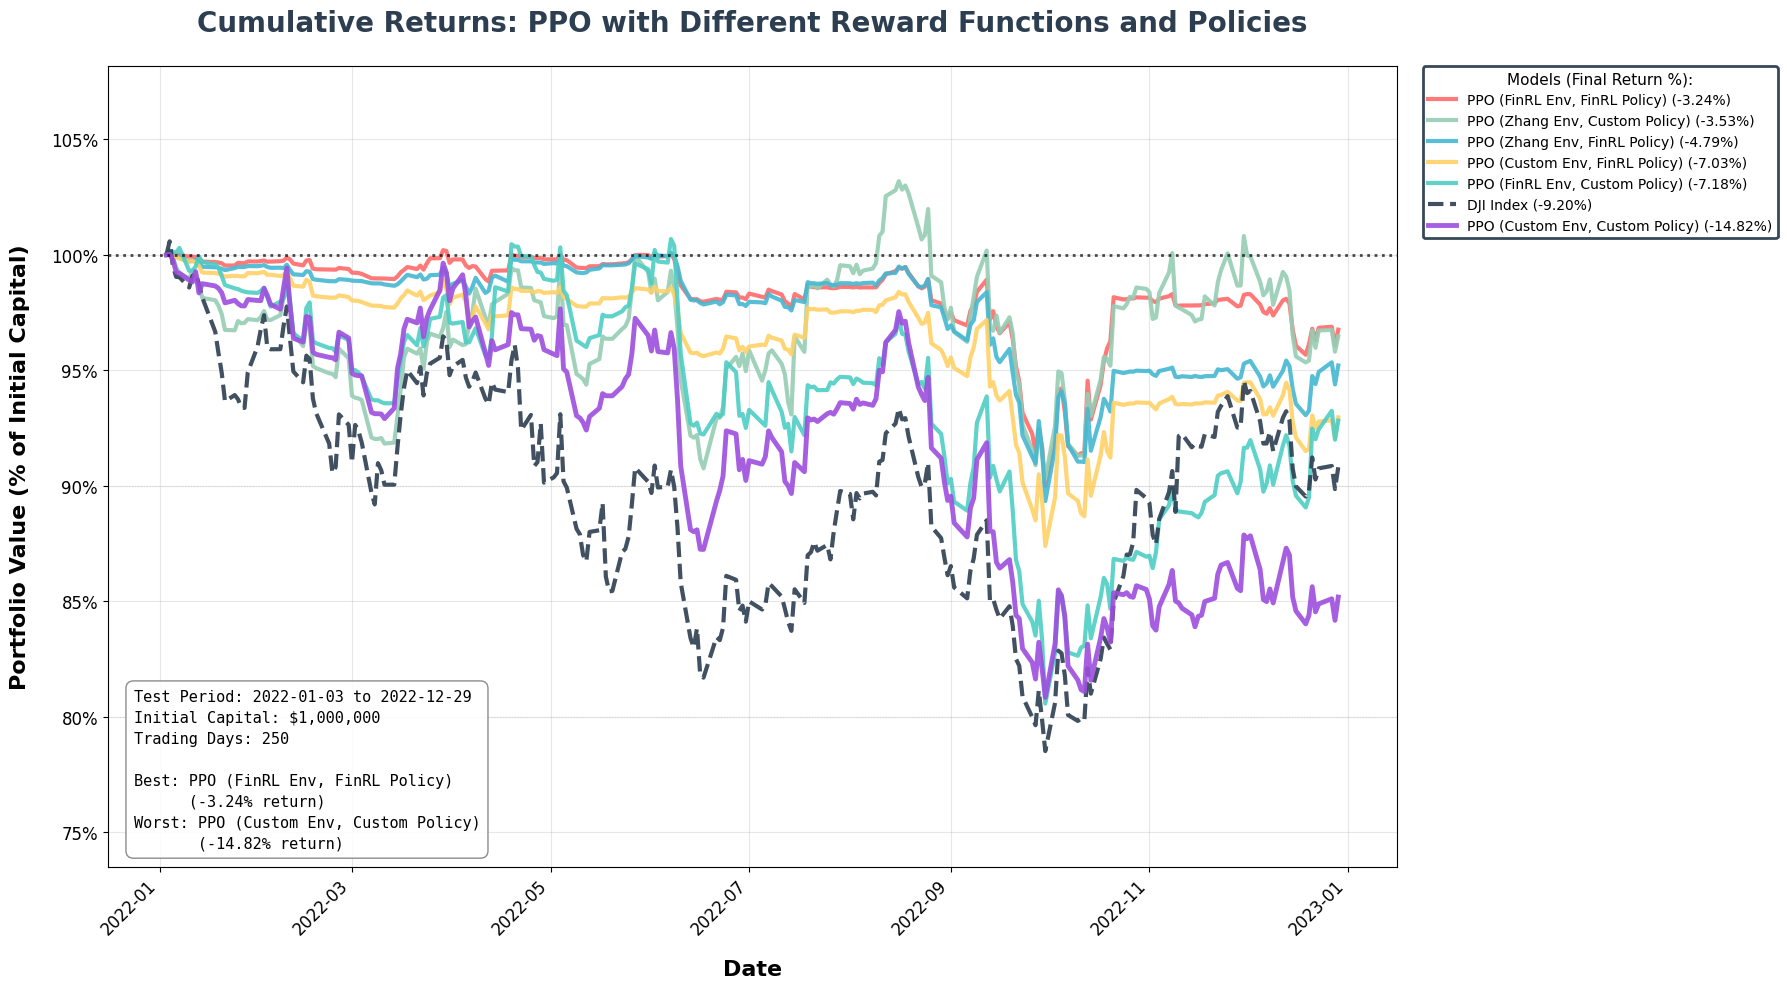


✅ График сохранен: /content/drive/MyDrive/RL/results_6_ppo/ppo_all_configurations.png


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import os
%matplotlib inline
# Создание основного графика
fig, ax = plt.subplots(figsize=(18, 10))

# Цветовая схема для моделей (6 цветов + DJI)
model_colors = {
    'ppo_finrl_finrl': '#FF6B6B',      # Красный
    'ppo_finrl_custom': '#4ECDC4',     # Бирюзовый
    'ppo_zhang_finrl': '#45B7D1',      # Голубой
    'ppo_zhang_custom': '#96CEB4',     # Зеленый
    'ppo_custom_finrl': '#FFD166',     # Желтый
    'ppo_custom_custom': '#9D4EDD',    # Фиолетовый
    'dji': '#2C3E50'                   # Темно-синий (для DJI)
}

# Полные имена для легенды
model_names_full = {
    'ppo_finrl_finrl': 'PPO (FinRL Env, FinRL Policy)',
    'ppo_finrl_custom': 'PPO (FinRL Env, Custom Policy)',
    'ppo_zhang_finrl': 'PPO (Zhang Env, FinRL Policy)',
    'ppo_zhang_custom': 'PPO (Zhang Env, Custom Policy)',
    'ppo_custom_finrl': 'PPO (Custom Env, FinRL Policy)',
    'ppo_custom_custom': 'PPO (Custom Env, Custom Policy)',
    'dji': 'DJI Index'
}

# Убедимся, что индексы в datetime формате
if hasattr(final_result_df.index, 'dtype') and final_result_df.index.dtype == 'object':
    final_result_df.index = pd.to_datetime(final_result_df.index)

# Толщина линий
line_widths = {col: 3.0 for col in final_result_df.columns}
if 'ppo_custom_custom' in final_result_df.columns:
    line_widths['ppo_custom_custom'] = 3.5  # Выделяем вашу полную конфигурацию

# Сортируем модели по итоговой доходности
final_returns = {}
for model in final_result_df.columns:
    if len(final_result_df[model].dropna()) > 0:
        final_value = final_result_df[model].dropna().iloc[-1]
        initial_value = final_result_df[model].dropna().iloc[0]
        if initial_value != 0:
            final_returns[model] = (final_value / initial_value - 1) * 100
            print(f"{model_names_full.get(model, model)}: "
                  f"Initial=${initial_value:,.2f}, "
                  f"Final=${final_value:,.2f}, "
                  f"Return={final_returns[model]:.2f}%")

models_sorted = sorted(final_returns.keys(),
                      key=lambda x: final_returns[x],
                      reverse=True) if final_returns else final_result_df.columns.tolist()

# Рисуем линии в порядке убывания доходности
for model in models_sorted:
    if model in final_result_df.columns:
        data = final_result_df[model].dropna()
        if len(data) > 1:
            # Нормализуем к начальному капиталу
            initial_value = data.iloc[0]
            normalized_data = data / initial_value * 100

            # Для DJI используем пунктирную линию, для RL моделей - сплошную
            linestyle = '--' if model == 'dji' else '-'

            # Получаем цвет модели
            color = model_colors.get(model, '#000000')

            ax.plot(data.index, normalized_data,
                    label=f"{model_names_full.get(model, model)} ({final_returns.get(model, 0):.2f}%)",
                    color=color,
                    linestyle=linestyle,
                    linewidth=line_widths.get(model, 3),
                    alpha=0.9)

# Настройка графика
ax.set_title('Cumulative Returns: PPO with Different Reward Functions and Policies',
             fontsize=20, fontweight='bold', pad=25, color='#2c3e50')

ax.set_ylabel('Portfolio Value (% of Initial Capital)',
              fontsize=16, fontweight='bold', labelpad=15)

ax.set_xlabel('Date', fontsize=16, fontweight='bold', labelpad=15)

# Форматирование оси Y в процентах
def percent_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Добавляем горизонтальную линию на уровне 100% (начальный капитал)
ax.axhline(y=100, color='black', linestyle=':', linewidth=2.0, alpha=0.7)

# Добавляем фон с горизонтальными уровнями
for level in [80, 90, 100, 110, 120, 130, 140, 150]:
    if level == 100:
        continue
    ax.axhline(y=level, color='gray', linestyle=':', linewidth=0.8, alpha=0.2)

# Легенда
if len(models_sorted) > 0:
    legend = ax.legend(loc='upper left', fontsize=10, frameon=True,
                      framealpha=0.95, edgecolor='#2c3e50',
                      facecolor='white', title='Models (Final Return %):',
                      title_fontsize=11, bbox_to_anchor=(1.02, 1),
                      borderaxespad=0.)
    legend.get_frame().set_linewidth(2)

# Сетка
ax.grid(True, alpha=0.3, linestyle='-', which='both')

# Добавляем информационный блок
if len(final_result_df) > 0:
    start_date = final_result_df.index[0].strftime('%Y-%m-%d')
    end_date = final_result_df.index[-1].strftime('%Y-%m-%d')

    info_text = f"Test Period: {start_date} to {end_date}\n"
    info_text += f"Initial Capital: $1,000,000\n"
    info_text += f"Trading Days: {len(final_result_df)}\n"

    if final_returns:
        best_model = max(final_returns.items(), key=lambda x: x[1])
        worst_model = min(final_returns.items(), key=lambda x: x[1])

        info_text += f"\nBest: {model_names_full.get(best_model[0], best_model[0])}\n"
        info_text += f"      ({best_model[1]:.2f}% return)\n"
        info_text += f"Worst: {model_names_full.get(worst_model[0], worst_model[0])}\n"
        info_text += f"       ({worst_model[1]:.2f}% return)"

    props = dict(boxstyle='round', facecolor='white', alpha=0.9,
                edgecolor='gray', pad=0.5)
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', bbox=props, fontfamily='monospace',
            linespacing=1.5)

# Поворот дат на оси X
plt.xticks(rotation=45, ha='right')

# Устанавливаем отступы для осей
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)

# Автоматическое масштабирование оси Y
if len(final_result_df) > 0:
    all_values = []
    for model in final_result_df.columns:
        data = final_result_df[model].dropna()
        if len(data) > 0:
            initial_value = data.iloc[0]
            normalized = data / initial_value * 100
            all_values.extend(normalized.values)

    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        y_padding = max((y_max - y_min) * 0.1, 5)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.show()

# Сохранение графика
save_dir = "/content/drive/MyDrive/RL/results_6_ppo"
os.makedirs(save_dir, exist_ok=True)

fig.savefig(f'{save_dir}/ppo_all_configurations.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

print(f"\n✅ График сохранен: {save_dir}/ppo_all_configurations.png")

📋 Формирование сводной таблицы метрик

📊 СВОДНАЯ ТАБЛИЦА МЕТРИК (отсортировано по Sharpe Ratio)
               Cumulative returns  Annual return  Annual volatility  \
zhang_custom              -0.0362        -0.0363             0.1588   
finrl_finrl               -0.0344        -0.0345             0.0826   
finrl_custom              -0.0742        -0.0745             0.1628   
zhang_finrl               -0.0501        -0.0503             0.0894   
custom_finrl              -0.0731        -0.0734             0.1012   
custom_custom             -0.1508        -0.1514             0.1691   

               Sharpe ratio  Max drawdown  
zhang_custom        -0.1549       -0.1250  
finrl_finrl         -0.3858       -0.1018  
finrl_custom        -0.3961       -0.1998  
zhang_finrl         -0.5348       -0.1074  
custom_finrl        -0.7052       -0.1263  
custom_custom       -0.8899       -0.1918  

✅ Таблица метрик сохранена: /content/drive/MyDrive/RL/results_6_ppo/ppo_50000_metrics_summary.csv

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


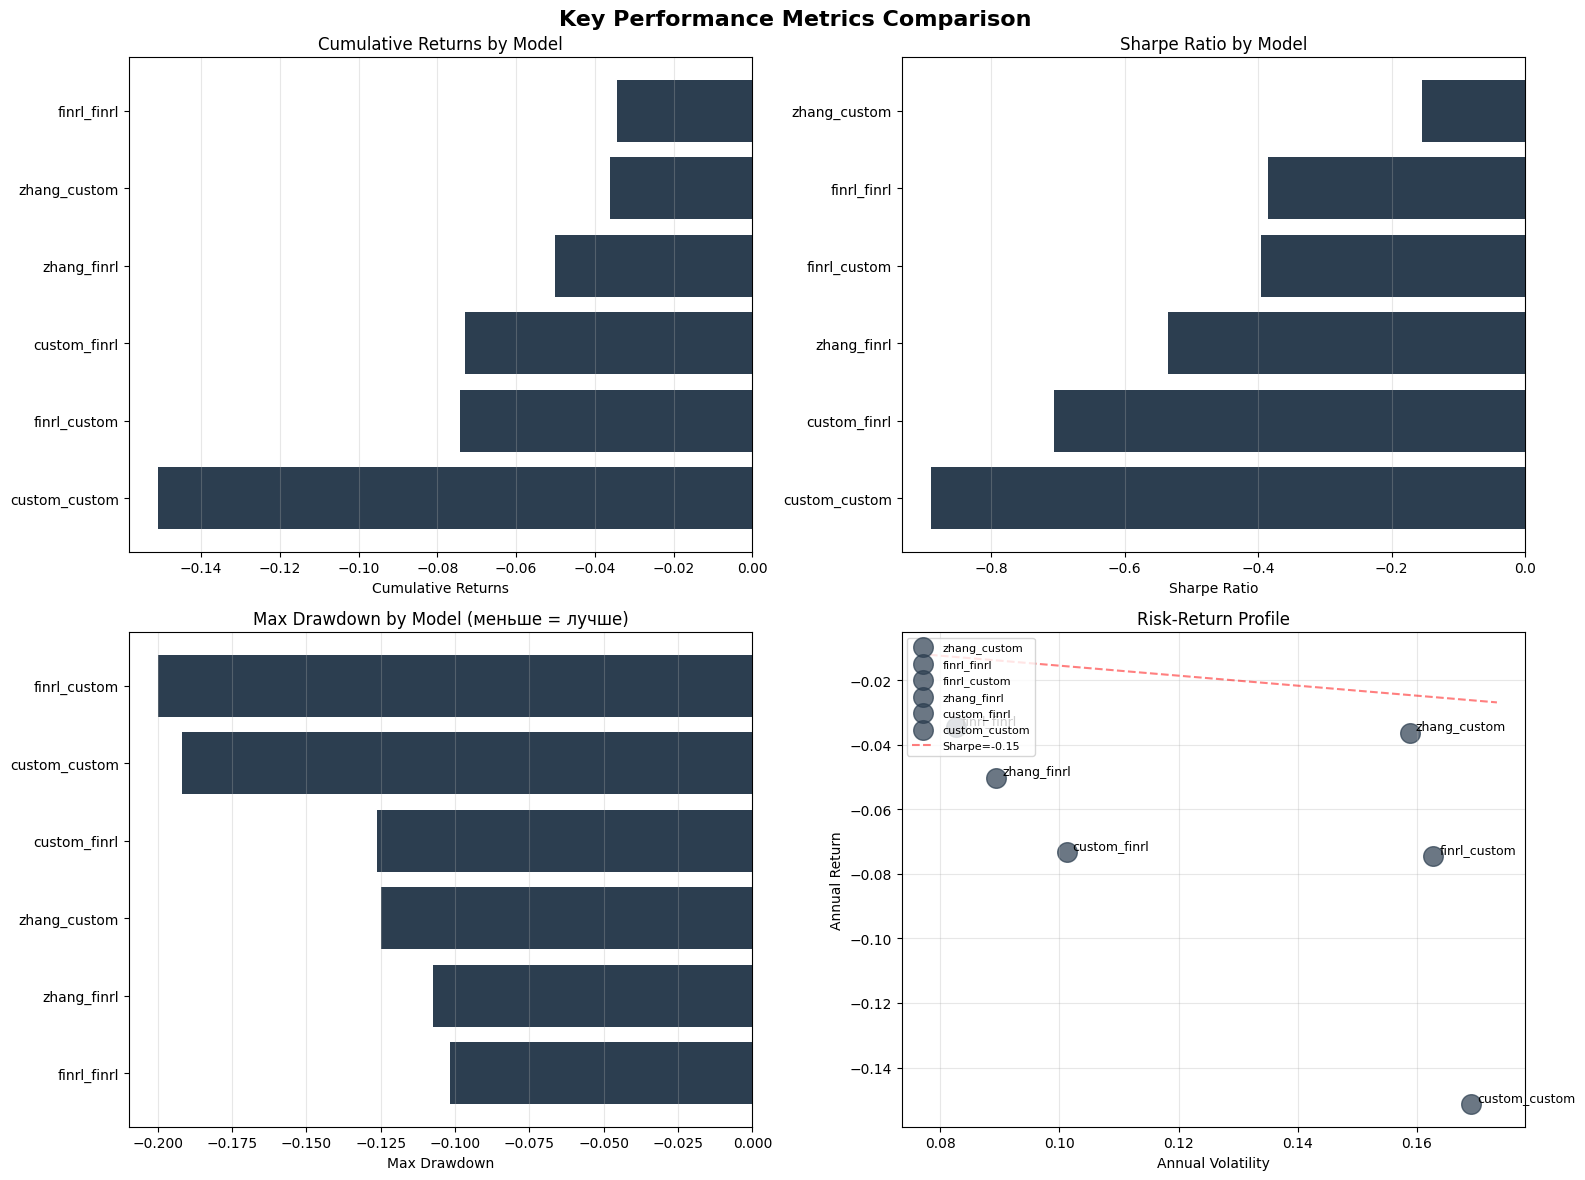

✅ График метрик сохранен: /content/drive/MyDrive/RL/results_6_ppo/ppo_50000_metrics_comparison.png


In [62]:
print("📋 Формирование сводной таблицы метрик")
print("=" * 60)

# Собираем все метрики
all_models = {}
for config_name, stats_df in perf_stats.items():
    if stats_df is not None and not stats_df.empty:
        all_models[config_name] = stats_df

# Добавляем DJI если есть
if 'dji' in final_result_df.columns:
    try:
        dji_stats = backtest_stats(account_value=final_result_df[['dji']])
        all_models['dji'] = pd.DataFrame(dji_stats)
    except:
        pass

# Формируем сводную таблицу
summary_metrics = pd.DataFrame()
key_metrics = [
    'Cumulative returns',
    'Annual return',
    'Annual volatility',
    'Sharpe ratio',
    'Max drawdown'
]

for model_name, model_stats in all_models.items():
    if model_stats is not None:
        if isinstance(model_stats, pd.DataFrame):
            if model_stats.shape[1] == 1:
                model_series = model_stats.iloc[:, 0]
            else:
                model_series = model_stats.iloc[:, 0]
        elif isinstance(model_stats, pd.Series):
            model_series = model_stats
        else:
            print(f"  Пропускаю {model_name} - неподдерживаемый формат")
            continue

        metrics_dict = {}
        display_name = model_names_full.get(model_name, model_name)

        for metric in key_metrics:
            if metric in model_series.index:
                metrics_dict[metric] = model_series[metric]
            else:
                found = False
                for idx in model_series.index:
                    if metric.lower() in str(idx).lower():
                        metrics_dict[metric] = model_series[idx]
                        found = True
                        break
                if not found:
                    metrics_dict[metric] = np.nan

        summary_metrics[display_name] = pd.Series(metrics_dict)

summary_metrics = summary_metrics.T

# Сортируем по Sharpe ratio (по убыванию)
if 'Sharpe ratio' in summary_metrics.columns:
    summary_metrics = summary_metrics.sort_values('Sharpe ratio', ascending=False)

print("\n📊 СВОДНАЯ ТАБЛИЦА МЕТРИК (отсортировано по Sharpe Ratio)")
print("=" * 80)
print(summary_metrics.round(4))

# Сохраняем таблицу в CSV
summary_metrics.to_csv(f'{save_dir}/ppo_50000_metrics_summary.csv')
print(f"\n✅ Таблица метрик сохранена: {save_dir}/ppo_50000_metrics_summary.csv")

# Визуализация метрик
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Performance Metrics Comparison', fontsize=16, fontweight='bold')

# 1. Cumulative Returns
if 'Cumulative returns' in summary_metrics.columns:
    ax1 = axes[0, 0]
    sorted_by_cumret = summary_metrics.sort_values('Cumulative returns', ascending=True)
    colors = [model_colors.get(model.split(' ')[1].lower(), '#808080')
              if '(' in model else model_colors.get('dji', '#2C3E50')
              for model in sorted_by_cumret.index]
    ax1.barh(sorted_by_cumret.index, sorted_by_cumret['Cumulative returns'], color=colors)
    ax1.set_xlabel('Cumulative Returns')
    ax1.set_title('Cumulative Returns by Model')
    ax1.grid(True, alpha=0.3, axis='x')

# 2. Sharpe Ratio
if 'Sharpe ratio' in summary_metrics.columns:
    ax2 = axes[0, 1]
    sorted_by_sharpe = summary_metrics.sort_values('Sharpe ratio', ascending=True)
    colors = [model_colors.get(model.split(' ')[1].lower(), '#808080')
              if '(' in model else model_colors.get('dji', '#2C3E50')
              for model in sorted_by_sharpe.index]
    ax2.barh(sorted_by_sharpe.index, sorted_by_sharpe['Sharpe ratio'], color=colors)
    ax2.set_xlabel('Sharpe Ratio')
    ax2.set_title('Sharpe Ratio by Model')
    ax2.grid(True, alpha=0.3, axis='x')

# 3. Max Drawdown
if 'Max drawdown' in summary_metrics.columns:
    ax3 = axes[1, 0]
    sorted_by_dd = summary_metrics.sort_values('Max drawdown', ascending=False)
    colors = [model_colors.get(model.split(' ')[1].lower(), '#808080')
              if '(' in model else model_colors.get('dji', '#2C3E50')
              for model in sorted_by_dd.index]
    ax3.barh(sorted_by_dd.index, sorted_by_dd['Max drawdown'], color=colors)
    ax3.set_xlabel('Max Drawdown')
    ax3.set_title('Max Drawdown by Model (меньше = лучше)')
    ax3.grid(True, alpha=0.3, axis='x')

# 4. Annual Return vs Volatility
if 'Annual return' in summary_metrics.columns and 'Annual volatility' in summary_metrics.columns:
    ax4 = axes[1, 1]
    for model in summary_metrics.index:
        color = model_colors.get(model.split(' ')[1].lower(), '#808080') if '(' in model else model_colors.get('dji', '#2C3E50')
        ax4.scatter(summary_metrics.loc[model, 'Annual volatility'],
                   summary_metrics.loc[model, 'Annual return'],
                   color=color, s=200, alpha=0.7, label=model)
        ax4.text(summary_metrics.loc[model, 'Annual volatility'] + 0.001,
                summary_metrics.loc[model, 'Annual return'] + 0.001,
                model[:15] + '...' if len(model) > 15 else model,
                fontsize=9)
    ax4.set_xlabel('Annual Volatility')
    ax4.set_ylabel('Annual Return')
    ax4.set_title('Risk-Return Profile')
    ax4.grid(True, alpha=0.3)
    # Добавляем линию эффективности
    x_vals = np.array(ax4.get_xlim())
    if 'Sharpe ratio' in summary_metrics.columns:
        best_sharpe = summary_metrics['Sharpe ratio'].max()
        if not np.isnan(best_sharpe):
            ax4.plot(x_vals, best_sharpe * x_vals, 'r--', alpha=0.5, label=f'Sharpe={best_sharpe:.2f}')
    ax4.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# Сохраняем график метрик
fig.savefig(f'{save_dir}/ppo_50000_metrics_comparison.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
print(f"✅ График метрик сохранен: {save_dir}/ppo_50000_metrics_comparison.png")

In [63]:
print("💾 Сохранение всех результатов эксперимента")
print("=" * 60)

# Создаем директории
results_dir = "/content/drive/MyDrive/RL/results_6_ppo/ppo_50000"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(f"{results_dir}/models", exist_ok=True)
os.makedirs(f"{results_dir}/data", exist_ok=True)
os.makedirs(f"{results_dir}/visualizations", exist_ok=True)

# 1. Сохраняем обученные модели
print("Сохранение моделей...")
for config_name, model in trained_models.items():
    if model is not None:
        try:
            model.save(f"{results_dir}/models/ppo_{config_name}.zip")
            print(f"  ✅ Модель {config_name} сохранена")
        except Exception as e:
            print(f"  ❌ Ошибка при сохранении модели {config_name}: {e}")

# 2. Сохраняем значения счетов
print("\nСохранение данных счетов...")
for config_name, df in df_account_values.items():
    if df is not None:
        try:
            df.to_csv(f"{results_dir}/data/account_values_{config_name}.csv")
            print(f"  ✅ Данные счета {config_name} сохранены")
        except Exception as e:
            print(f"  ❌ Ошибка при сохранении данных счета {config_name}: {e}")

# 3. Сохраняем действия агентов
print("\nСохранение действий агентов...")
for config_name, df in df_actions.items():
    if df is not None:
        try:
            df.to_csv(f"{results_dir}/data/actions_{config_name}.csv")
            print(f"  ✅ Действия {config_name} сохранены")
        except Exception as e:
            print(f"  ❌ Ошибка при сохранении действий {config_name}: {e}")

# 4. Сохраняем финальный DataFrame
try:
    final_result_df.to_csv(f"{results_dir}/data/final_results_all_configs.csv")
    print(f"\n✅ Финальный DataFrame сохранен: {results_dir}/data/final_results_all_configs.csv")
except Exception as e:
    print(f"\n❌ Ошибка при сохранении финального DataFrame: {e}")

# 5. Сохраняем метрики
try:
    summary_metrics.to_csv(f"{results_dir}/data/performance_metrics_summary.csv")
    print(f"✅ Сводные метрики сохранены: {results_dir}/data/performance_metrics_summary.csv")
except Exception as e:
    print(f"❌ Ошибка при сохранении метрик: {e}")

# 6. Создаем README файл с описанием эксперимента
readme_content = f"""# Эксперимент: Reinforcement Learning for Time-Series Forecasting

## Описание эксперимента
Сравнение 6 конфигураций алгоритма PPO с различными функциями награды и архитектурами политик.

## Конфигурации
1. PPO, FinRL env, FinRL policy
2. PPO, FinRL env, Custom policy
3. PPO, Zhang env, FinRL policy
4. PPO, Zhang env, Custom policy
5. PPO, Custom env, FinRL policy
6. PPO, Custom env, Custom policy

## Параметры
- State space: {state_space}
- Total timesteps: {50000}
- Дата эксперимента: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Результаты
Лучшая модель по Sharpe Ratio: {summary_metrics.index[0] if not summary_metrics.empty else 'N/A'}
Все результаты сохранены в соответствующих папках.
"""

with open(f"{results_dir}/README.md", "w", encoding="utf-8") as f:
    f.write(readme_content)

print(f"\n✅ README файл создан: {results_dir}/README.md")
print("\n" + "=" * 60)
print("🎉 ЭКСПЕРИМЕНТ УСПЕШНО ЗАВЕРШЕН!")
print(f"Все результаты сохранены в папке: {results_dir}")
print("=" * 60)

💾 Сохранение всех результатов эксперимента
Сохранение моделей...
  ✅ Модель finrl_finrl сохранена
  ✅ Модель finrl_custom сохранена
  ✅ Модель zhang_finrl сохранена
  ✅ Модель zhang_custom сохранена
  ✅ Модель custom_finrl сохранена
  ✅ Модель custom_custom сохранена

Сохранение данных счетов...
  ✅ Данные счета finrl_finrl сохранены
  ✅ Данные счета finrl_custom сохранены
  ✅ Данные счета zhang_finrl сохранены
  ✅ Данные счета zhang_custom сохранены
  ✅ Данные счета custom_finrl сохранены
  ✅ Данные счета custom_custom сохранены

Сохранение действий агентов...
  ✅ Действия finrl_finrl сохранены
  ✅ Действия finrl_custom сохранены
  ✅ Действия zhang_finrl сохранены
  ✅ Действия zhang_custom сохранены
  ✅ Действия custom_finrl сохранены
  ✅ Действия custom_custom сохранены

✅ Финальный DataFrame сохранен: /content/drive/MyDrive/RL/results_6_ppo/ppo_50000/data/final_results_all_configs.csv
✅ Сводные метрики сохранены: /content/drive/MyDrive/RL/results_6_ppo/ppo_50000/data/performance_met

# 📊 Метрики оценки инвестиционной эффективности

## Подробное описание всех метрик бэктеста

| Метрика | Формула/Расчет | Описание | Интерпретация | Что лучше |
|---------|----------------|-----------|---------------|-----------|
| **Annual Return**<br>Годовая доходность | `(1 + Cumulative Return)^(1/Years) - 1` | Среднегодовая доходность портфеля, приведенная к годовому выражению | Показывает средний ежегодный прирост капитала. 16.46% означает рост на 16.46% в год в среднем | Выше |
| **Cumulative Returns**<br>Кумулятивная доходность | `(Конечная стоимость / Начальная стоимость) - 1` | Общая доходность за весь период тестирования | 55.57% означает, что начальные 1000000  превратились  в  1555700 долларов за весь период | Выше |
| **Annual Volatility**<br>Годовая волатильность | `Std(Дневные доходности) × √252` (252 - ср. кол-во торг. дней в году)| Стандартное отклонение доходности, мера риска и нестабильности | Показывает разброс доходностей. 21.76% означает типичное отклонение ±21.76% от средней доходности | Ниже |
| **Sharpe Ratio**<br>Коэффициент Шарпа | `(Return - RiskFree) / Volatility` | Доходность на единицу общего риска (включая безрисковую ставку) | 0.81 означает, что на каждую единицу риска (волатильности) портфель приносит 0.81 единицы превышения над безрисковой ставкой. | Выше |
| **Calmar Ratio**<br>Коэффициент Калмара | `Annual Return / abs(Max Drawdown)` | Доходность относительно максимальной просадки | 0.61 означает, что годовая доходность составляет 61% от максимальной просадки. Это НЕ означает убыточность! Годовая доходность положительная (+16.46%), просто она меньше, чем глубина максимальной просадки (-27.10%). | Выше |
| **Stability**<br>Стабильность | `R² линейного тренда доходности` | Стабильность и предсказуемость роста портфеля | 0.88 означает очень стабильный рост (1.0 - идеальная стабильность) | Выше |
| **Max Drawdown**<br>Максимальная просадка | `Min((Пик - Дно) / Пик)` | Наибольшее падение от предыдущего пика до минимума | -27.10% означает максимальная потеря от пика составила 27.10% | Выше (менее отрицательный) |
| **Omega Ratio**<br>Омега коэффициент | `∫(r до L)(1 - F(r))dr / ∫(L до ∞)F(r)dr` | Соотношение вероятностей получения прибыли и убытка относительно порога | 1.23 означает 23% превышение шансов получить прибыль над убытком | Выше |
| **Sortino Ratio**<br>Коэффициент Сортино | `(Return - RiskFree) / Downside Deviation` | Доходность на единицу downside риска (только негативная волатильность) | 1.19 - улучшенная версия Sharpe, учитывает только плохую волатильность | Выше |
| **Tail Ratio**<br>Хвостовой коэффициент | `Percentile(95%) / abs(Percentile(5%))` | Соотношение крайних положительных и отрицательных доходностей | 0.92 означает, что лучшие 5% дней приносят 92% от того, что теряется в худшие 5% дней | Выше |
| **Daily Value at Risk**<br>Дневной VaR | `Percentile(5% дневных доходностей)` | Потенциальные максимальные дневные потери с 95% вероятностью | -2.67% означает, что с 95% вероятностью дневные потери не превысят 2.67% | Выше (менее отрицательный) |
| **Skew**<br>Асимметрия | `E[((X - μ)/σ)³]` | Асимметрия распределения доходностей | Положительная - больше маленьких потерь и редких больших прибылей. NaN - недостаточно данных | Зависит от стратегии |
| **Kurtosis**<br>Эксцесс | `E[((X - μ)/σ)⁴]` | "Толстохвостость" распределения доходностей | Высокий - больше экстремальных событий. NaN - недостаточно данных | Умеренный лучше |

---

## 🎯 Ключевые группы метрик

### **Доходность**
- **Annual Return** - годовая эффективность
- **Cumulative Returns** - общая эффективность за период

### **Риск**
- **Annual Volatility** - общая нестабильность
- **Max Drawdown** - максимальные потери
- **Daily VaR** - дневной риск

### **Risk-Adjusted Returns**
- **Sharpe Ratio** - эффективность на единицу общего риска
- **Sortino Ratio** - эффективность на единицу downside риска
- **Calmar Ratio** - эффективность относительно просадок
- **Omega Ratio** - соотношение шансов прибыли/убытков

### **Стабильность и распределение**
- **Stability** - предсказуемость роста
- **Tail Ratio** - баланс экстремальных событий
- **Skew/Kurtosis** - форма распределения доходностей